In [192]:
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from cimcb.model import PLS_SIMPLS as PLSDA
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
import NN_LogitLogit as ANN
from statsmodels.stats.multitest import multipletests

def looCrossVal(X,y,obj,fit_func,pred_func,k=10):
    loo = KFold(n_splits=k)#LeaveOneOut()
    #loo = LeaveOneOut()
    loo.get_n_splits(X)
    y_true = []
    y_preds = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        fit_func(obj,X_train,y_train)
        y_preds += list(pred_func(obj,X_test))
        y_true += list(y_test)
    return r2_score(y_true, y_preds),y_preds,y_true

In [193]:
datafilename = "06_16_2020_identified_features_peak_areas_imputted.csv"
data = pd.read_csv(datafilename)
#data = data.fillna(0)
print(data)

     Unnamed: 0                        Molecule Name Molecule Formula  \
0             0  1_(Z)-3-Hydroxyoctadec-7-enoic acid         C18H34O3   
1             1             2_1 5 Anhydro D glucitol          C6H12O5   
2             2                  3_1 Methyluric acid         C6H6N4O3   
3             3   4_1_4-Cyclohexanedicarboxylic acid          C8H12O4   
4             4               5_14 Z Eicosenoic acid         C20H38O2   
..          ...                                  ...              ...   
230         230                          238_Skatole            C9H9N   
231         231                          239_Taurine         C2H7NO3S   
232         232                        240_Terbucarb        C17H27NO2   
233         233                     241_Theophylline         C7H8N4O2   
234         234       242_trans 3 Indoleacrylic acid         C11H9NO2   

     Precursor Charge  Precursor Mz  Explicit Retention Time  \
0                  -1    297.243519                     0.8

In [194]:
areaCols = [x for x in data.columns.values if "Area" in x]
areaData = data[areaCols].transpose()
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]


In [195]:
data_imp  = np.log2(areaData.to_numpy())
data_imp_norm = quantile_transform(data_imp,1)
#data_imp_norm = combat.combat(pd.DataFrame(data_imp.transpose()),batchInfo).transpose().to_numpy()
pkl.dump(data_imp_norm,open("peak_areas_id_imp_norm.pkl","wb"))
pkl.dump(data_imp,open("peak_areas_id_imp.pkl","wb"))


# data_imp = pkl.load(open("peak_areas_id_imp.pkl","rb"))
# data_imp_norm = pkl.load(open("peak_areas_id_imp_norm.pkl","rb"))

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2670: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (235). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [196]:
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
blankData = data_imp_norm[blankSamp]
print(len(blankSamp))

22


In [197]:
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
qcData = data_imp_norm[qcSamp]
print(len(qcData))

45


In [198]:
sampCols = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
sampData = data_imp_norm[sampCols]
print(len(sampCols))

319


Text(0.5, 1.0, 'w/o combat')

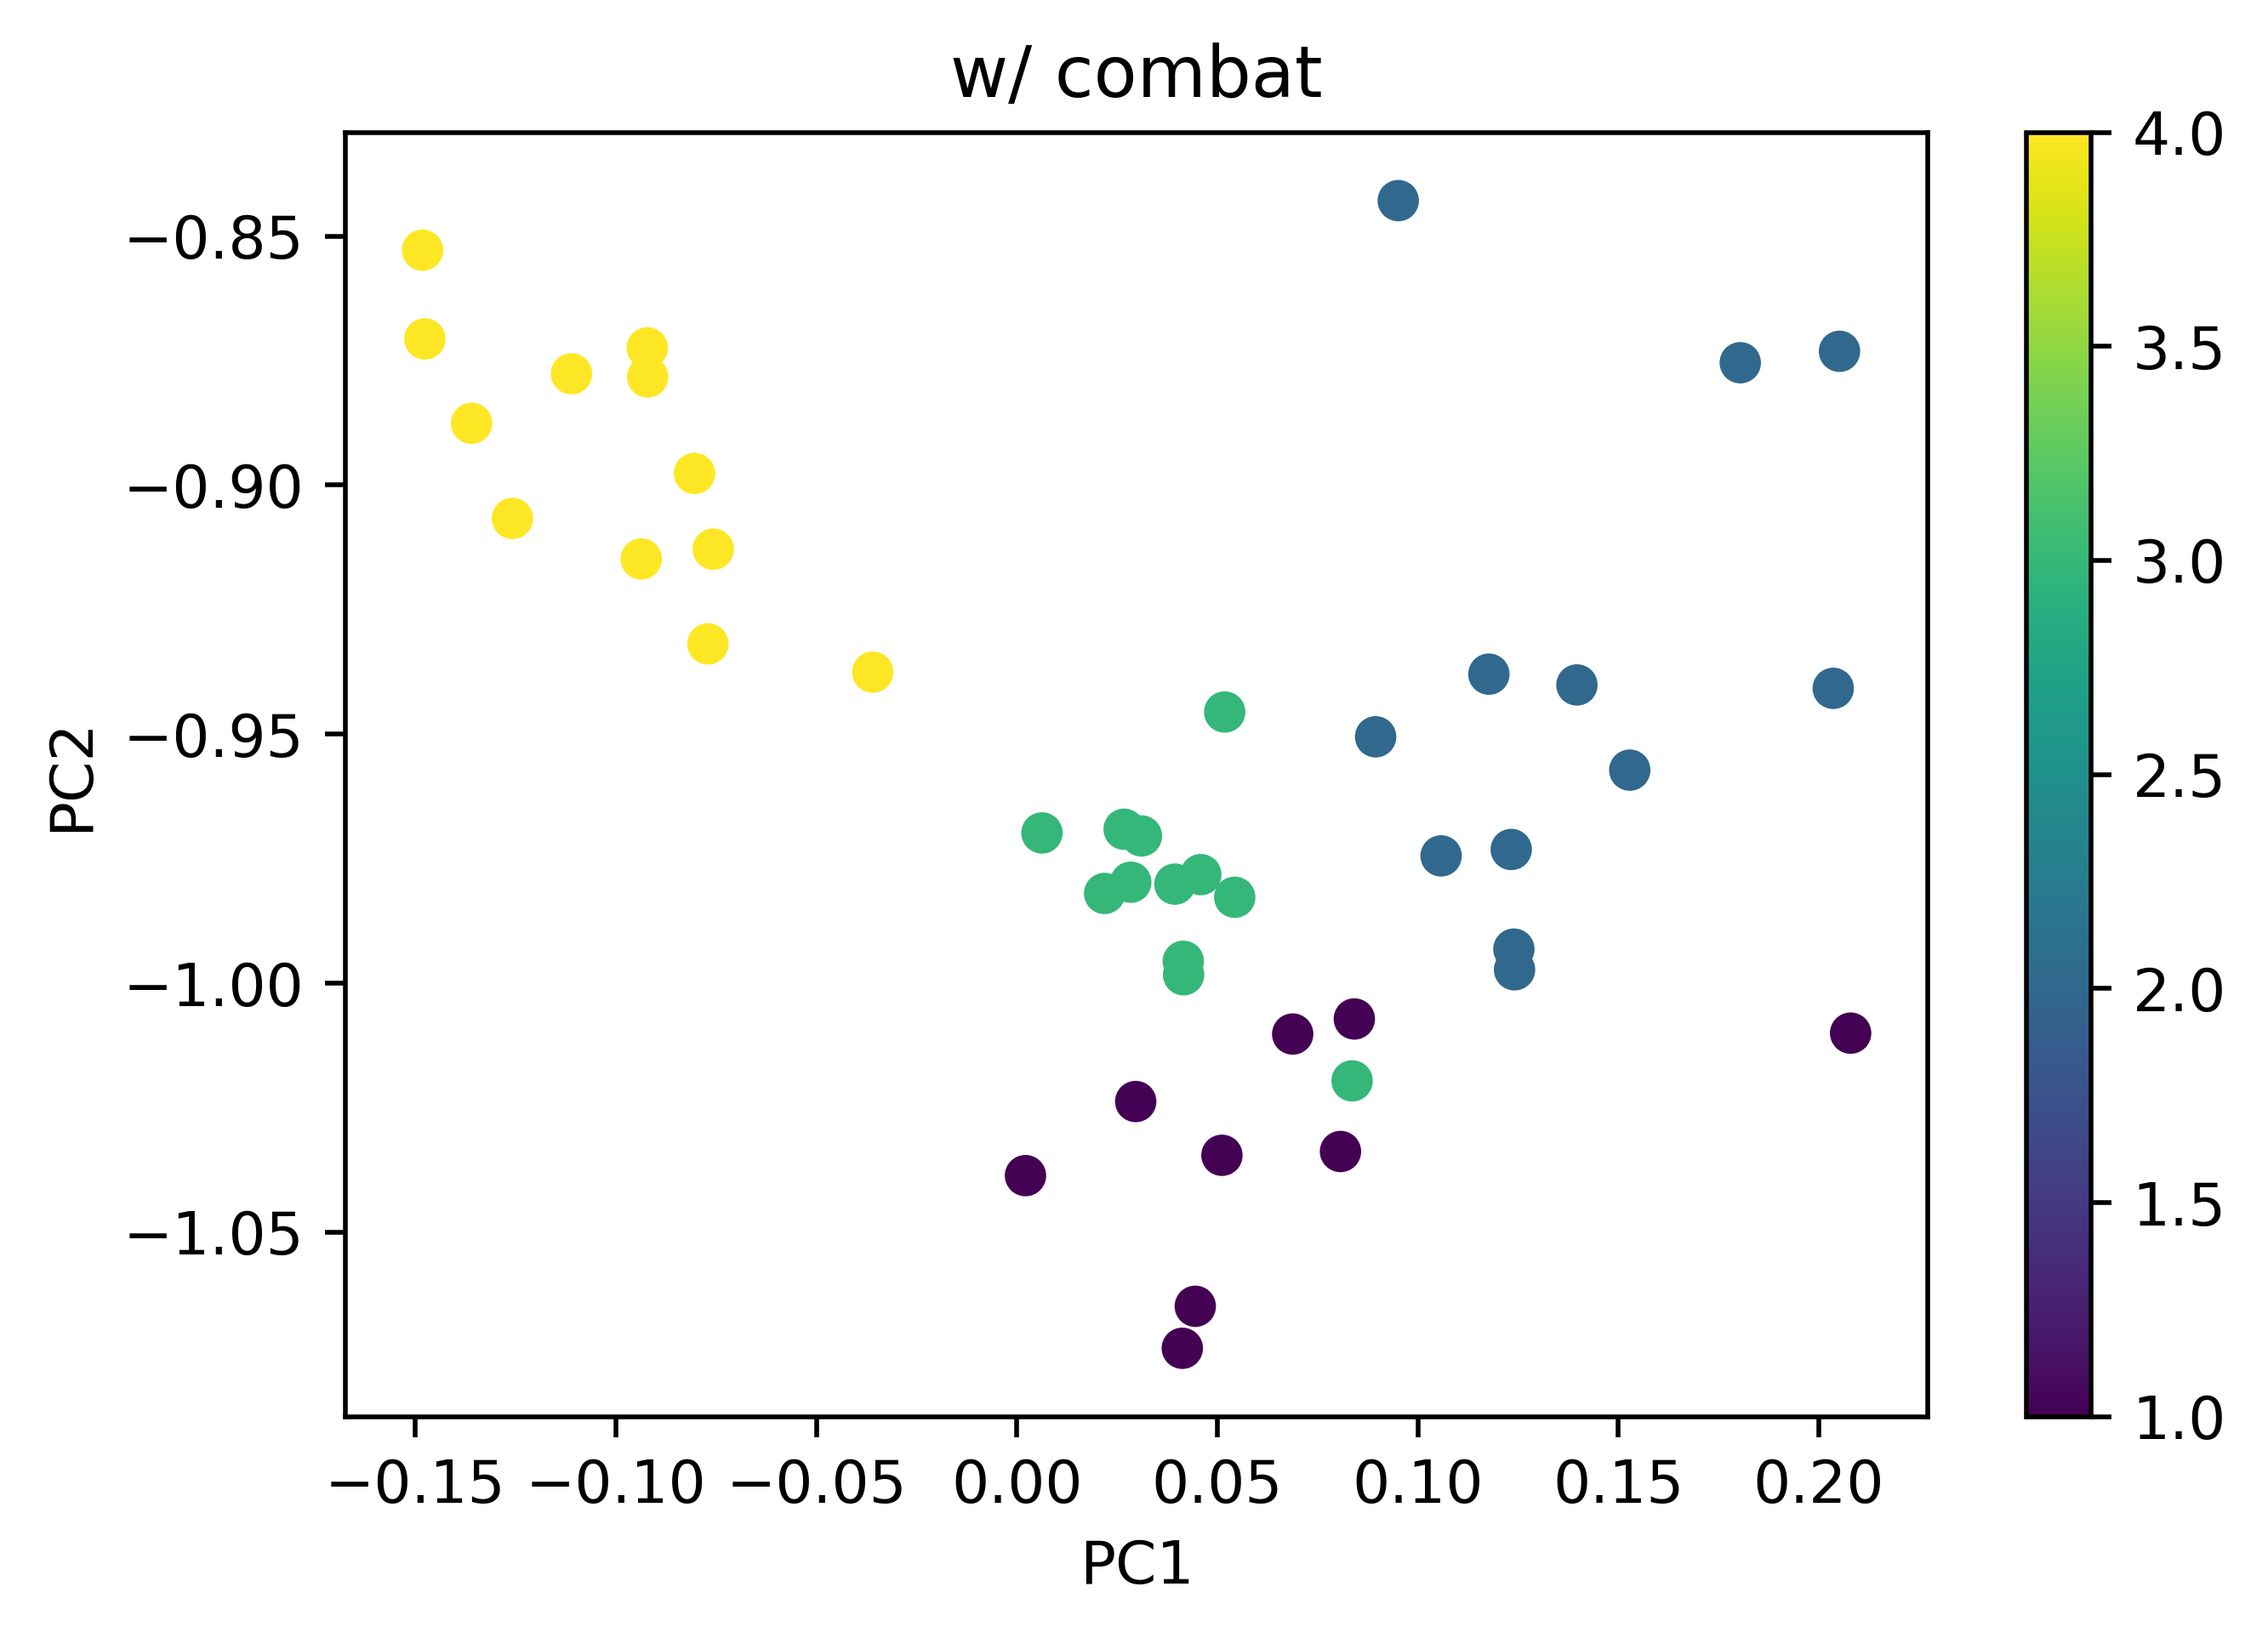

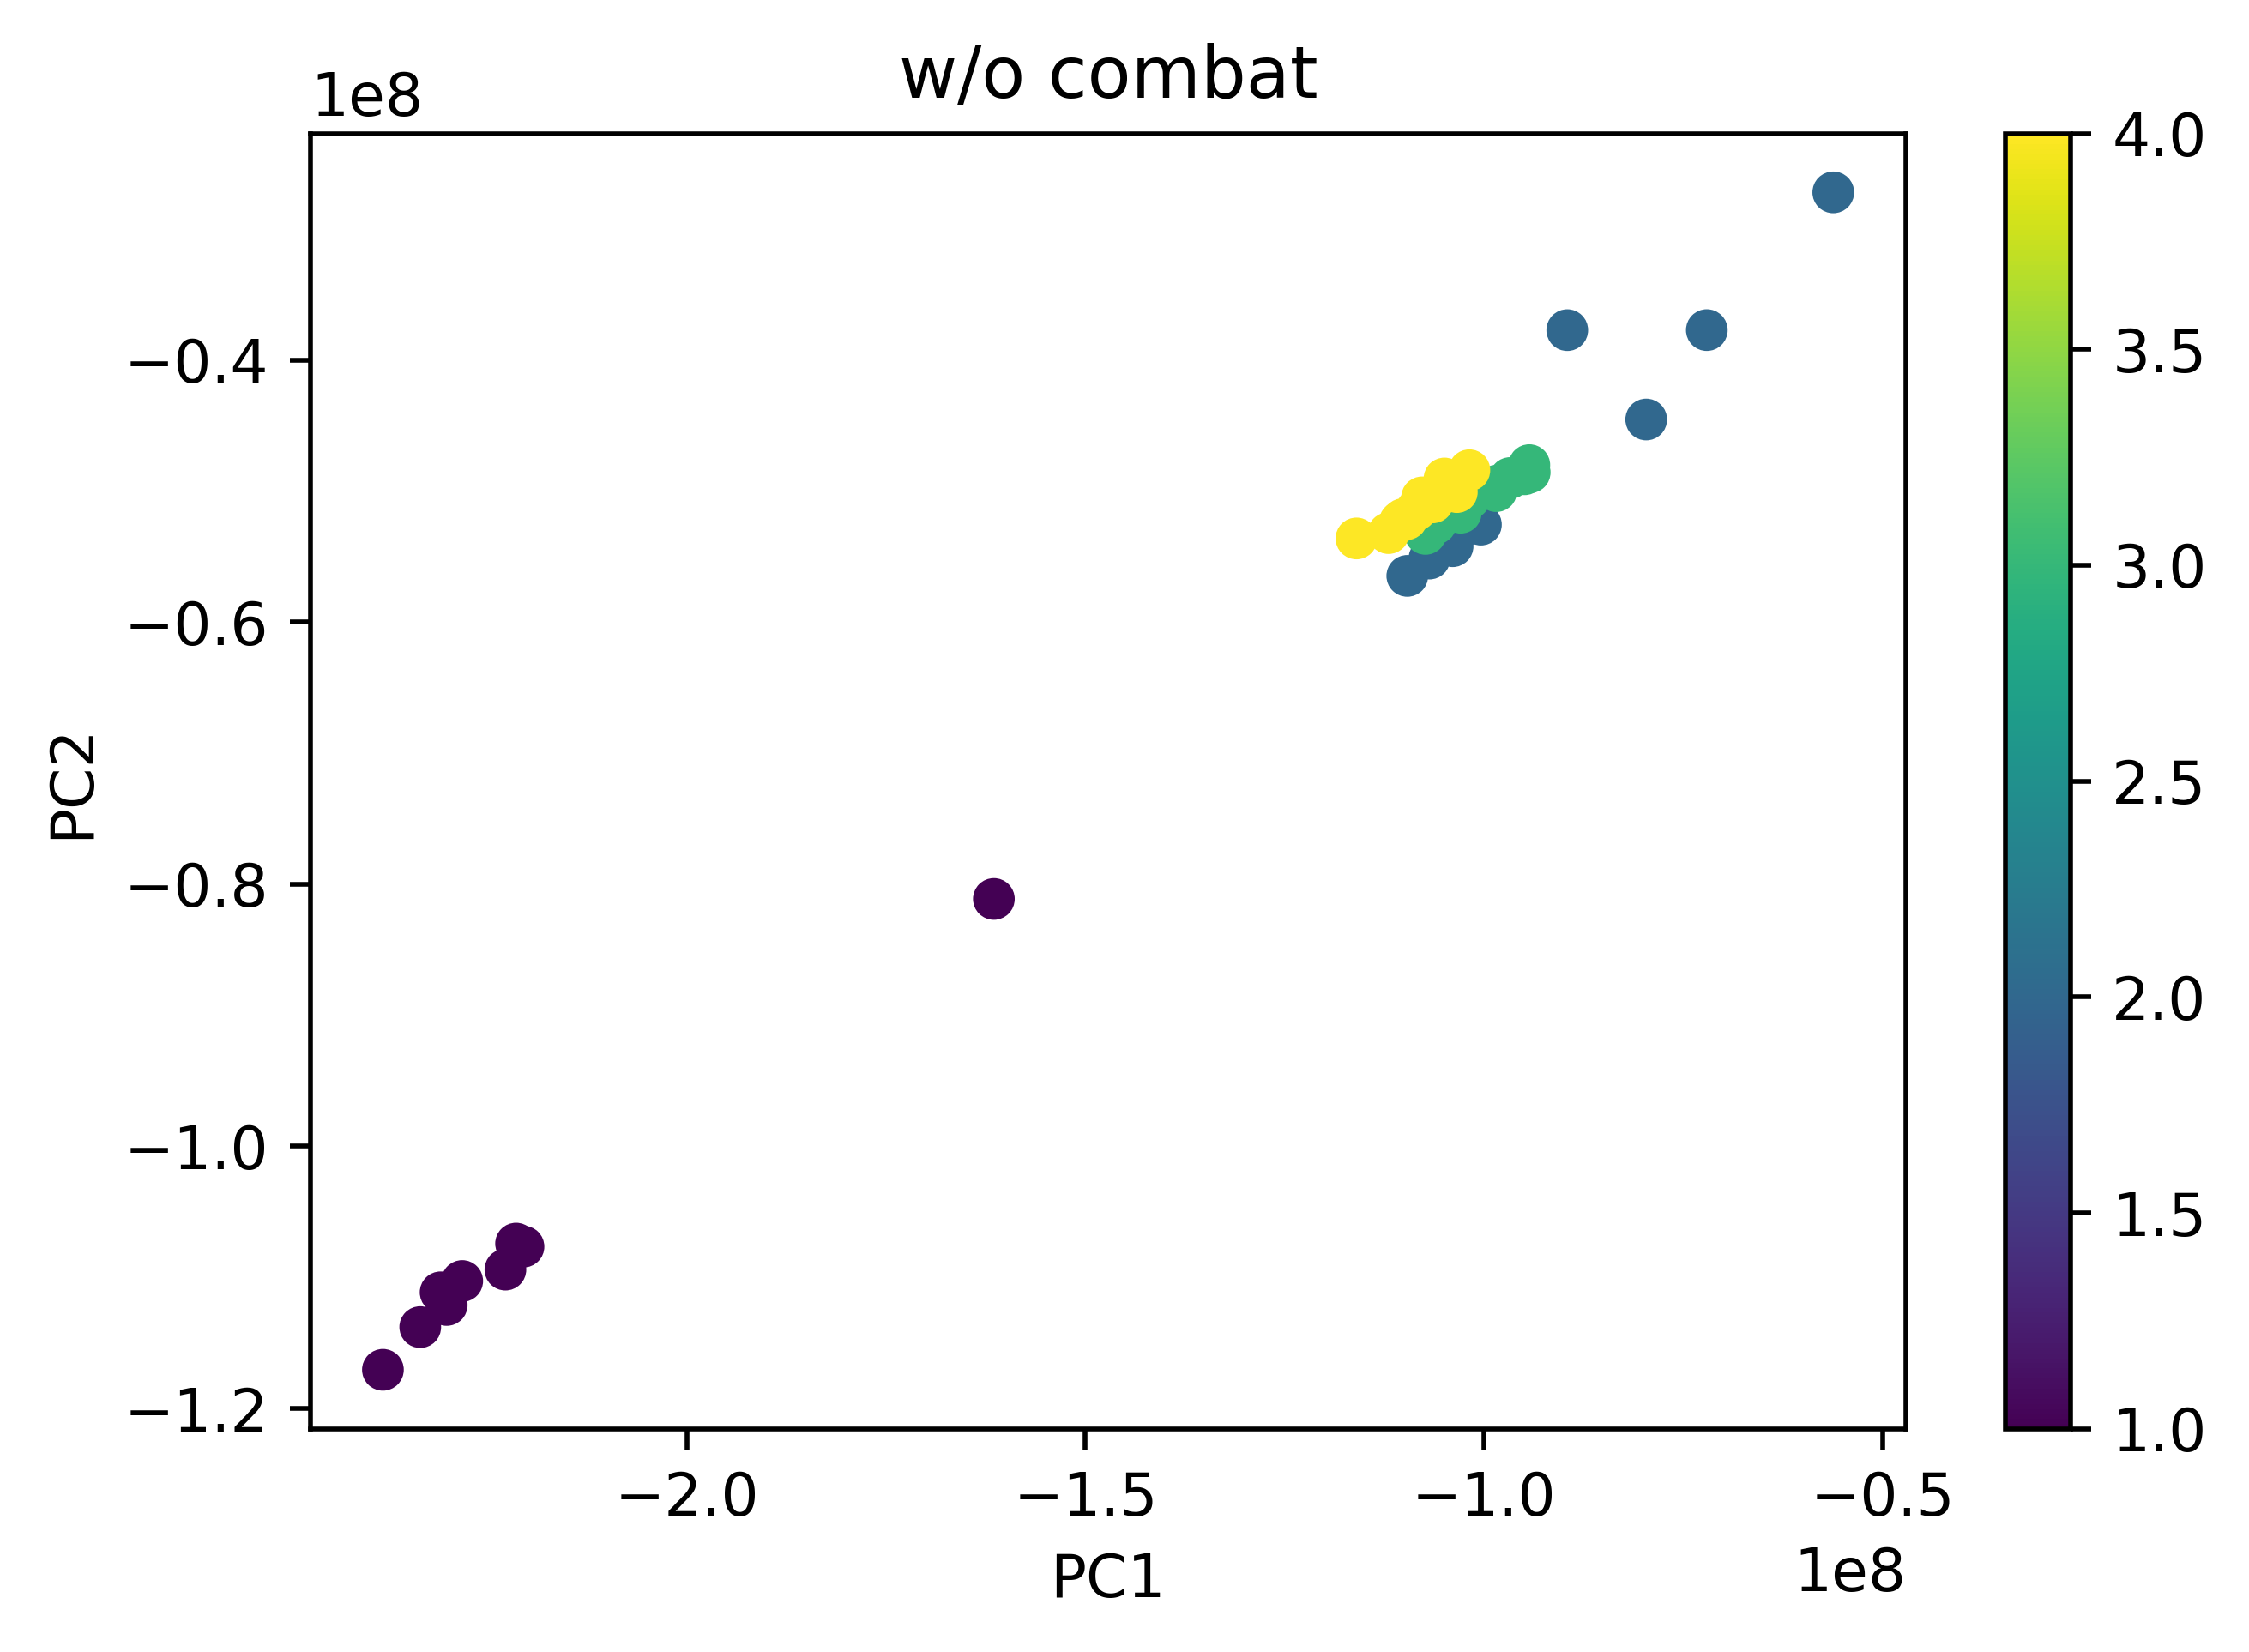

In [199]:
pca = PCA(n_components=2)
pca.fit(data_imp_norm)
qcSamp_reduced = pca.transform(qcData)
plt.scatter(qcSamp_reduced[:,0],qcSamp_reduced[:,1],c=[batchInfo[x] for x in qcSamp])
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("w/ combat")

plt.figure()
pca.fit(data_imp)
qcSamp_reduced = pca.transform(areaData.to_numpy()[qcSamp])
plt.scatter(qcSamp_reduced[:,0],qcSamp_reduced[:,1],c=[batchInfo[x] for x in qcSamp])
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("w/o combat")

In [200]:
# [qcSamp[x] for x in range(len(qcSamp)) if qcSamp_reduced[x][0] > 30]
# print(areaCols[47])

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


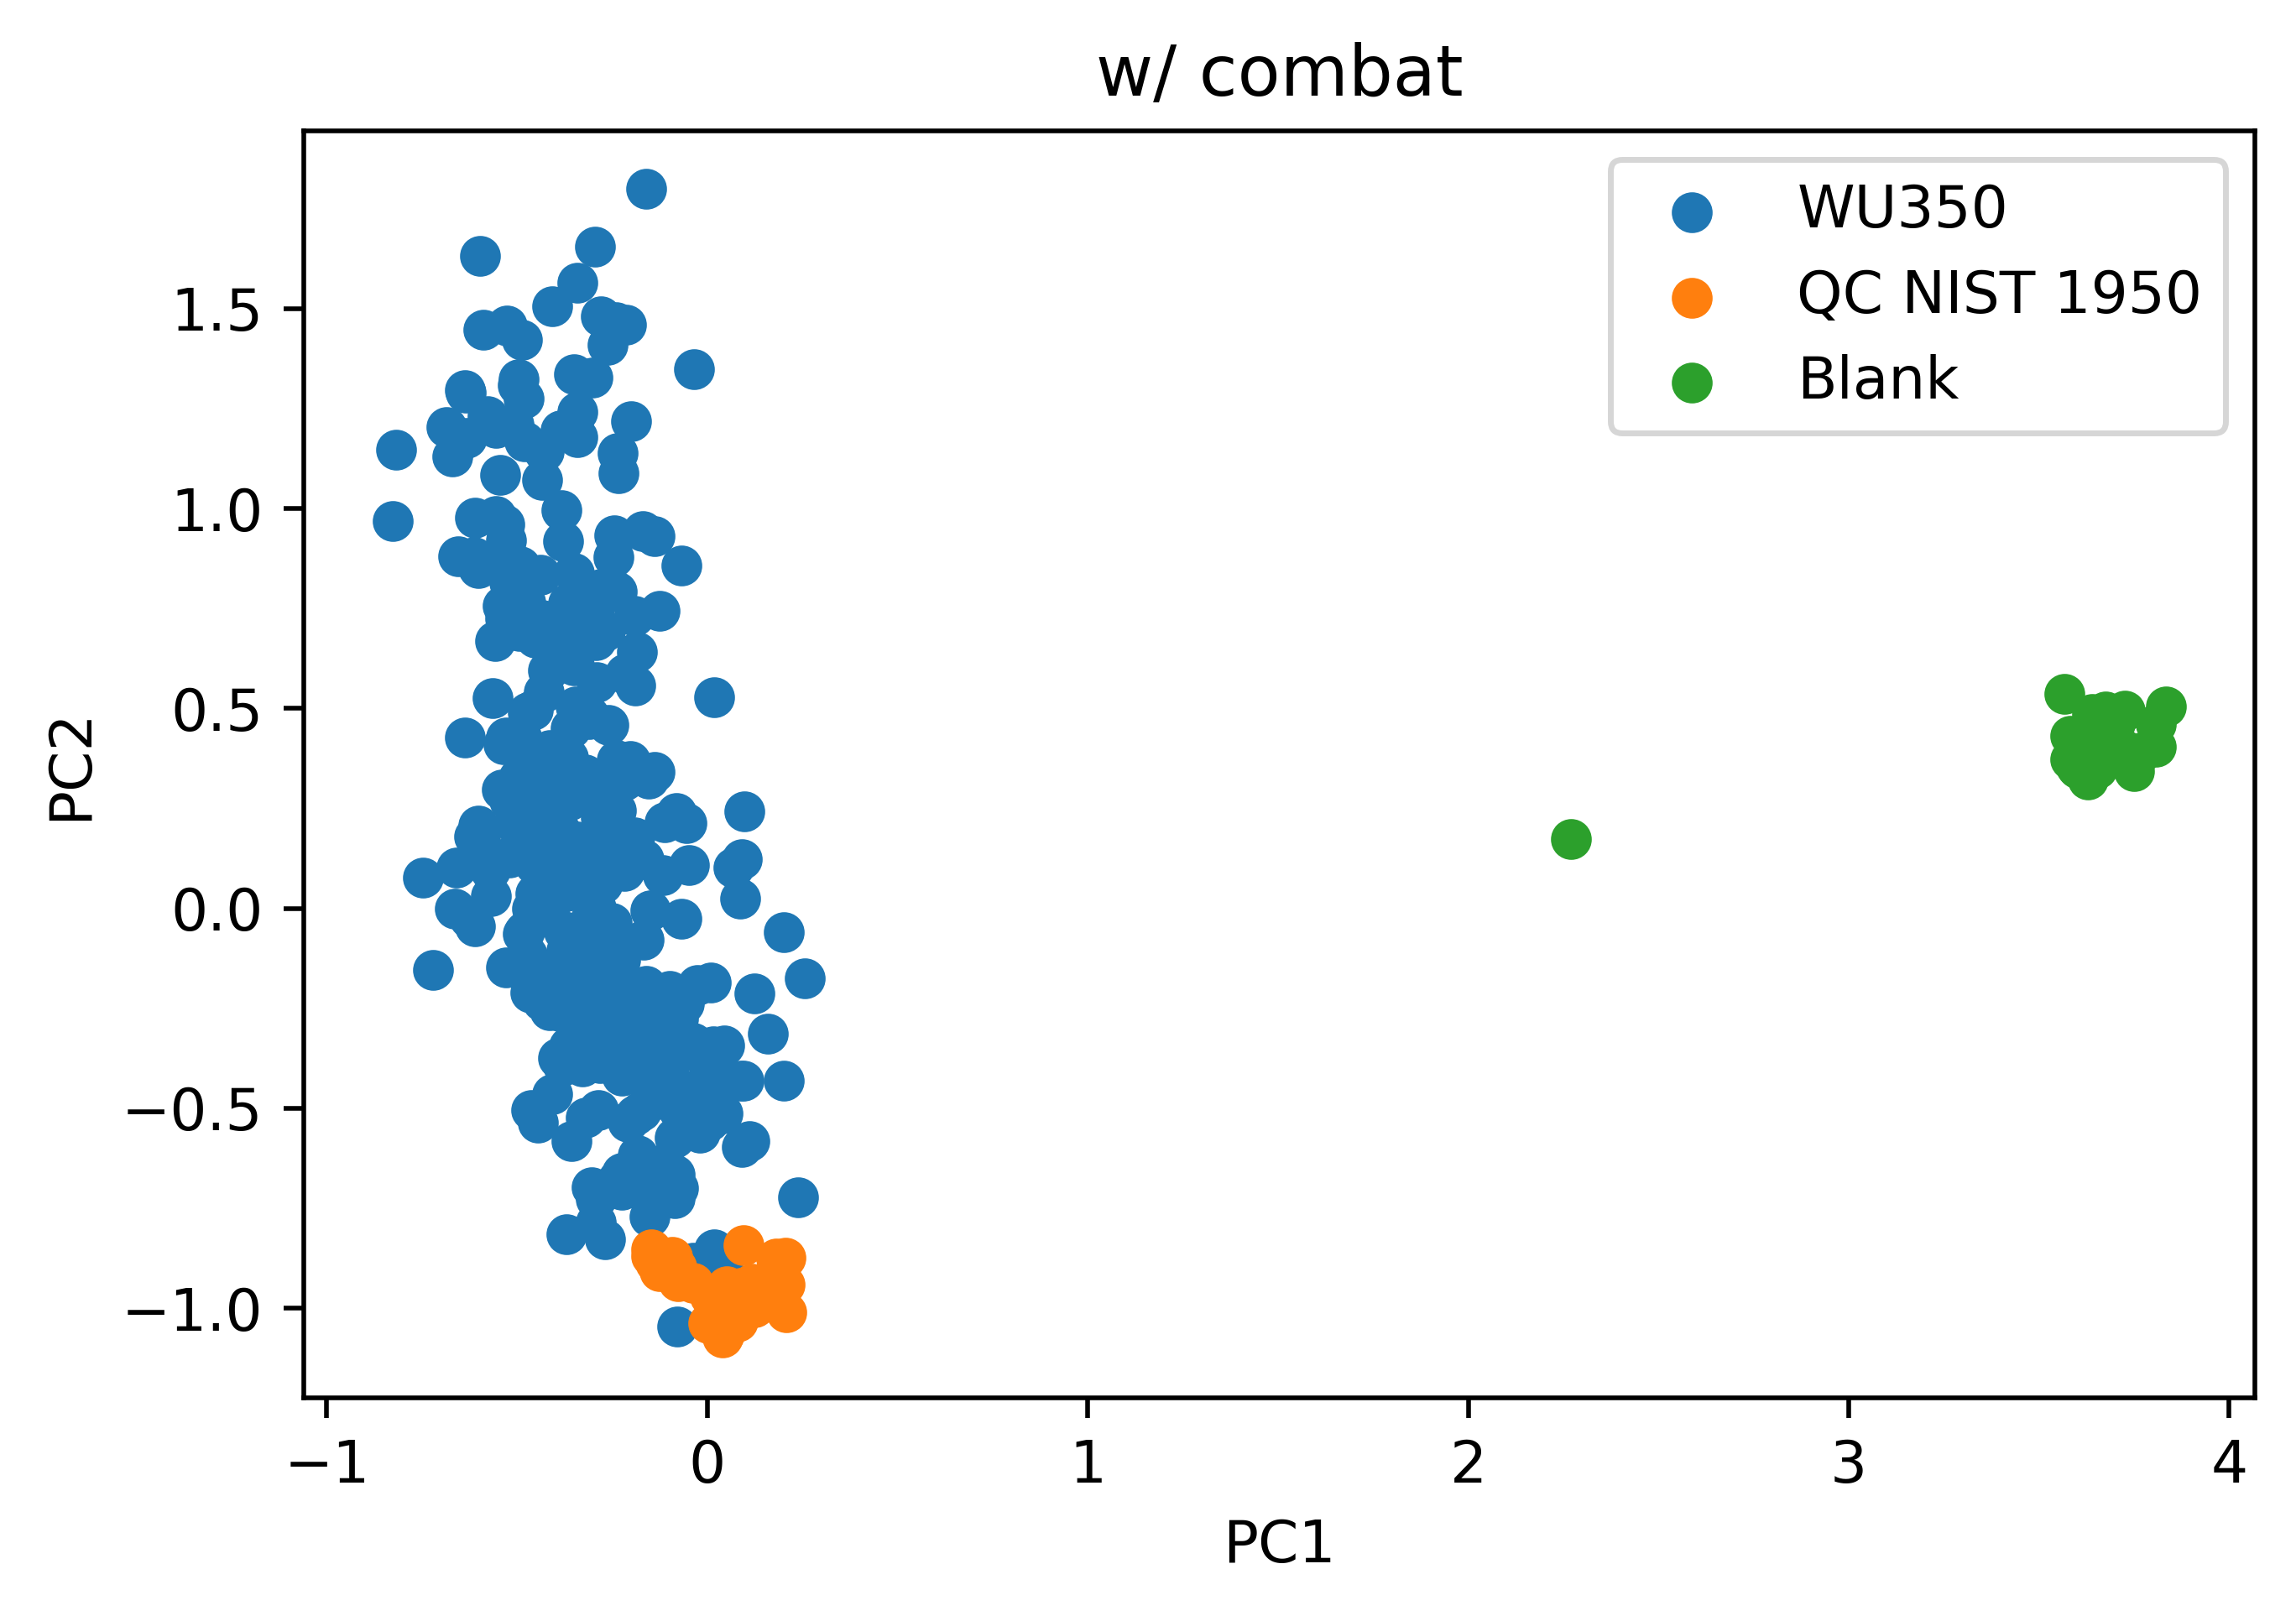

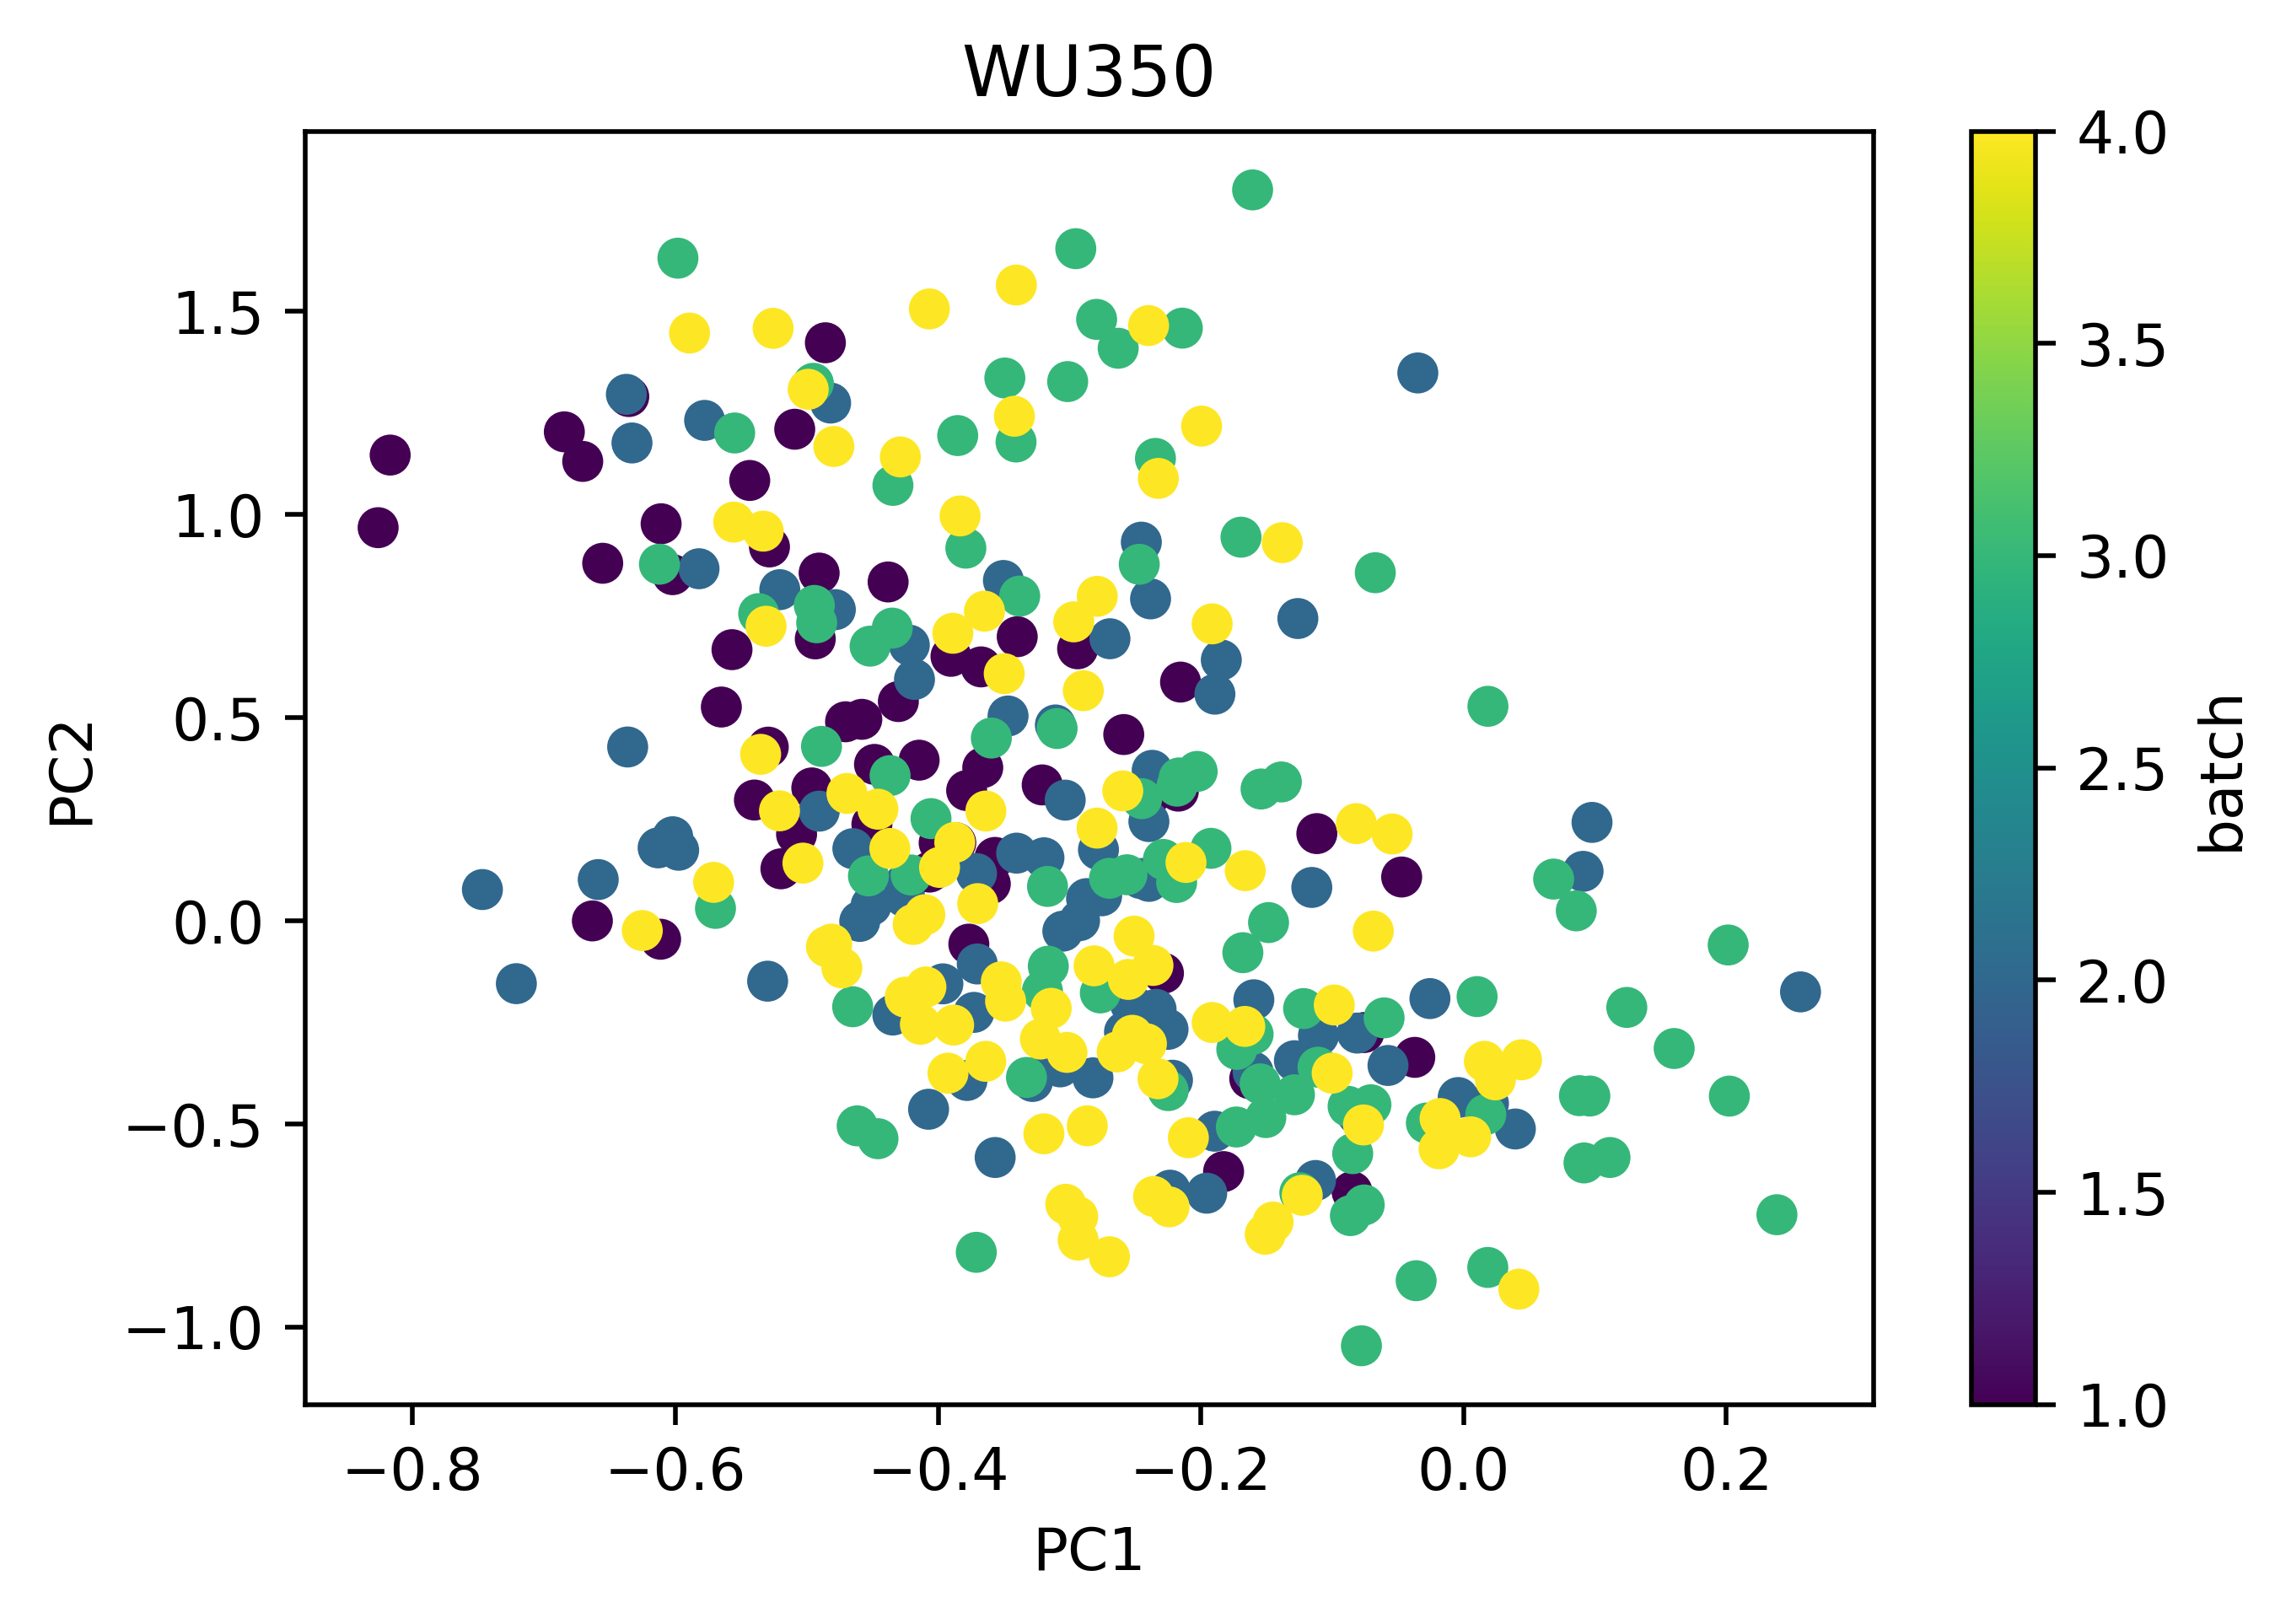

<Figure size 3000x2000 with 0 Axes>

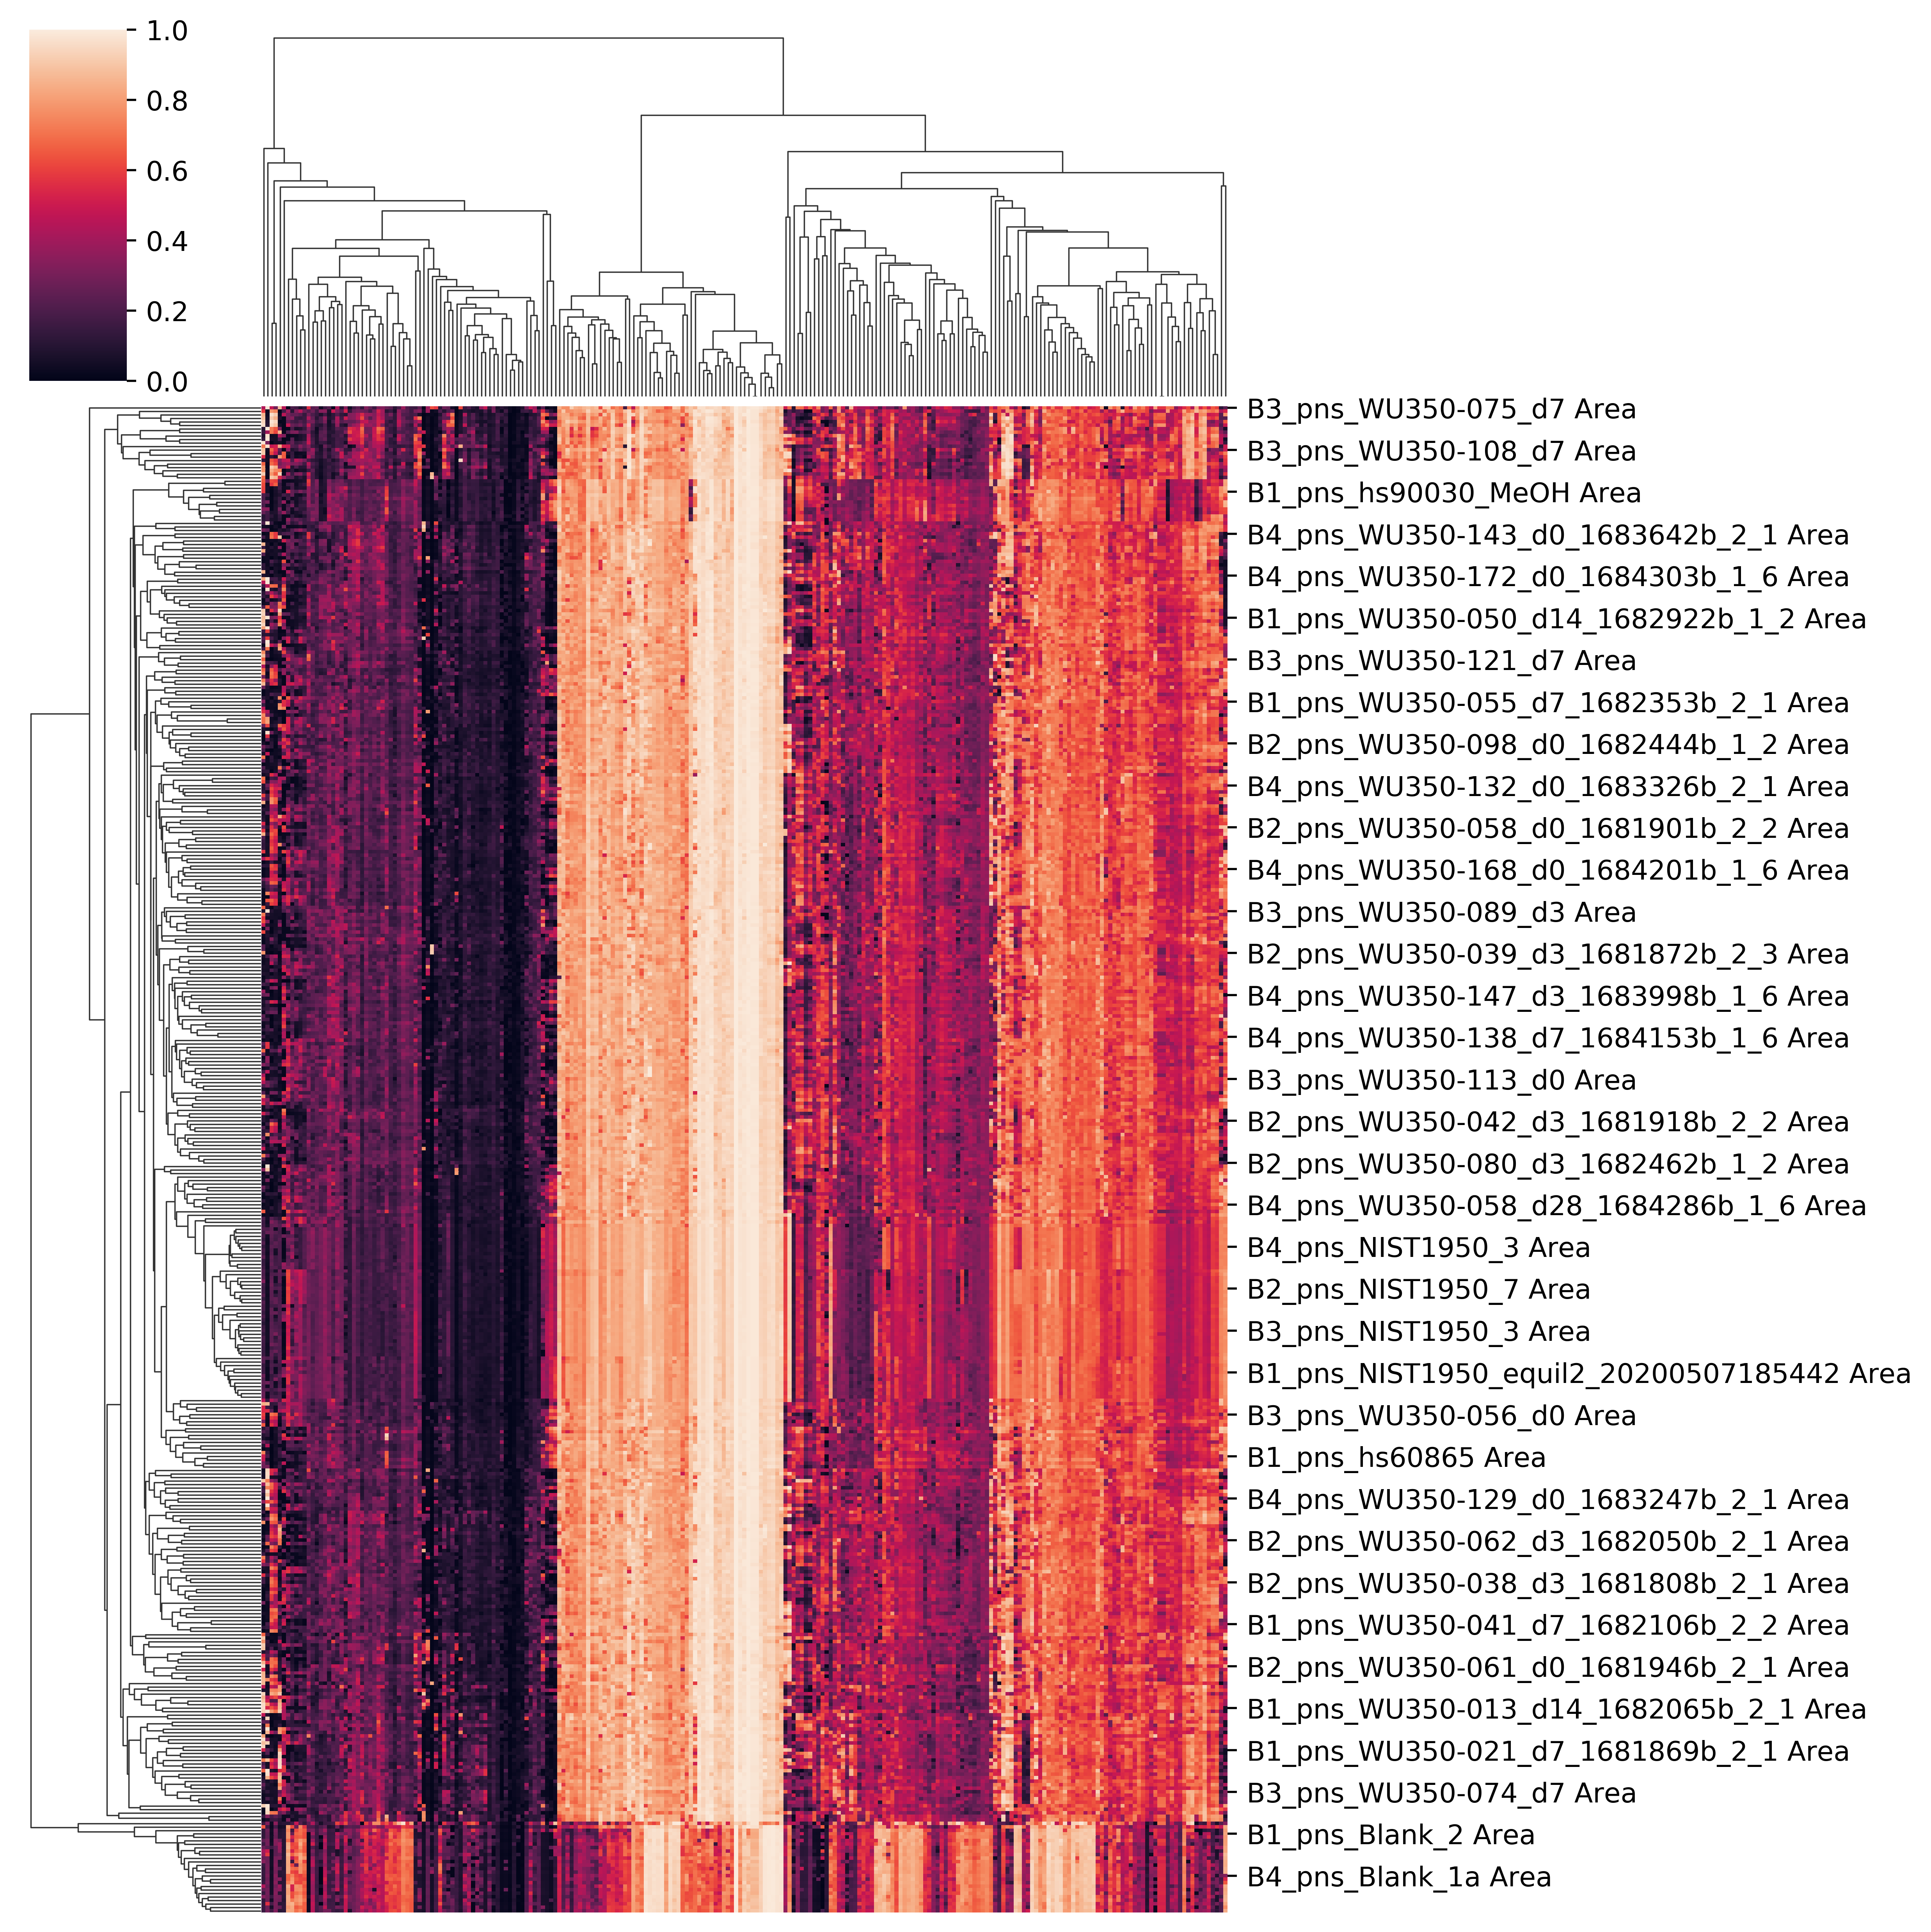

In [201]:
pca = PCA(n_components=2)
pca.fit(data_imp_norm)
data_reduced = pca.transform(data_imp_norm)
plt.scatter(data_reduced[sampCols,0],data_reduced[sampCols,1],label="WU350")
plt.scatter(data_reduced[qcSamp,0],data_reduced[qcSamp,1],label="QC NIST 1950")
plt.scatter(data_reduced[blankSamp,0],data_reduced[blankSamp,1],label="Blank")
plt.legend()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("w/ combat")

plt.figure()
plt.scatter(data_reduced[sampCols,0],data_reduced[sampCols,1],c=[batchInfo[x] for x in sampCols])
plt.colorbar(label="batch")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("WU350")

plt.figure()
sb.clustermap(pd.DataFrame(data=data_imp_norm,index=areaCols,columns=data["Molecule Name"].values),xticklabels=False)


In [202]:
metadata = pd.read_csv("experiment_parameters.csv")
samp2rowMap = {r.split()[0].replace("pns_","p"):i for r,i in zip(areaCols,range(len(areaCols)))}
row2Samp = {val:key for key,val in samp2rowMap.items()}
print(samp2rowMap)

{'B1_pBlank_1': 0, 'B1_pBlank_2': 1, 'B1_pBlank_3': 2, 'B1_pBlank_4': 3, 'B1_pBlank_5': 4, 'B1_pBlank_6': 5, 'B1_phs10000': 6, 'B1_phs10000_MeOH': 7, 'B1_phs10001': 8, 'B1_phs10001_MeOH': 9, 'B1_phs10002': 10, 'B1_phs10002_MeOH': 11, 'B1_phs60416': 12, 'B1_phs60416_MeOH': 13, 'B1_phs60860': 14, 'B1_phs60860_MeOH': 15, 'B1_phs60861': 16, 'B1_phs60861_MeOH': 17, 'B1_phs60862': 18, 'B1_phs60862_MeOH': 19, 'B1_phs60864': 20, 'B1_phs60864_MeOH': 21, 'B1_phs60865': 22, 'B1_phs60865_MeOH': 23, 'B1_phs60866': 24, 'B1_phs60866_MeOH': 25, 'B1_phs60867': 26, 'B1_phs60867_MeOH': 27, 'B1_phs60868': 28, 'B1_phs60868_MeOH': 29, 'B1_phs90001': 30, 'B1_phs90001_MeOH': 31, 'B1_phs90030': 32, 'B1_phs90030_MeOH': 33, 'B1_pLLFS-stab_participant-1_24': 34, 'B1_pLLFS-stab_participant-2_24': 35, 'B1_pLLFS-stab_participant-3_24': 36, 'B1_pNIST1950_0': 37, 'B1_pNIST1950_1': 38, 'B1_pNIST1950_2': 39, 'B1_pNIST1950_3': 40, 'B1_pNIST1950_4': 41, 'B1_pNIST1950_5': 42, 'B1_pNIST1950_6': 43, 'B1_pNIST1950_7': 44, 'B1

Text(0, 0.5, 'PC2')

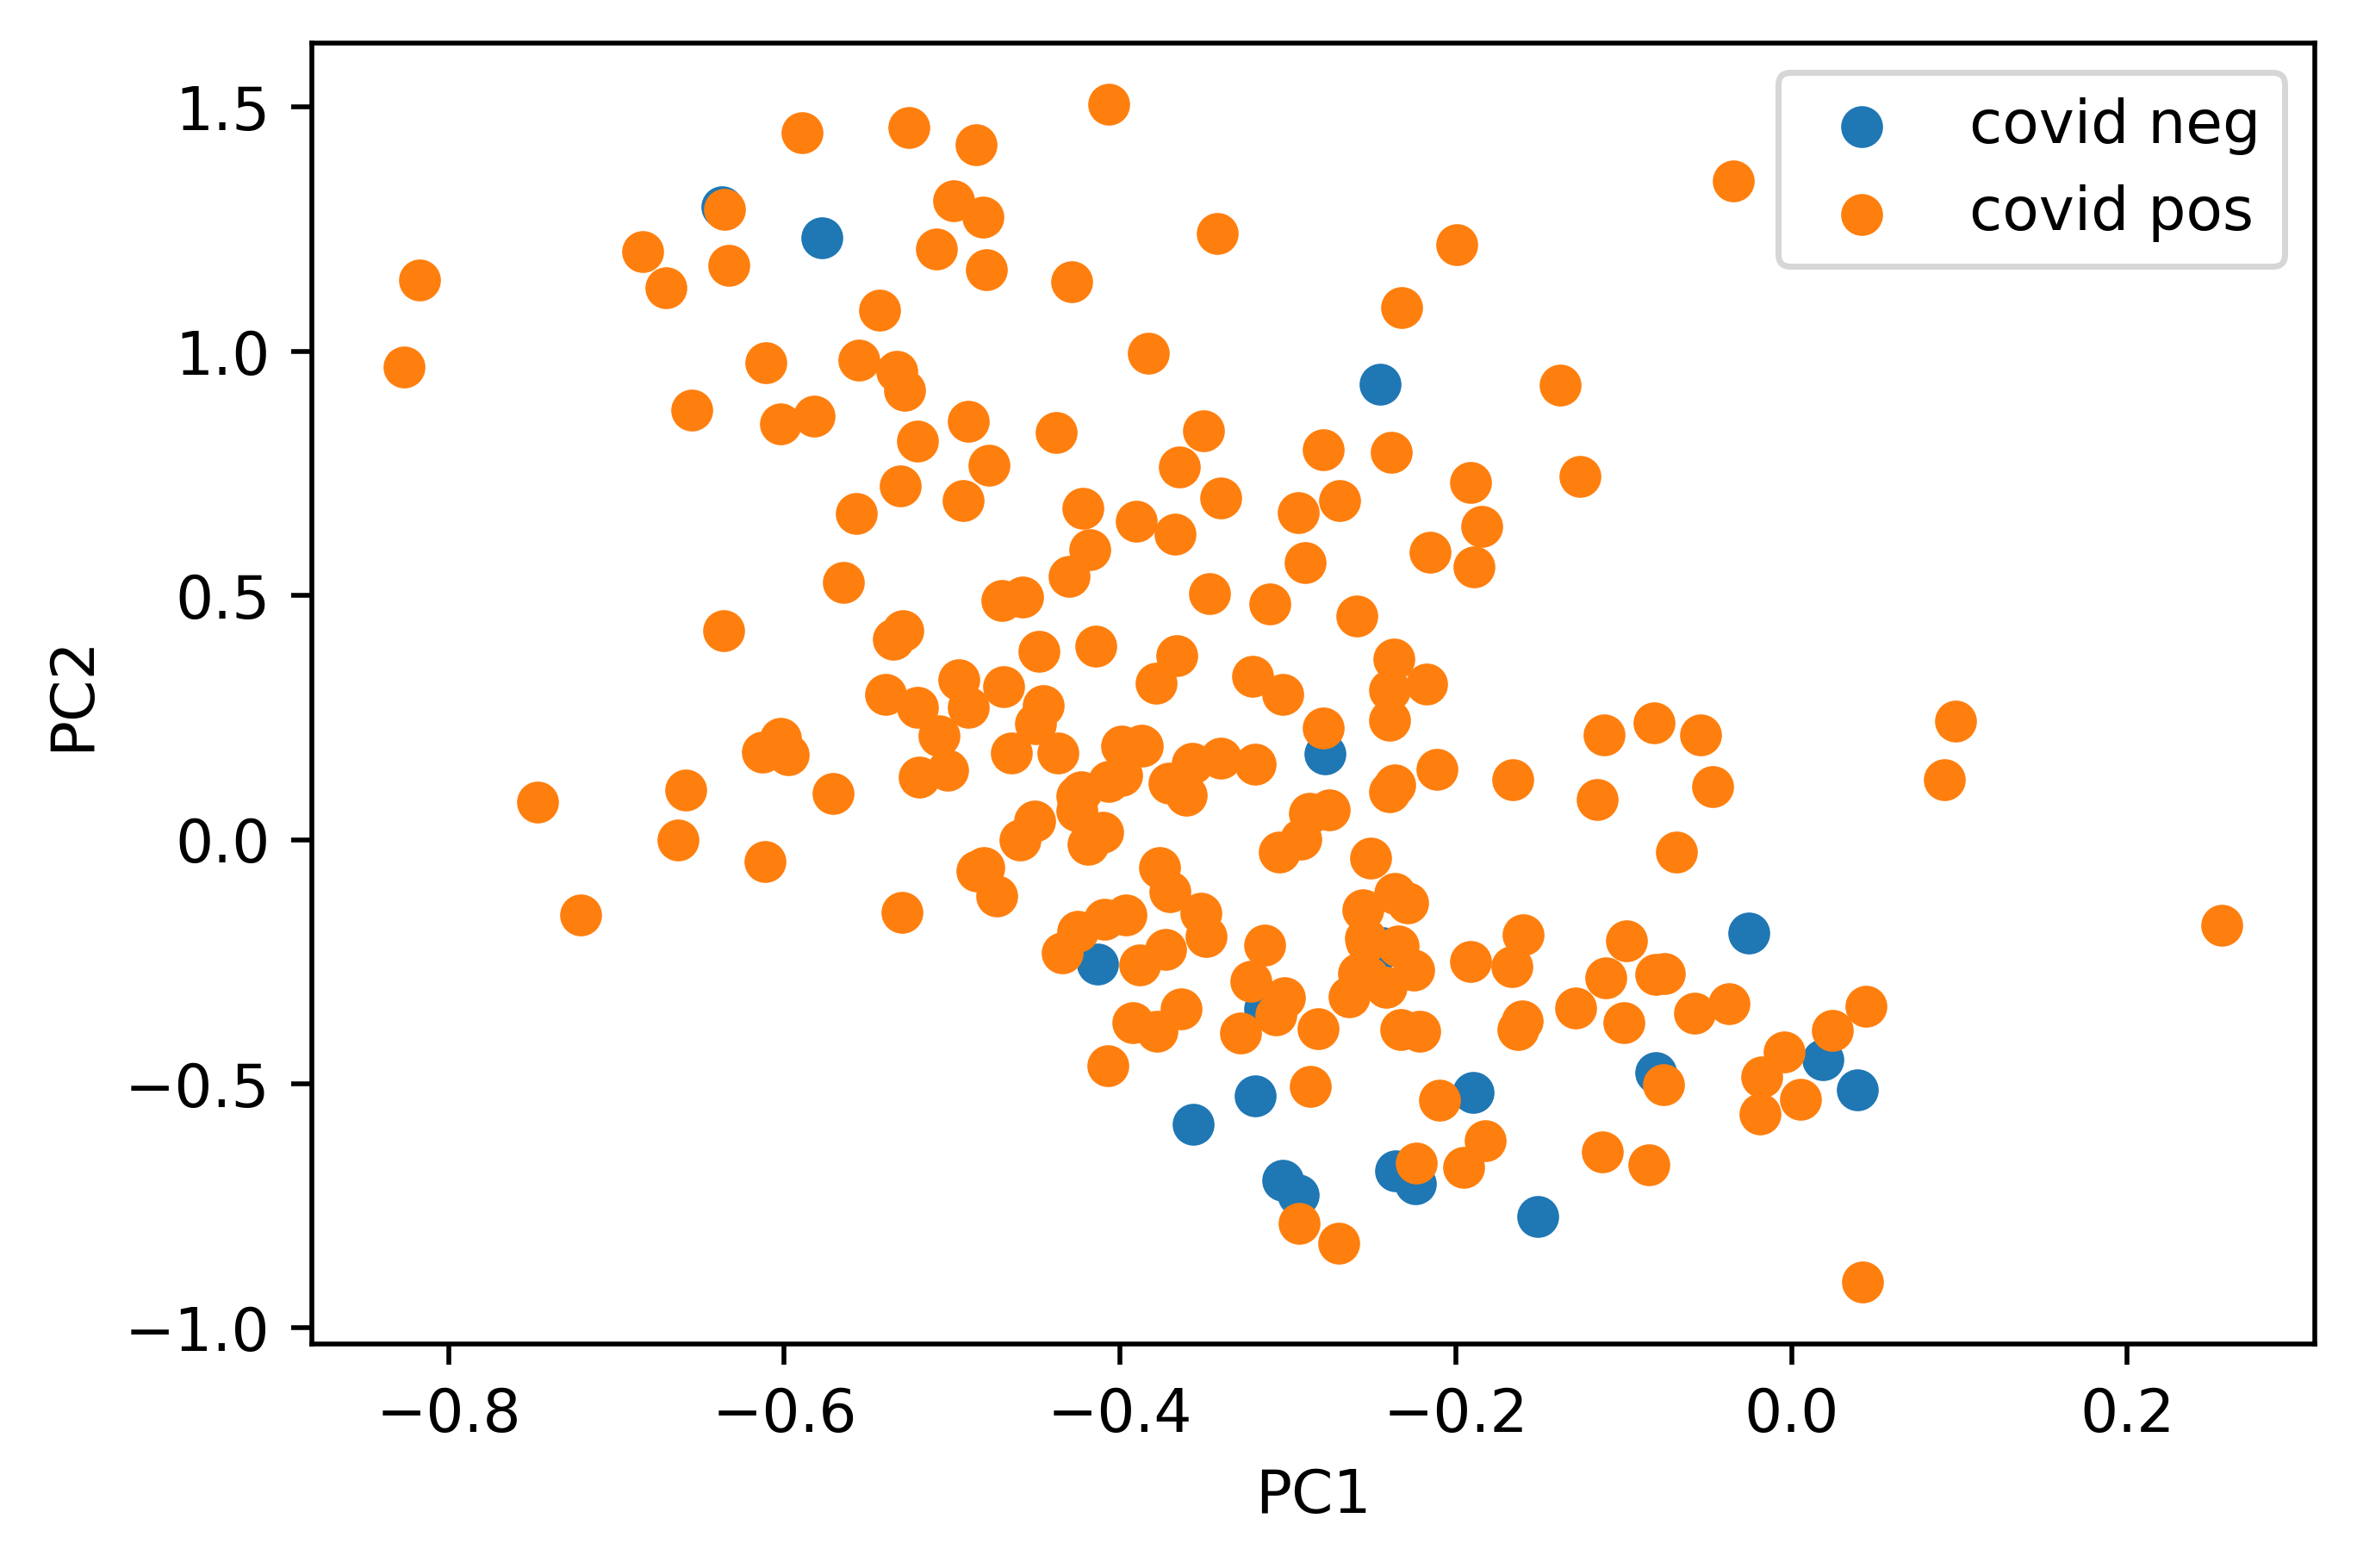

In [203]:
covid_initial_status_neg = [samp2rowMap[row["Sample"]] for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "No" in str(row["day-COVID"])]
covid_initial_status_pos = [samp2rowMap[row["Sample"]] for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "Yes" in str(row["day-COVID"])]

plt.scatter(data_reduced[covid_initial_status_neg,0],data_reduced[covid_initial_status_neg,1],label="covid neg")
plt.scatter(data_reduced[covid_initial_status_pos,0],data_reduced[covid_initial_status_pos,1],label="covid pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


In [204]:
numMets = len(blankData[0])
        
pvalCutoff = 0.05
pvals = []
for met in range(numMets):
    b = blankData[:,met]
    s = sampData[:,met]
    t,p = stats.ttest_ind(b,s,equal_var=False)
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pvalCutoff,method="fdr_bh")
goodMets = [x for x in range(len(reject)) if reject[x]]

19
training error:  0.1643192488262911
[[ 11   0]
 [ 35 167]]
testing error:  0.19811320754716982
[[ 4  4]
 [17 81]]


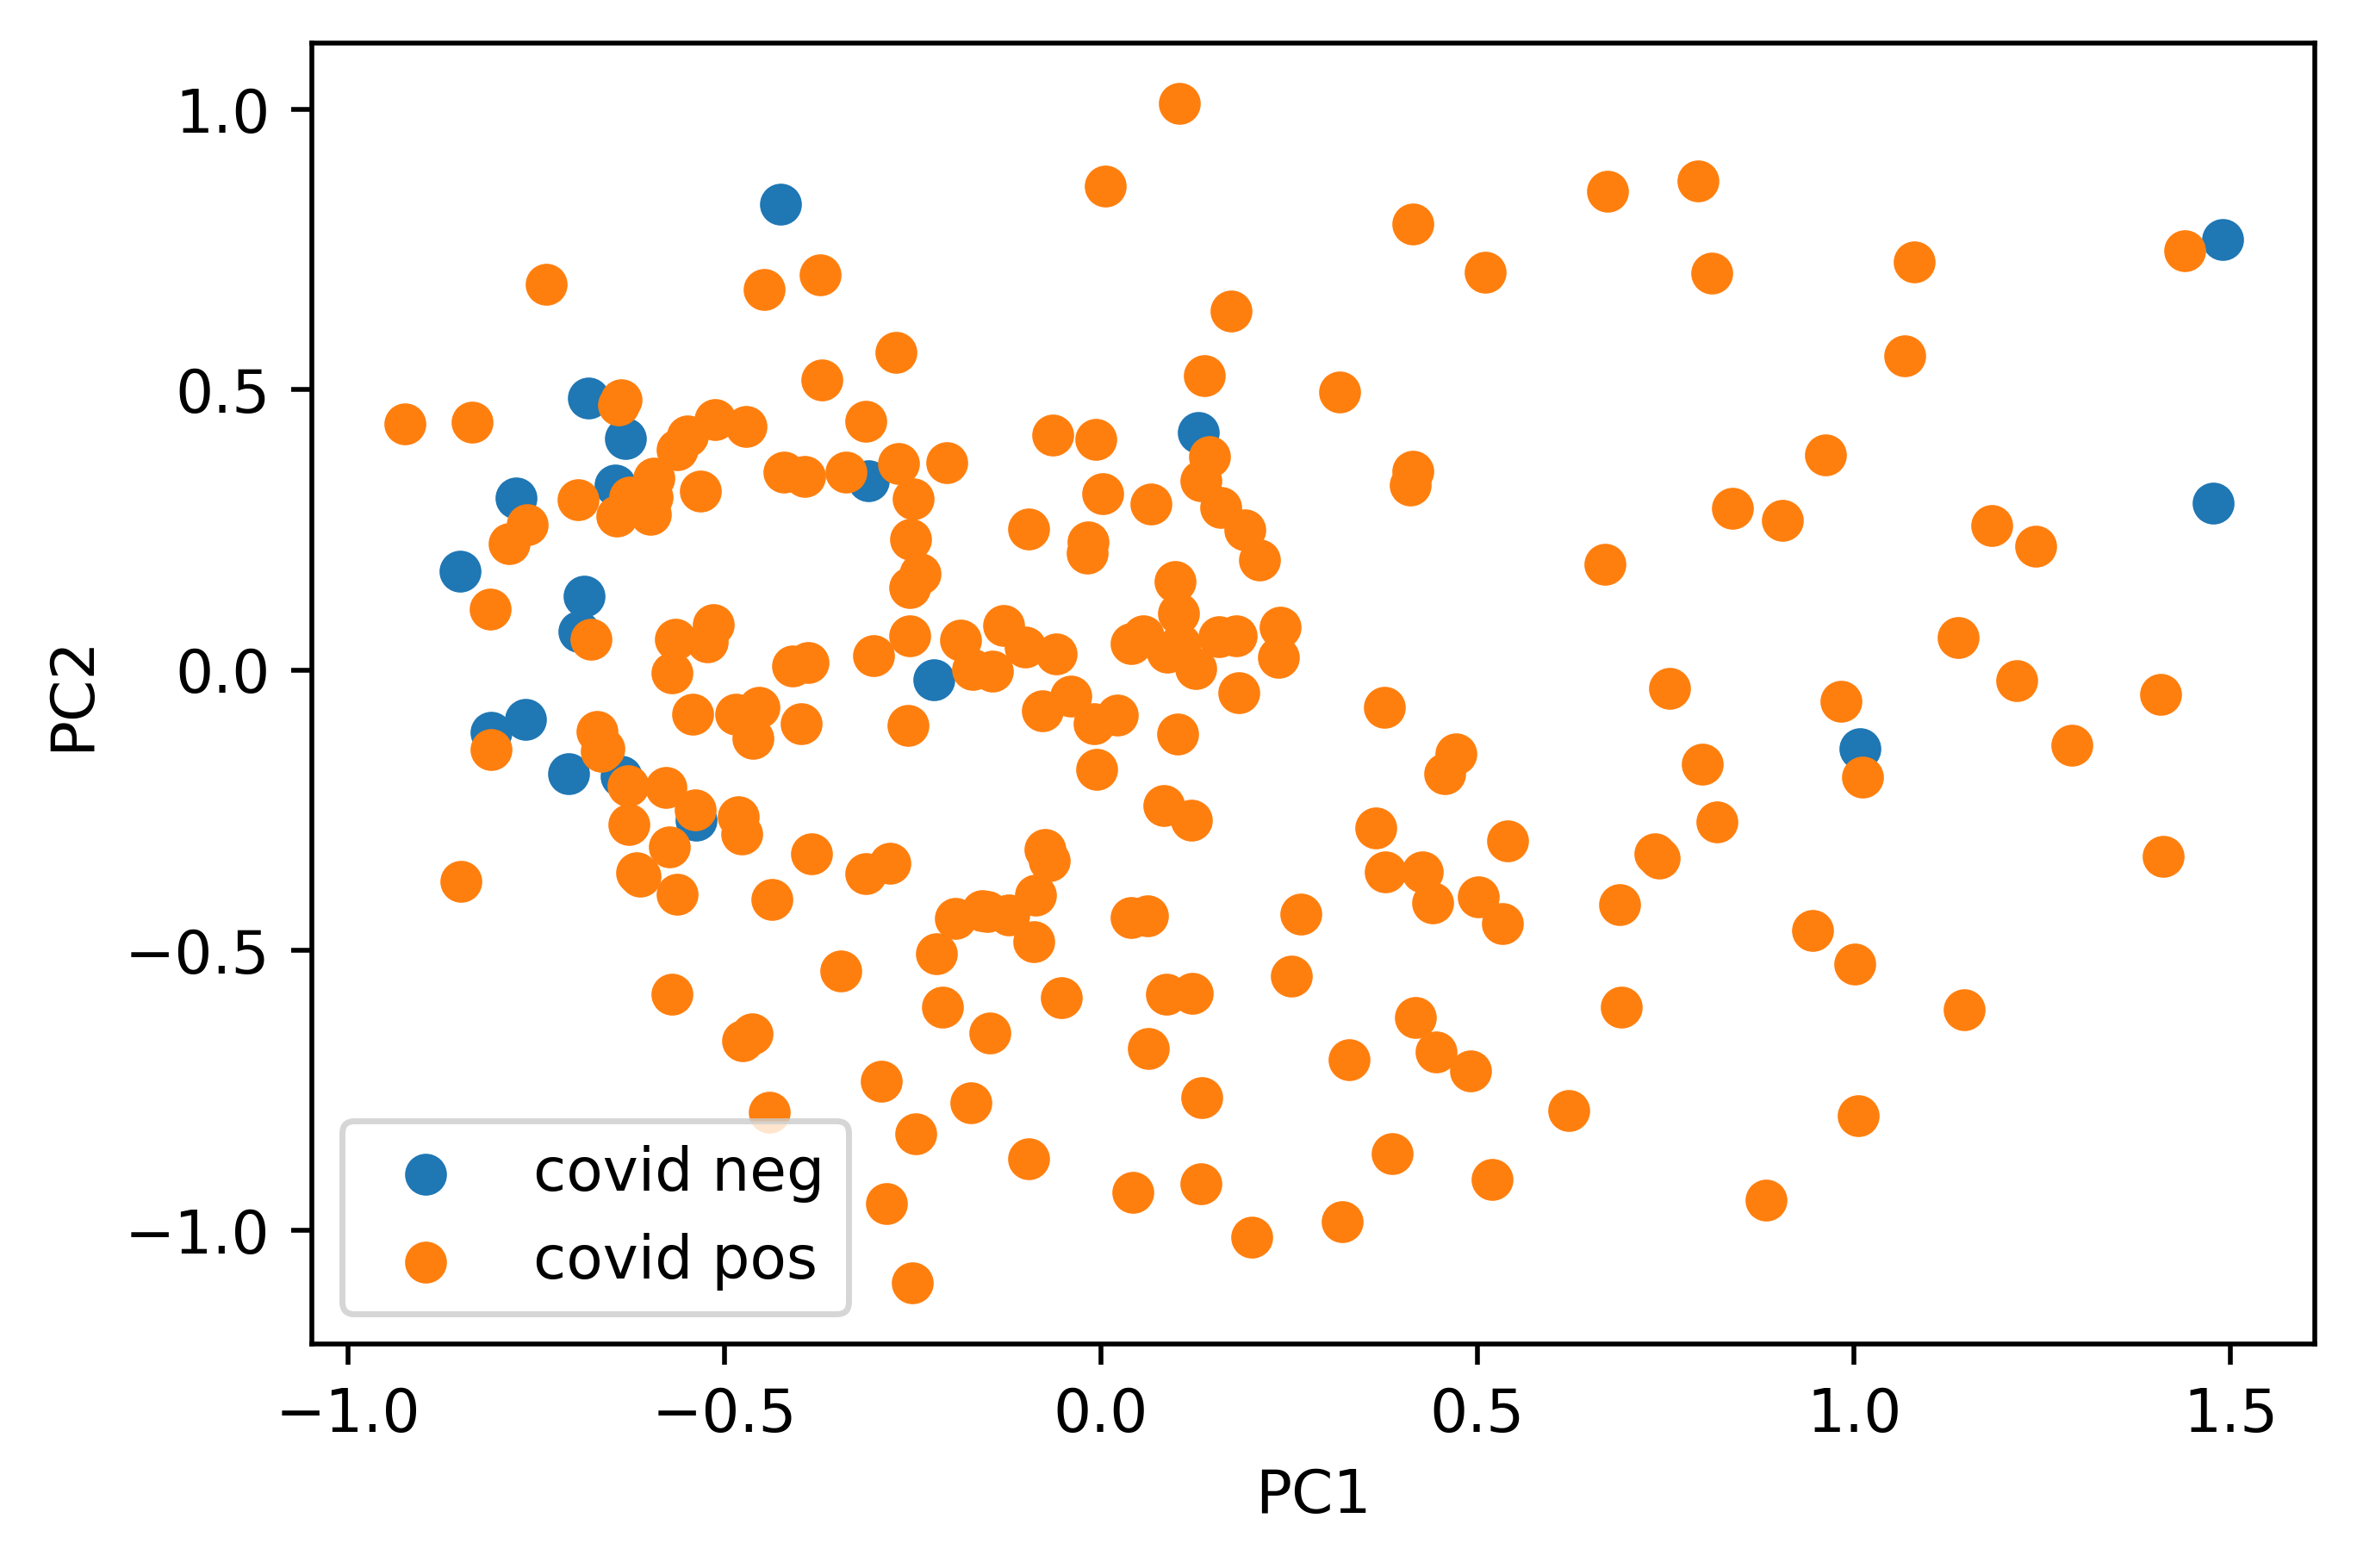

<Figure size 3000x2000 with 0 Axes>

In [205]:
sampData_sig = sampData[:,goodMets]
pca = PCA(n_components=2)
pca.fit(sampData_sig)
data_reduced = pca.transform(sampData_sig)

covid_initial_status_neg = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "No" in str(row["day-COVID"])]
covid_initial_status_pos = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "Yes" in str(row["day-COVID"])]

print(len(covid_initial_status_neg))
covid_status = [1 for x in range(len(sampData_sig))]
for ind in covid_initial_status_neg:
    covid_status[ind] = -1

plt.scatter(data_reduced[covid_initial_status_neg,0],data_reduced[covid_initial_status_neg,1],label="covid neg")
plt.scatter(data_reduced[covid_initial_status_pos,0],data_reduced[covid_initial_status_pos,1],label="covid pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.figure()

sampData_sig = np.concatenate((sampData_sig,np.ones((len(sampData_sig),1))),axis=1)
X_train,X_test,y_train,y_test = train_test_split(sampData_sig,covid_status,random_state=0,test_size=.33)
weightNeg = .5/len([y for y in y_train if y == -1])
weightPos = .5/len([y for y in y_train if y == 1])
sampleWeights = [weightNeg for x in y_train]
for x in range(len(y_train)):
    if y_train[x] == 1:
        sampleWeights[x] = weightPos
        

reg = LogisticRegression(fit_intercept=False,max_iter=1e3)
reg.fit(X_train,y_train,sample_weight=sampleWeights)
y_train_pred = reg.predict(X_train)
err_train = float(len([t for p,t in zip(y_train_pred,y_train) if p != t]))/len(y_train)
print("training error: ",err_train)
cnf_matrix = sklearn.metrics.confusion_matrix(y_train,y_train_pred)
print(cnf_matrix)
y_test_pred = reg.predict(X_test)
err_test = float(len([t for p,t in zip(y_test_pred,y_test) if p != t]))/len(y_test)
print("testing error: ",err_test)
cnf_matrix = sklearn.metrics.confusion_matrix(y_test,y_test_pred)
print(cnf_matrix)

25


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:333: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
c:\use

Text(0, 0.5, 'log2(peakArea)')

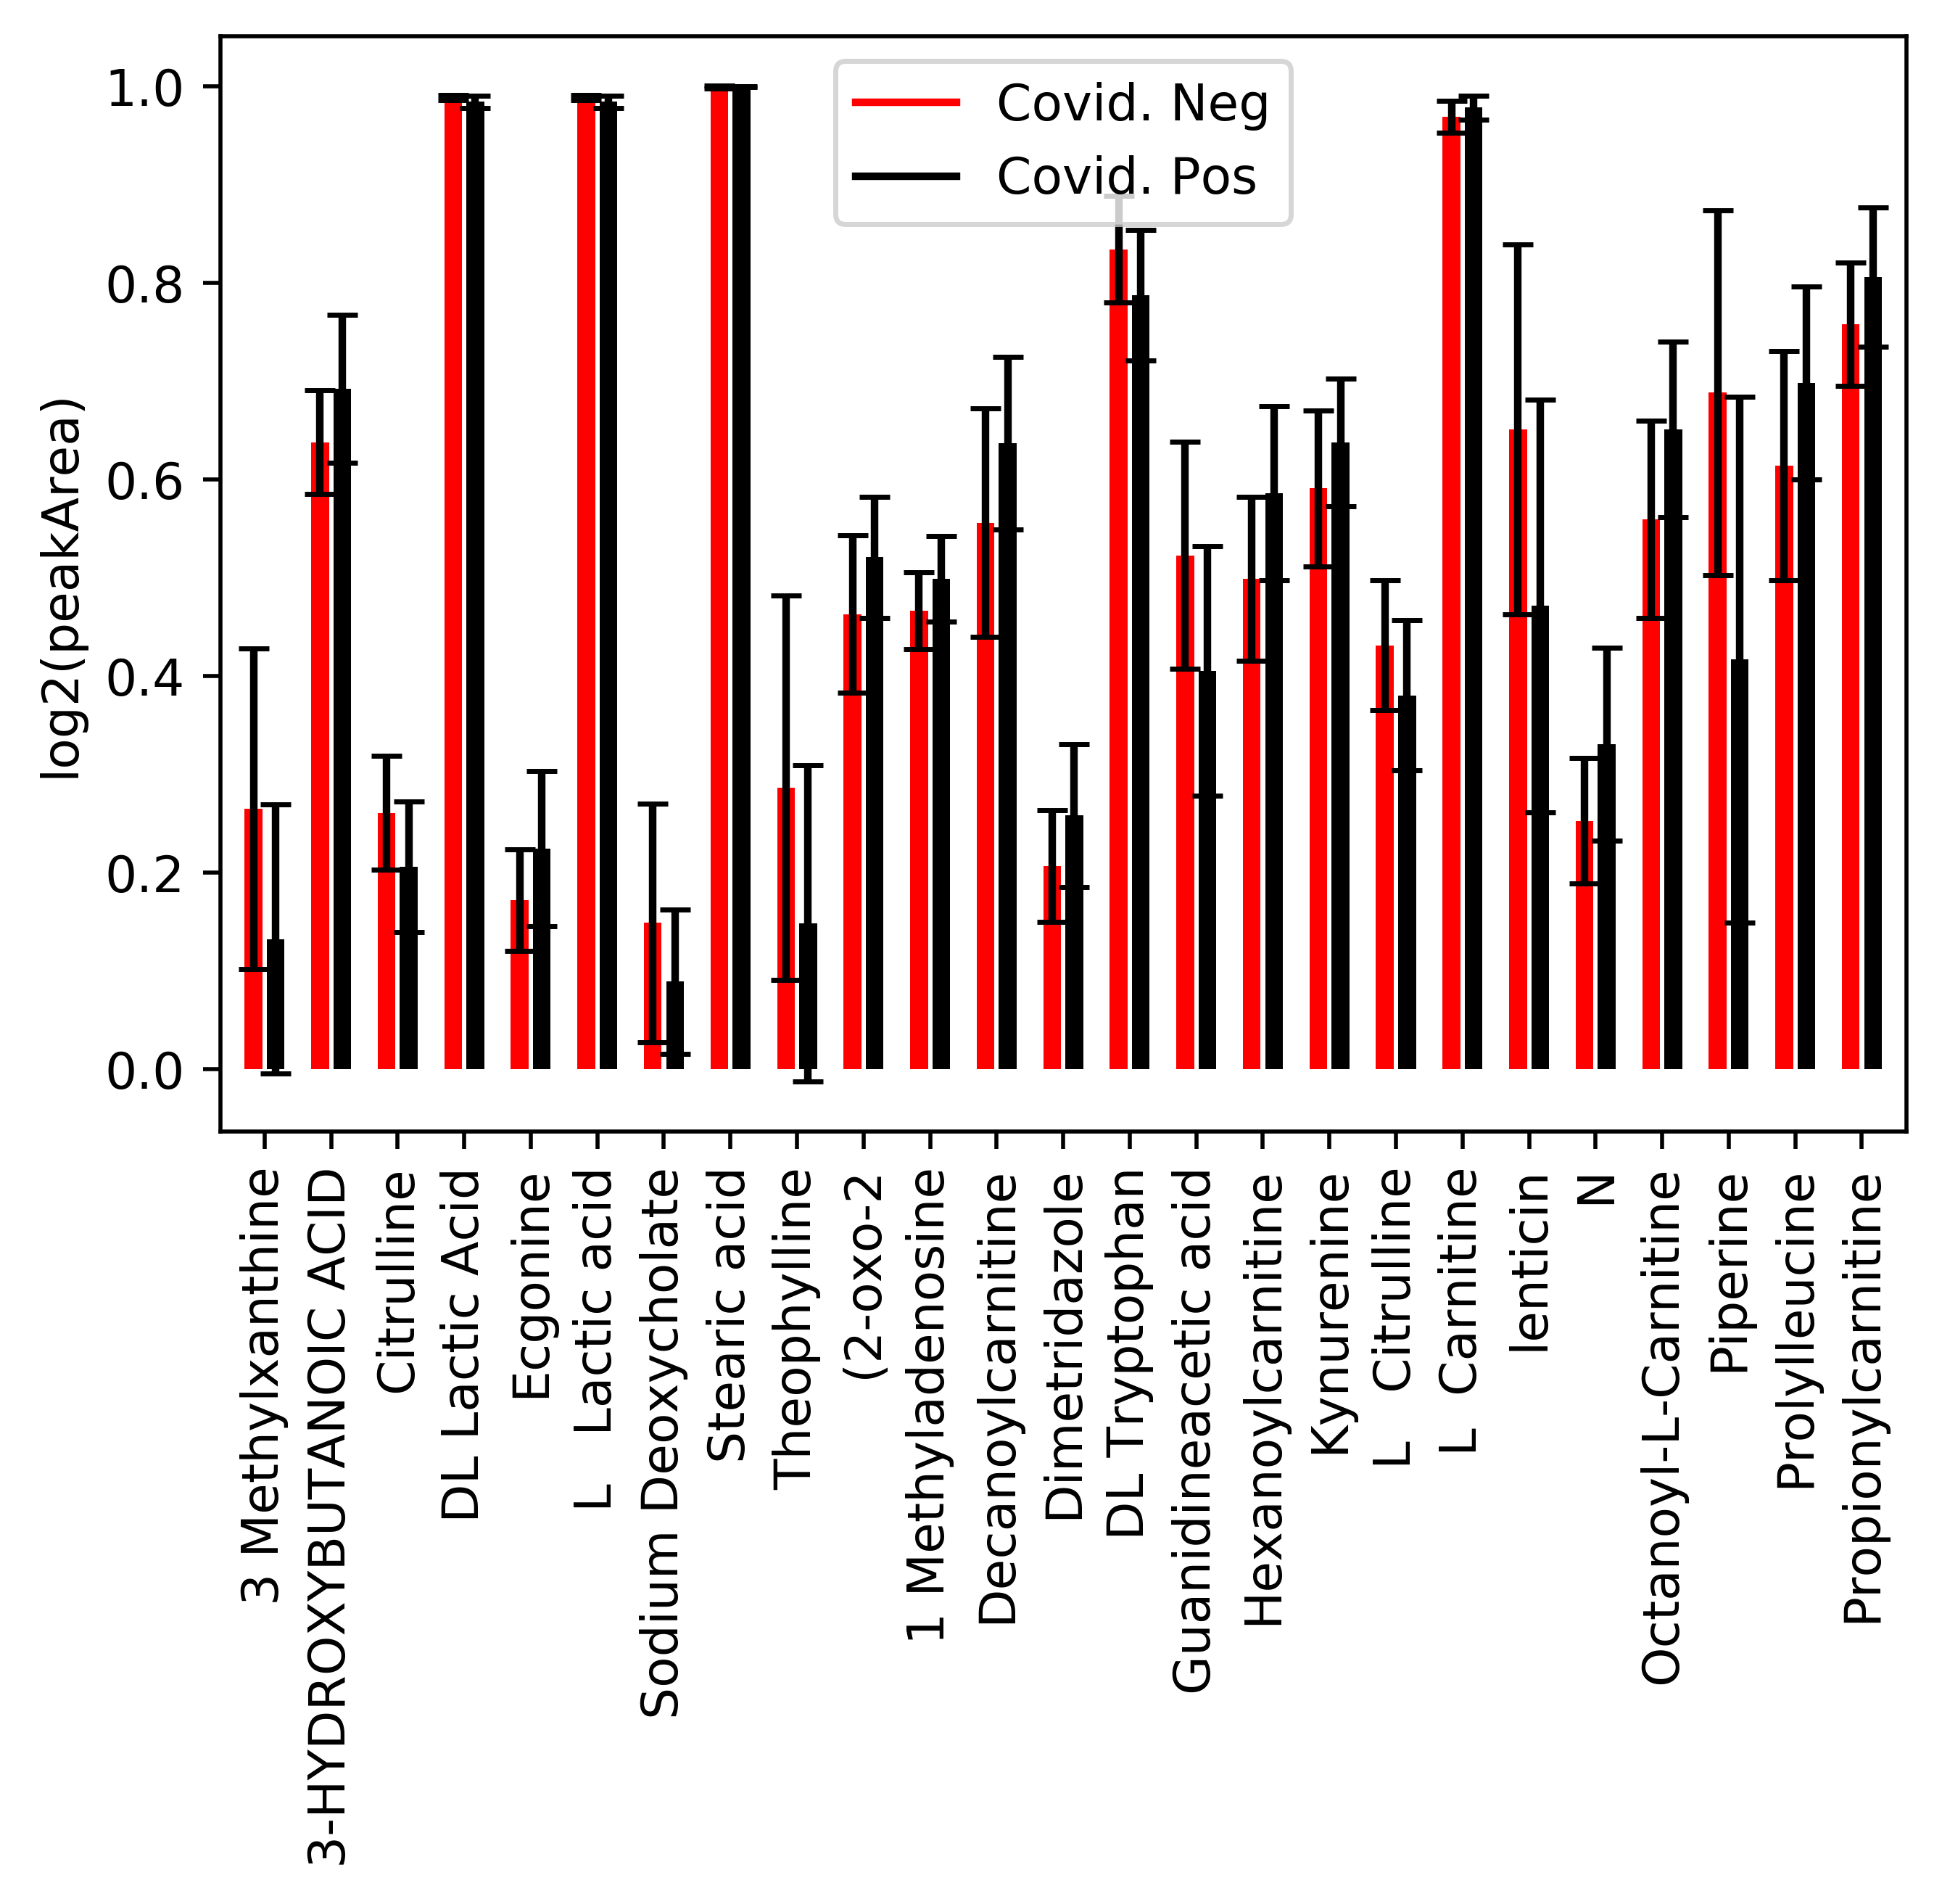

In [206]:
covidNeg = sampData_sig[covid_initial_status_neg,:]
covidPos = sampData_sig[covid_initial_status_pos,:]

pval = 0.05
fc = 2.0

sigMet = []
pvals = []
for met in range(len(covidNeg[0])):
    stat,p = stats.ttest_ind(covidNeg[:,met],covidPos[:,met])
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pval,method="fdr_bh")
sigMet = [x for x in range(len(reject)) if reject[x]]
print(len(sigMet))
    
xpos = 0
poses = []
labels = []
for met in sigMet:
    metName = data.at[data.index.values[goodMets[met]],"Molecule Name"].split("_")[1]
    plt.bar([xpos,xpos+1],[np.mean(covidNeg[:,met]),np.mean(covidPos[:,met])],yerr=[np.std(covidNeg[:,met]),np.std(covidPos[:,met])],color=["red","black"],capsize=3)
    poses.append(xpos+.5)
    labels.append(metName)
    xpos += 3
plt.plot([-10,-10],[0,1],color="red",label="Covid. Neg")
plt.plot([-10,-10],[0,1],color="black",label="Covid. Pos")

plt.xticks(poses,labels=labels,rotation = 90)
plt.xlim((min(poses)-2,max(poses)+2))
plt.legend()
plt.ylabel("log2(peakArea)")

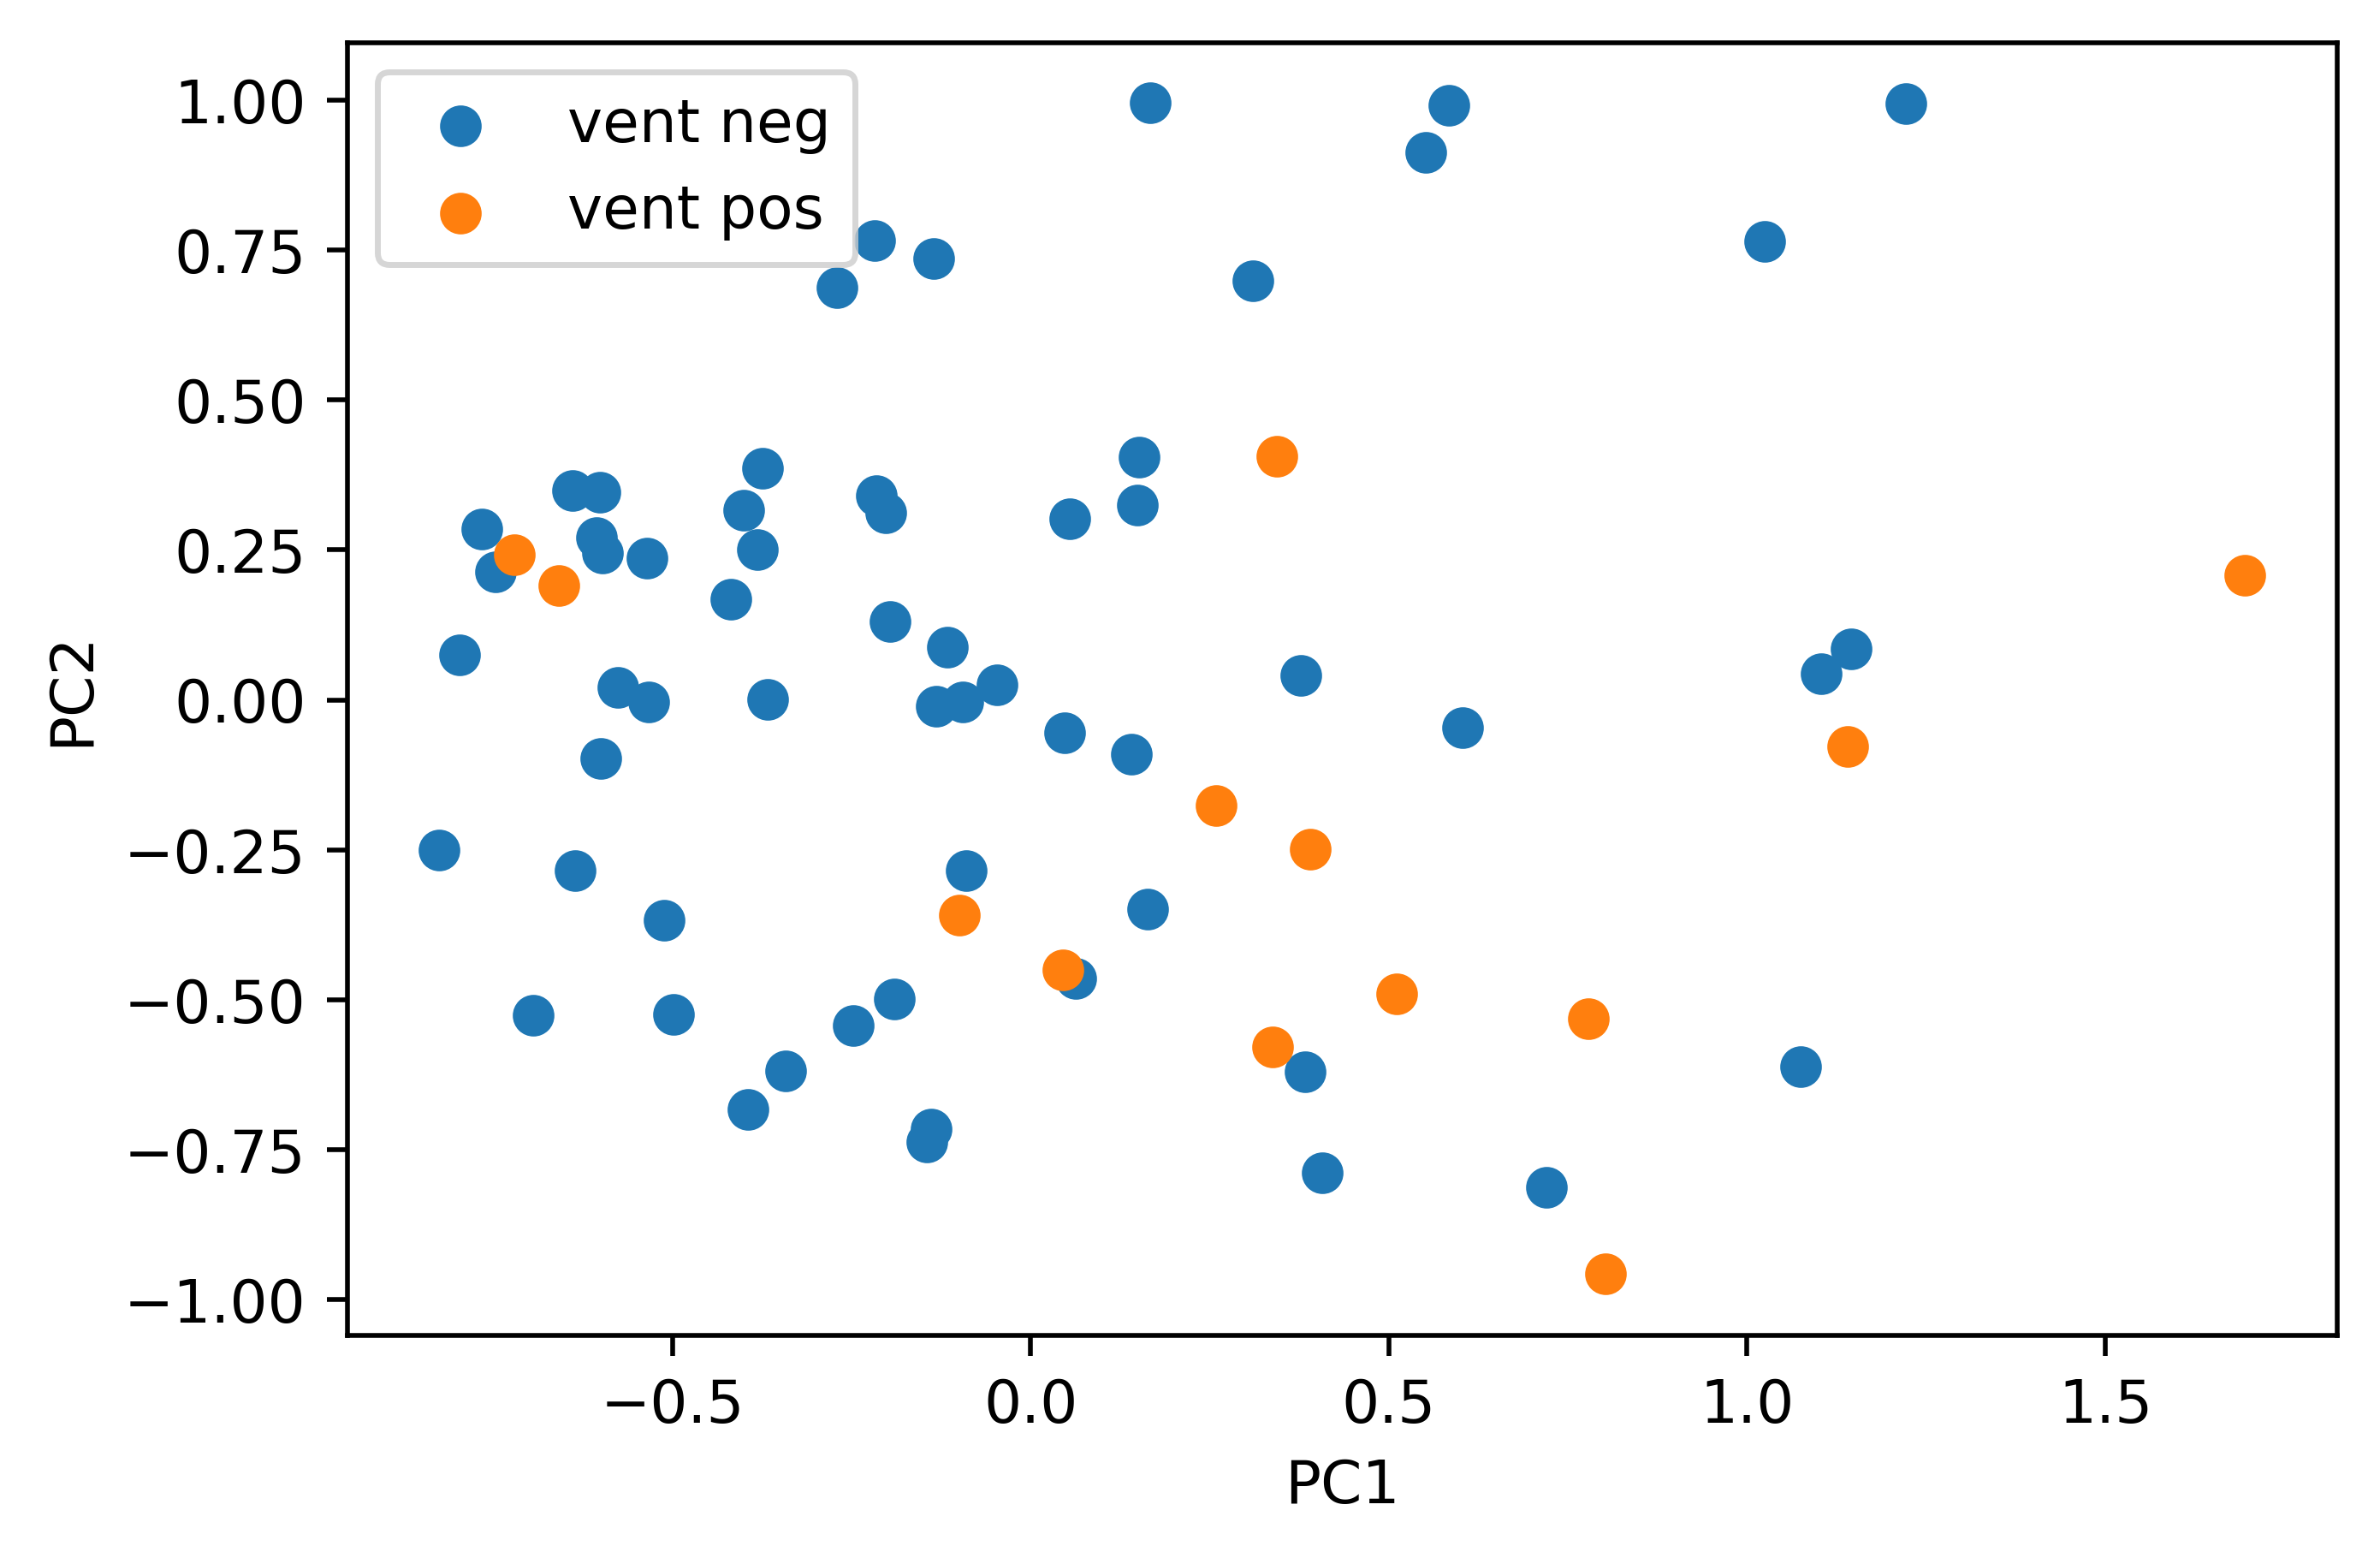

<Figure size 3000x2000 with 0 Axes>

In [207]:
vent_status_neg = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "No" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]
vent_status_pos = [sampCols.index(samp2rowMap[row["Sample"]]) for index,row in metadata.iterrows() if row["Sample"] in samp2rowMap and "Yes" in str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"]) and "d0_Yes" in str(row["day-COVID"])]

vent_status = [1 for x in range(len(sampData_sig))]
for ind in vent_status_neg:
    vent_status[ind] = 0

ind = vent_status_neg + vent_status_pos
X_whole = sampData_sig[ind,:]
y_whole = [vent_status[x] for x in ind]

data_reduced = pca.fit_transform(X_whole)

plt.scatter(data_reduced[:len(vent_status_neg),0],data_reduced[:len(vent_status_neg),1],label="vent neg")
plt.scatter(data_reduced[len(vent_status_neg):,0],data_reduced[len(vent_status_neg):,1],label="vent pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.figure()

X_train,X_test,y_train,y_test = train_test_split(X_whole,y_whole,random_state=0,test_size=.20)
y_train = np.array(y_train)
y_test = np.array(y_test)

numPos = len([x for x in y_train if x > .5])
numNeg = len(y_train) - numPos
sampleWeights = [.5/numPos for _ in y_train]
for x in range(len(y_train)):
    if y_train[x] < .5:
        sampleWeights[x] = .5/numNeg

46 11
8


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:333: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
c:\use

<Figure size 3000x2000 with 0 Axes>

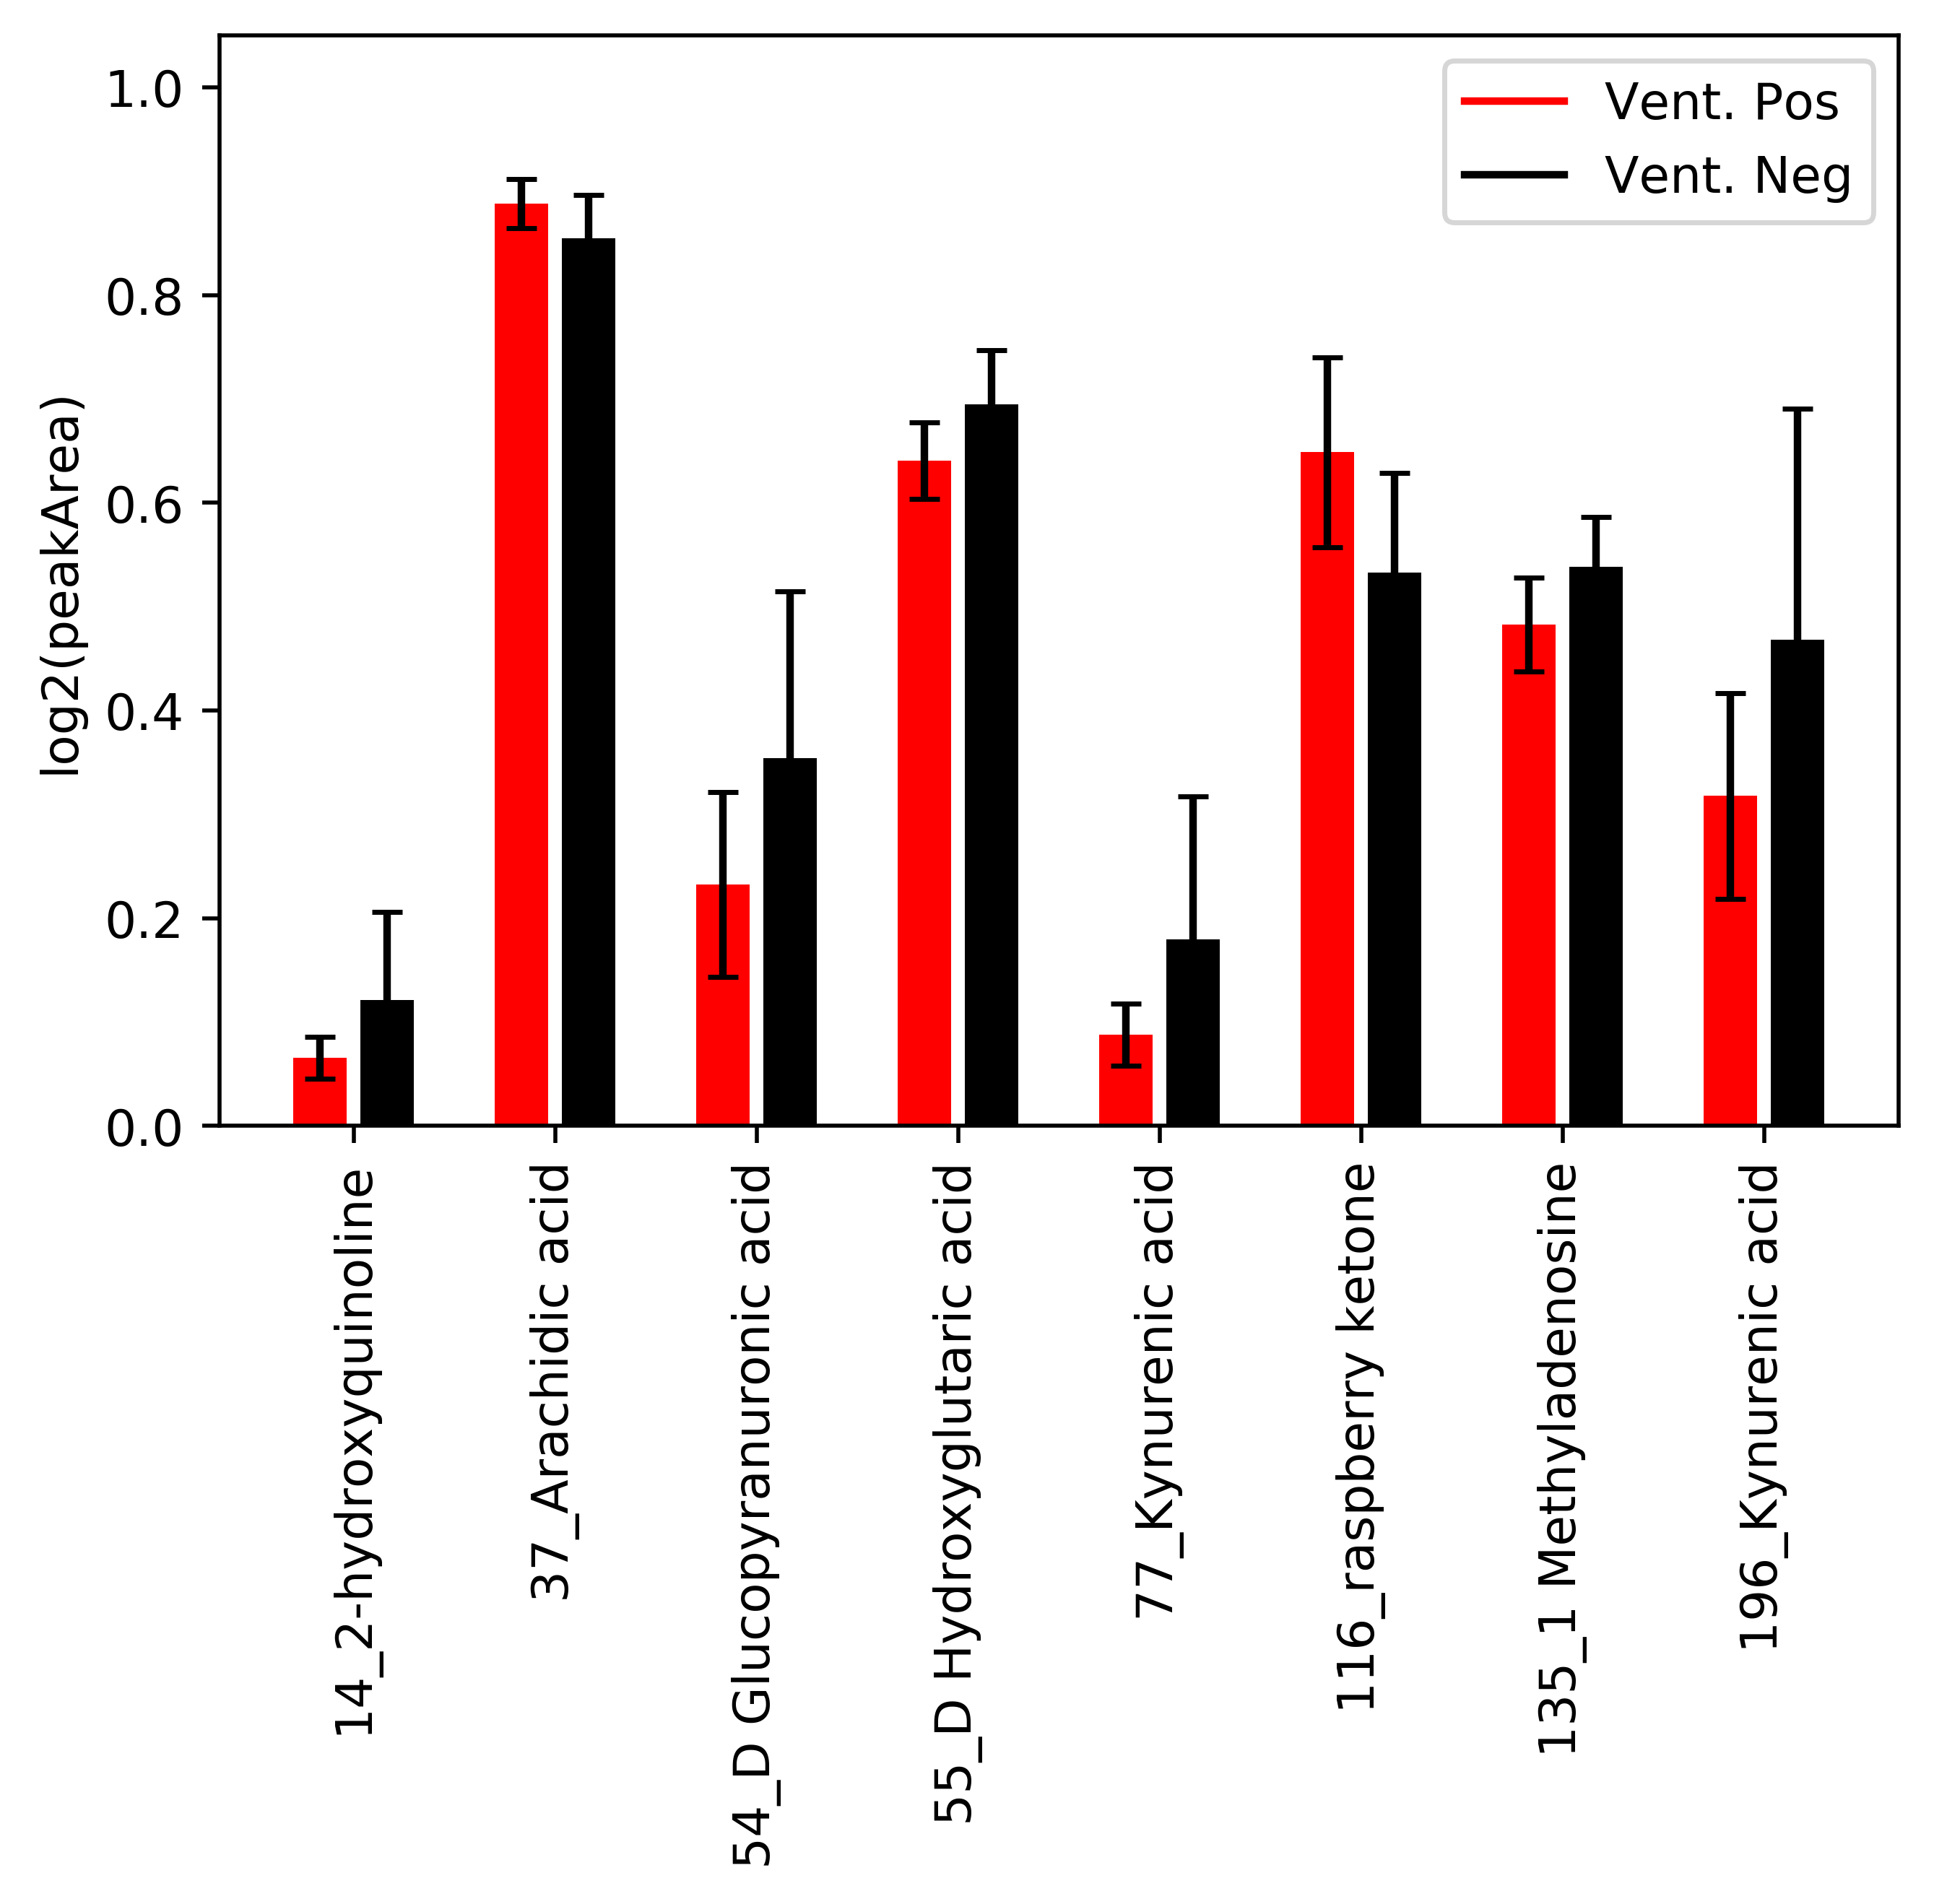

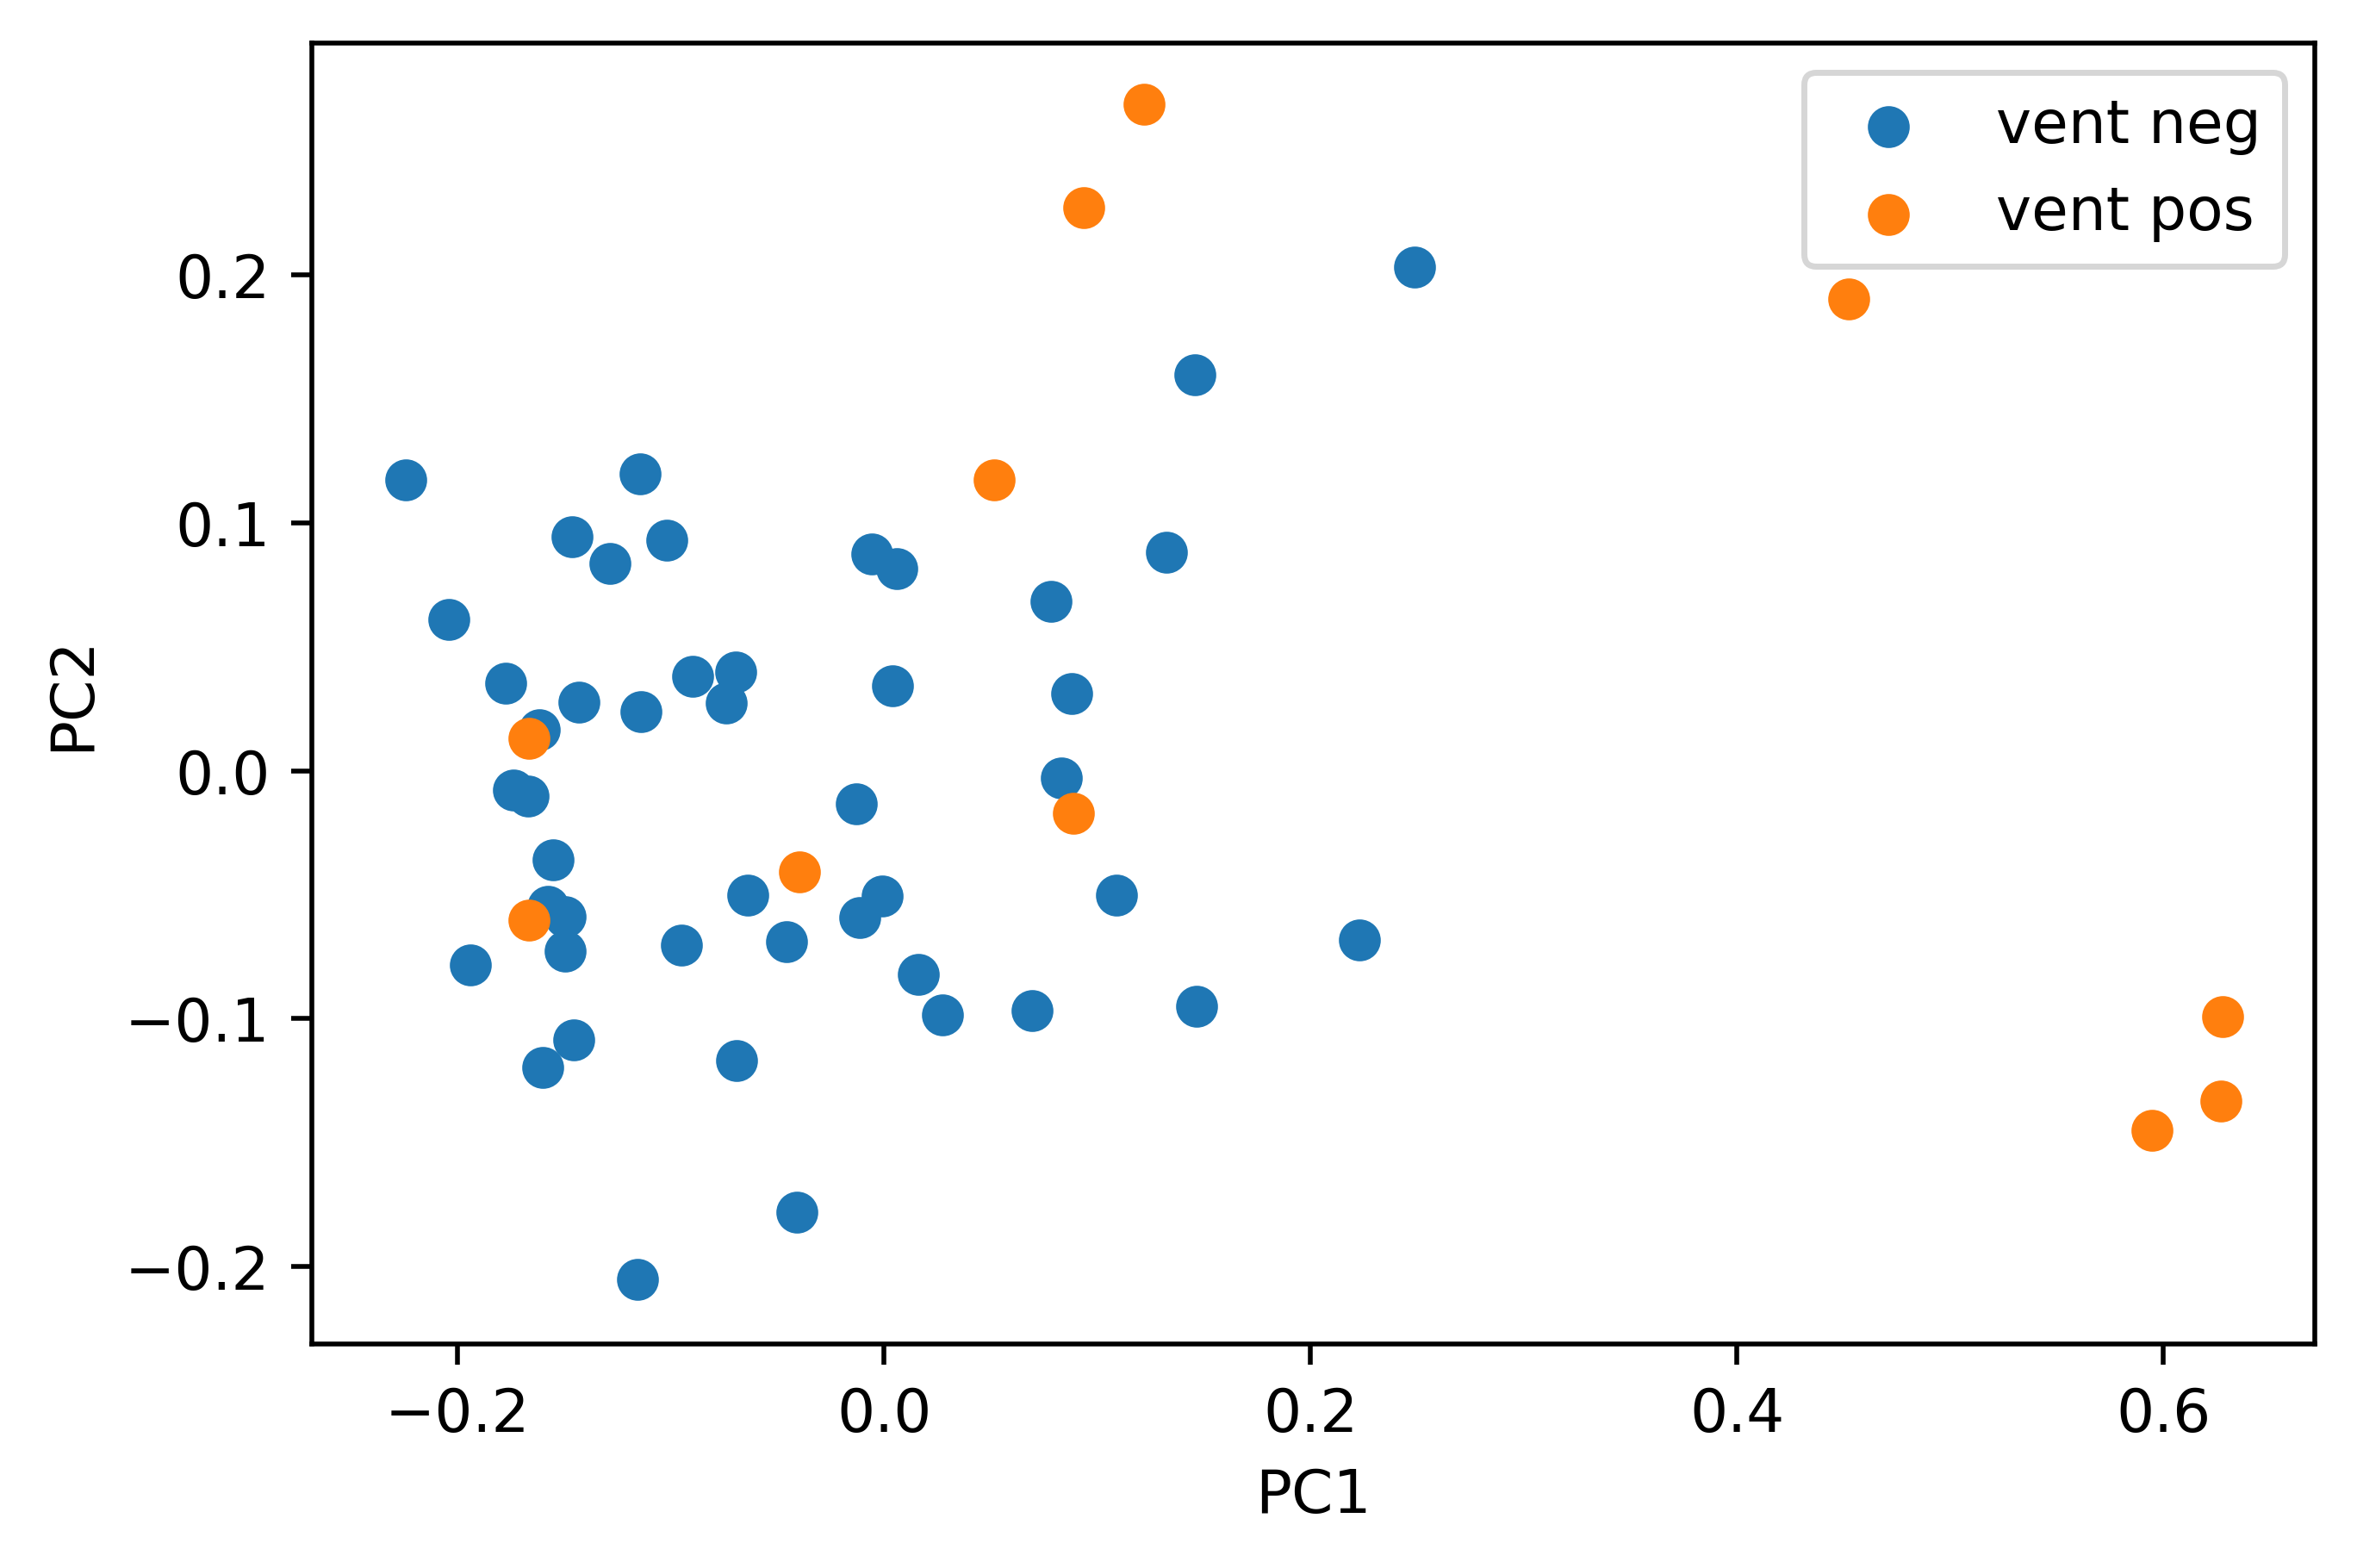

<Figure size 3000x2000 with 0 Axes>

In [212]:
ventNeg = np.array([x for x,y in zip(X_train,y_train) if y < .5])
ventPos = np.array([x for x,y in zip(X_train,y_train) if y > .5])

ventNegi = np.array([x for x,y in zip(range(len(y_train)),y_train) if y < .5])
ventPosi = np.array([x for x,y in zip(range(len(y_train)),y_train) if y > .5])
print(len(ventNeg),len(ventPos))
pval = 0.05
fc = 2.0

pvals = []
for met in range(len(ventNeg[0])):
    stat,p = stats.ttest_ind(ventNeg[:,met],ventPos[:,met])
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pval,method="fdr_bh")
sigMet = [x for x in range(len(reject)) if reject[x]]
    
print(len(sigMet))
xpos = 0
poses = []
labels = []
for met in sigMet:
    metName = data.at[data.index.values[goodMets[met]],"Molecule Name"]#.split("_")[1]
    plt.bar([xpos,xpos+1],[np.mean(ventNeg[:,met]),np.mean(ventPos[:,met])],yerr=[np.std(ventNeg[:,met]),np.std(ventPos[:,met])],color=["red","black"],capsize=3)
    poses.append(xpos+.5)
    labels.append(metName)
    xpos += 3
plt.plot([-10,-10],[0,1],color="red",label="Vent. Pos")
plt.plot([-10,-10],[0,1],color="black",label="Vent. Neg")

plt.xticks(poses,labels=labels,rotation = 90)
plt.xlim((min(poses)-2,max(poses)+2))
plt.legend()
plt.ylabel("log2(peakArea)")

plt.figure()

data_reduced = pca.fit_transform(X_train[:,sigMet])

plt.scatter(data_reduced[ventNegi,0],data_reduced[ventNegi,1],label="vent neg")
plt.scatter(data_reduced[ventPosi,0],data_reduced[ventPosi,1],label="vent pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.figure()
    

training error:  0.2082373173887126
0.3058383053227629


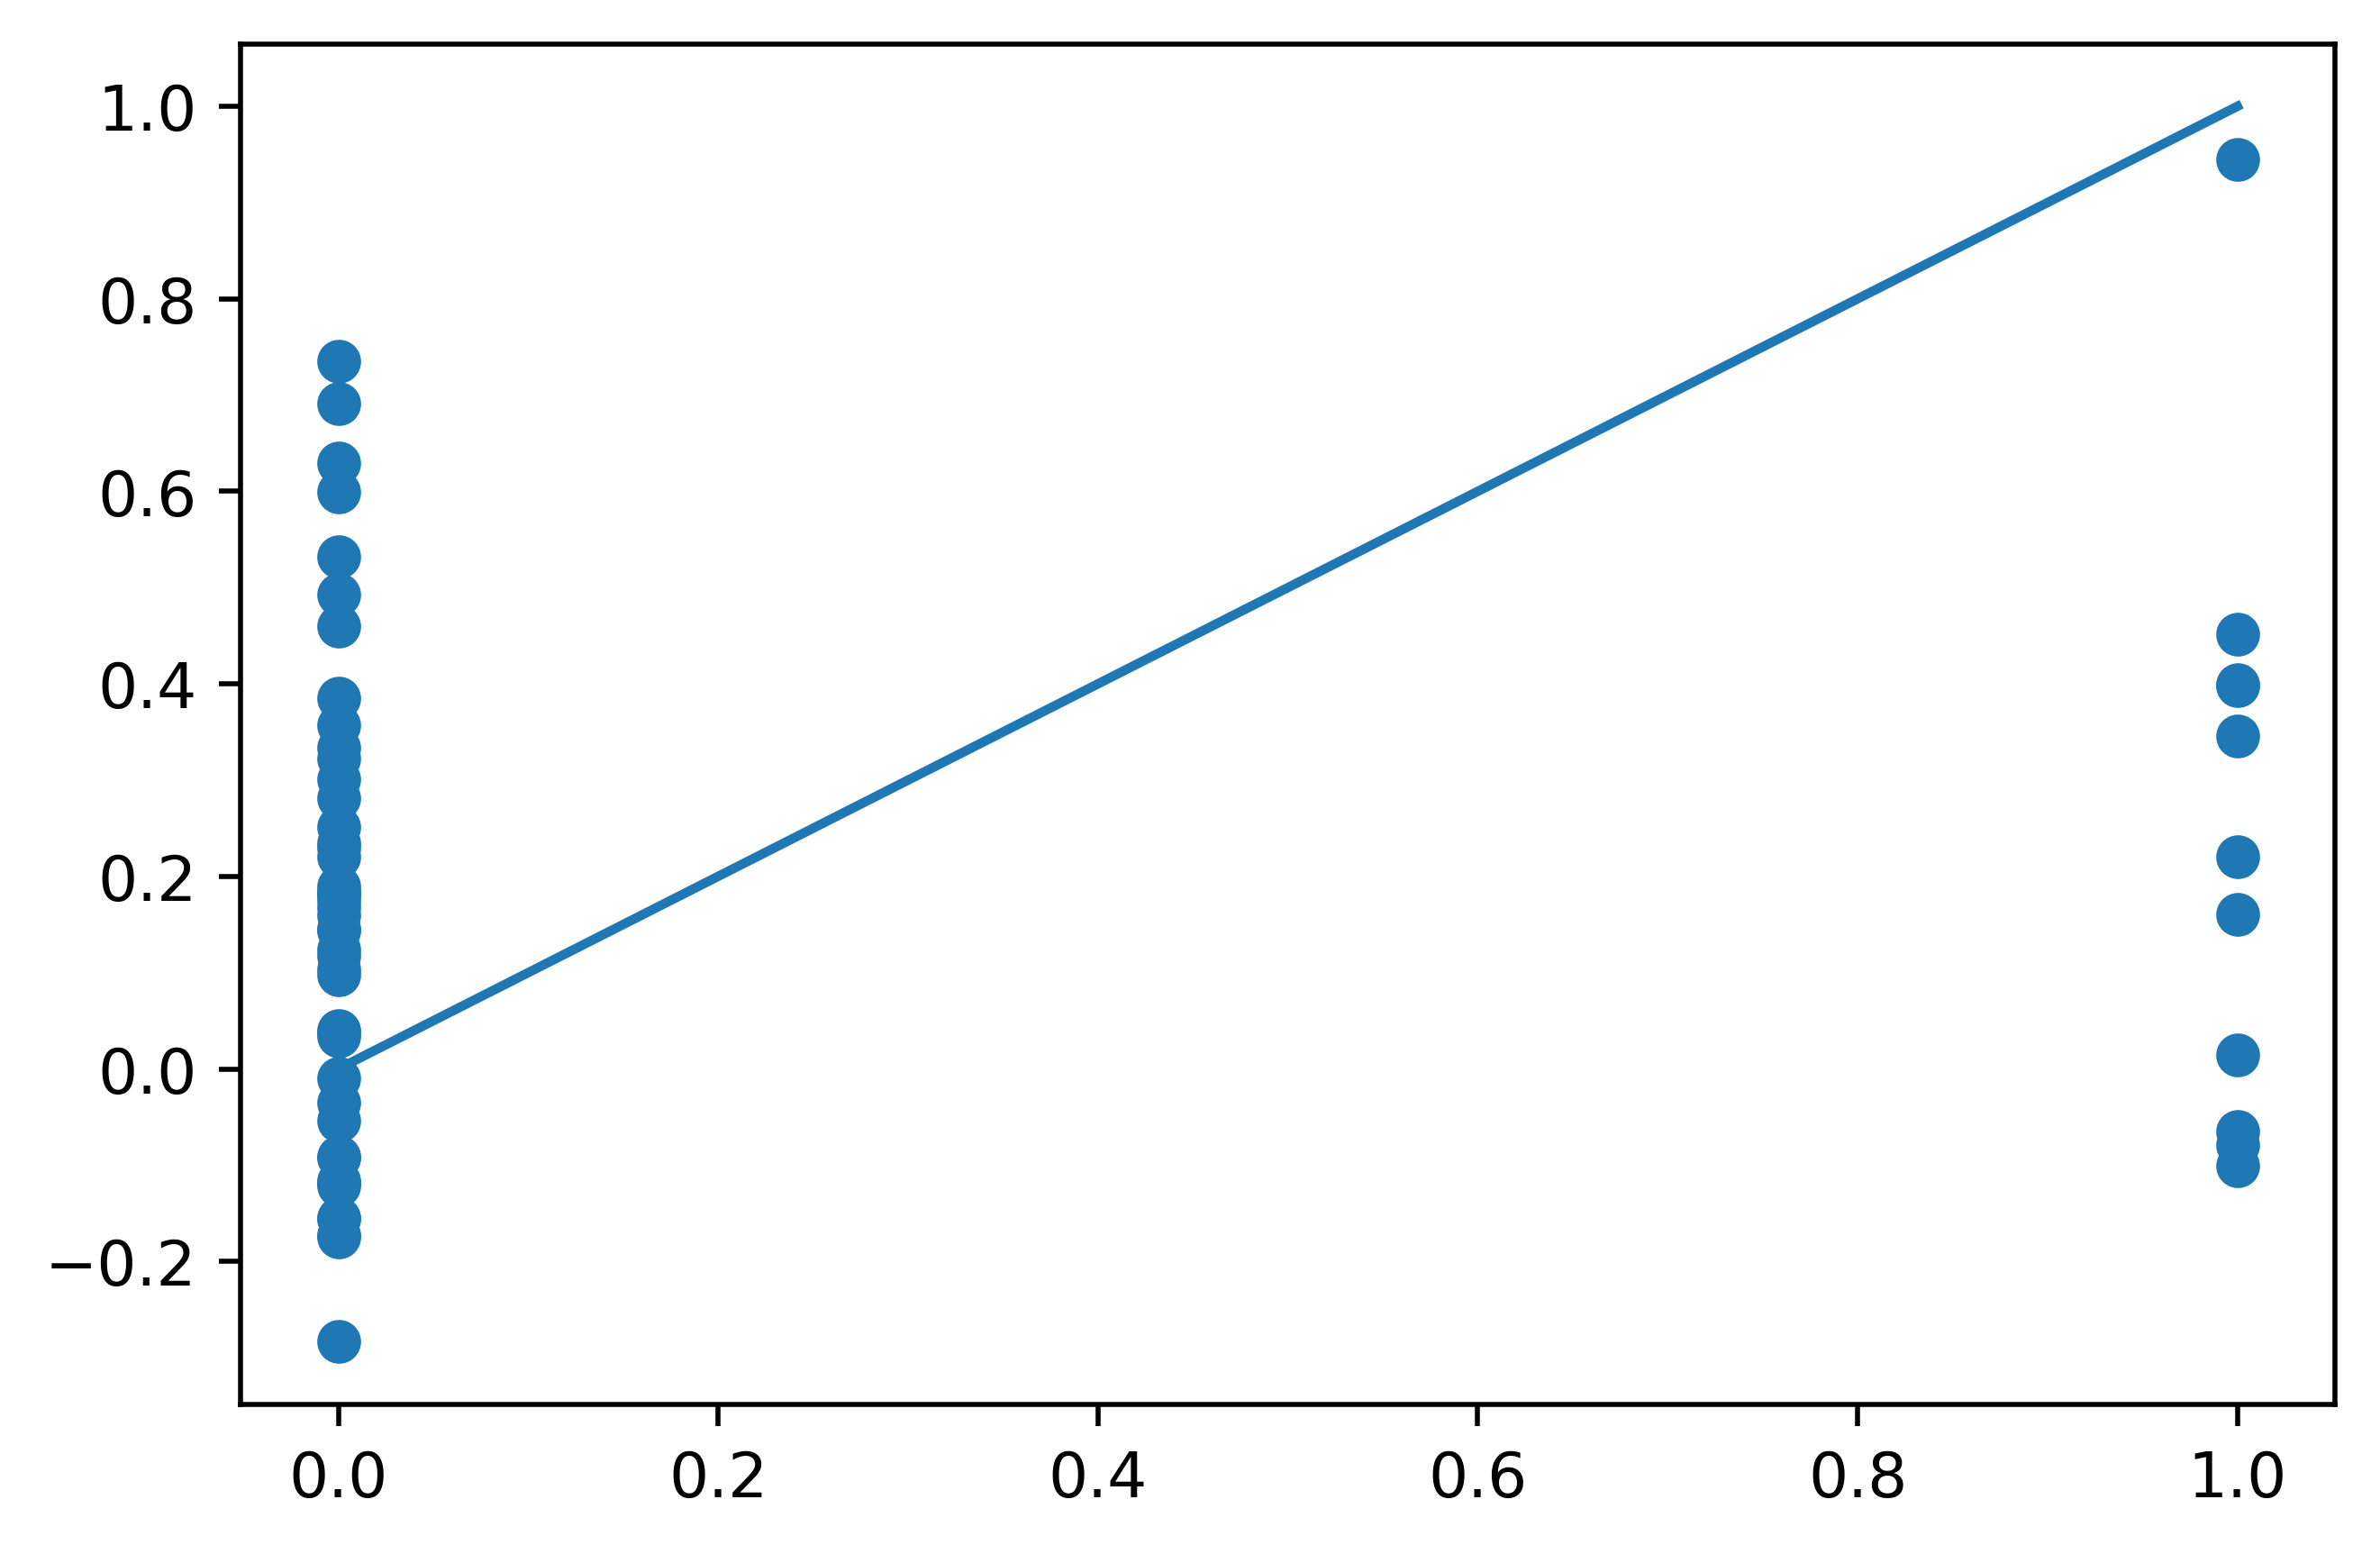

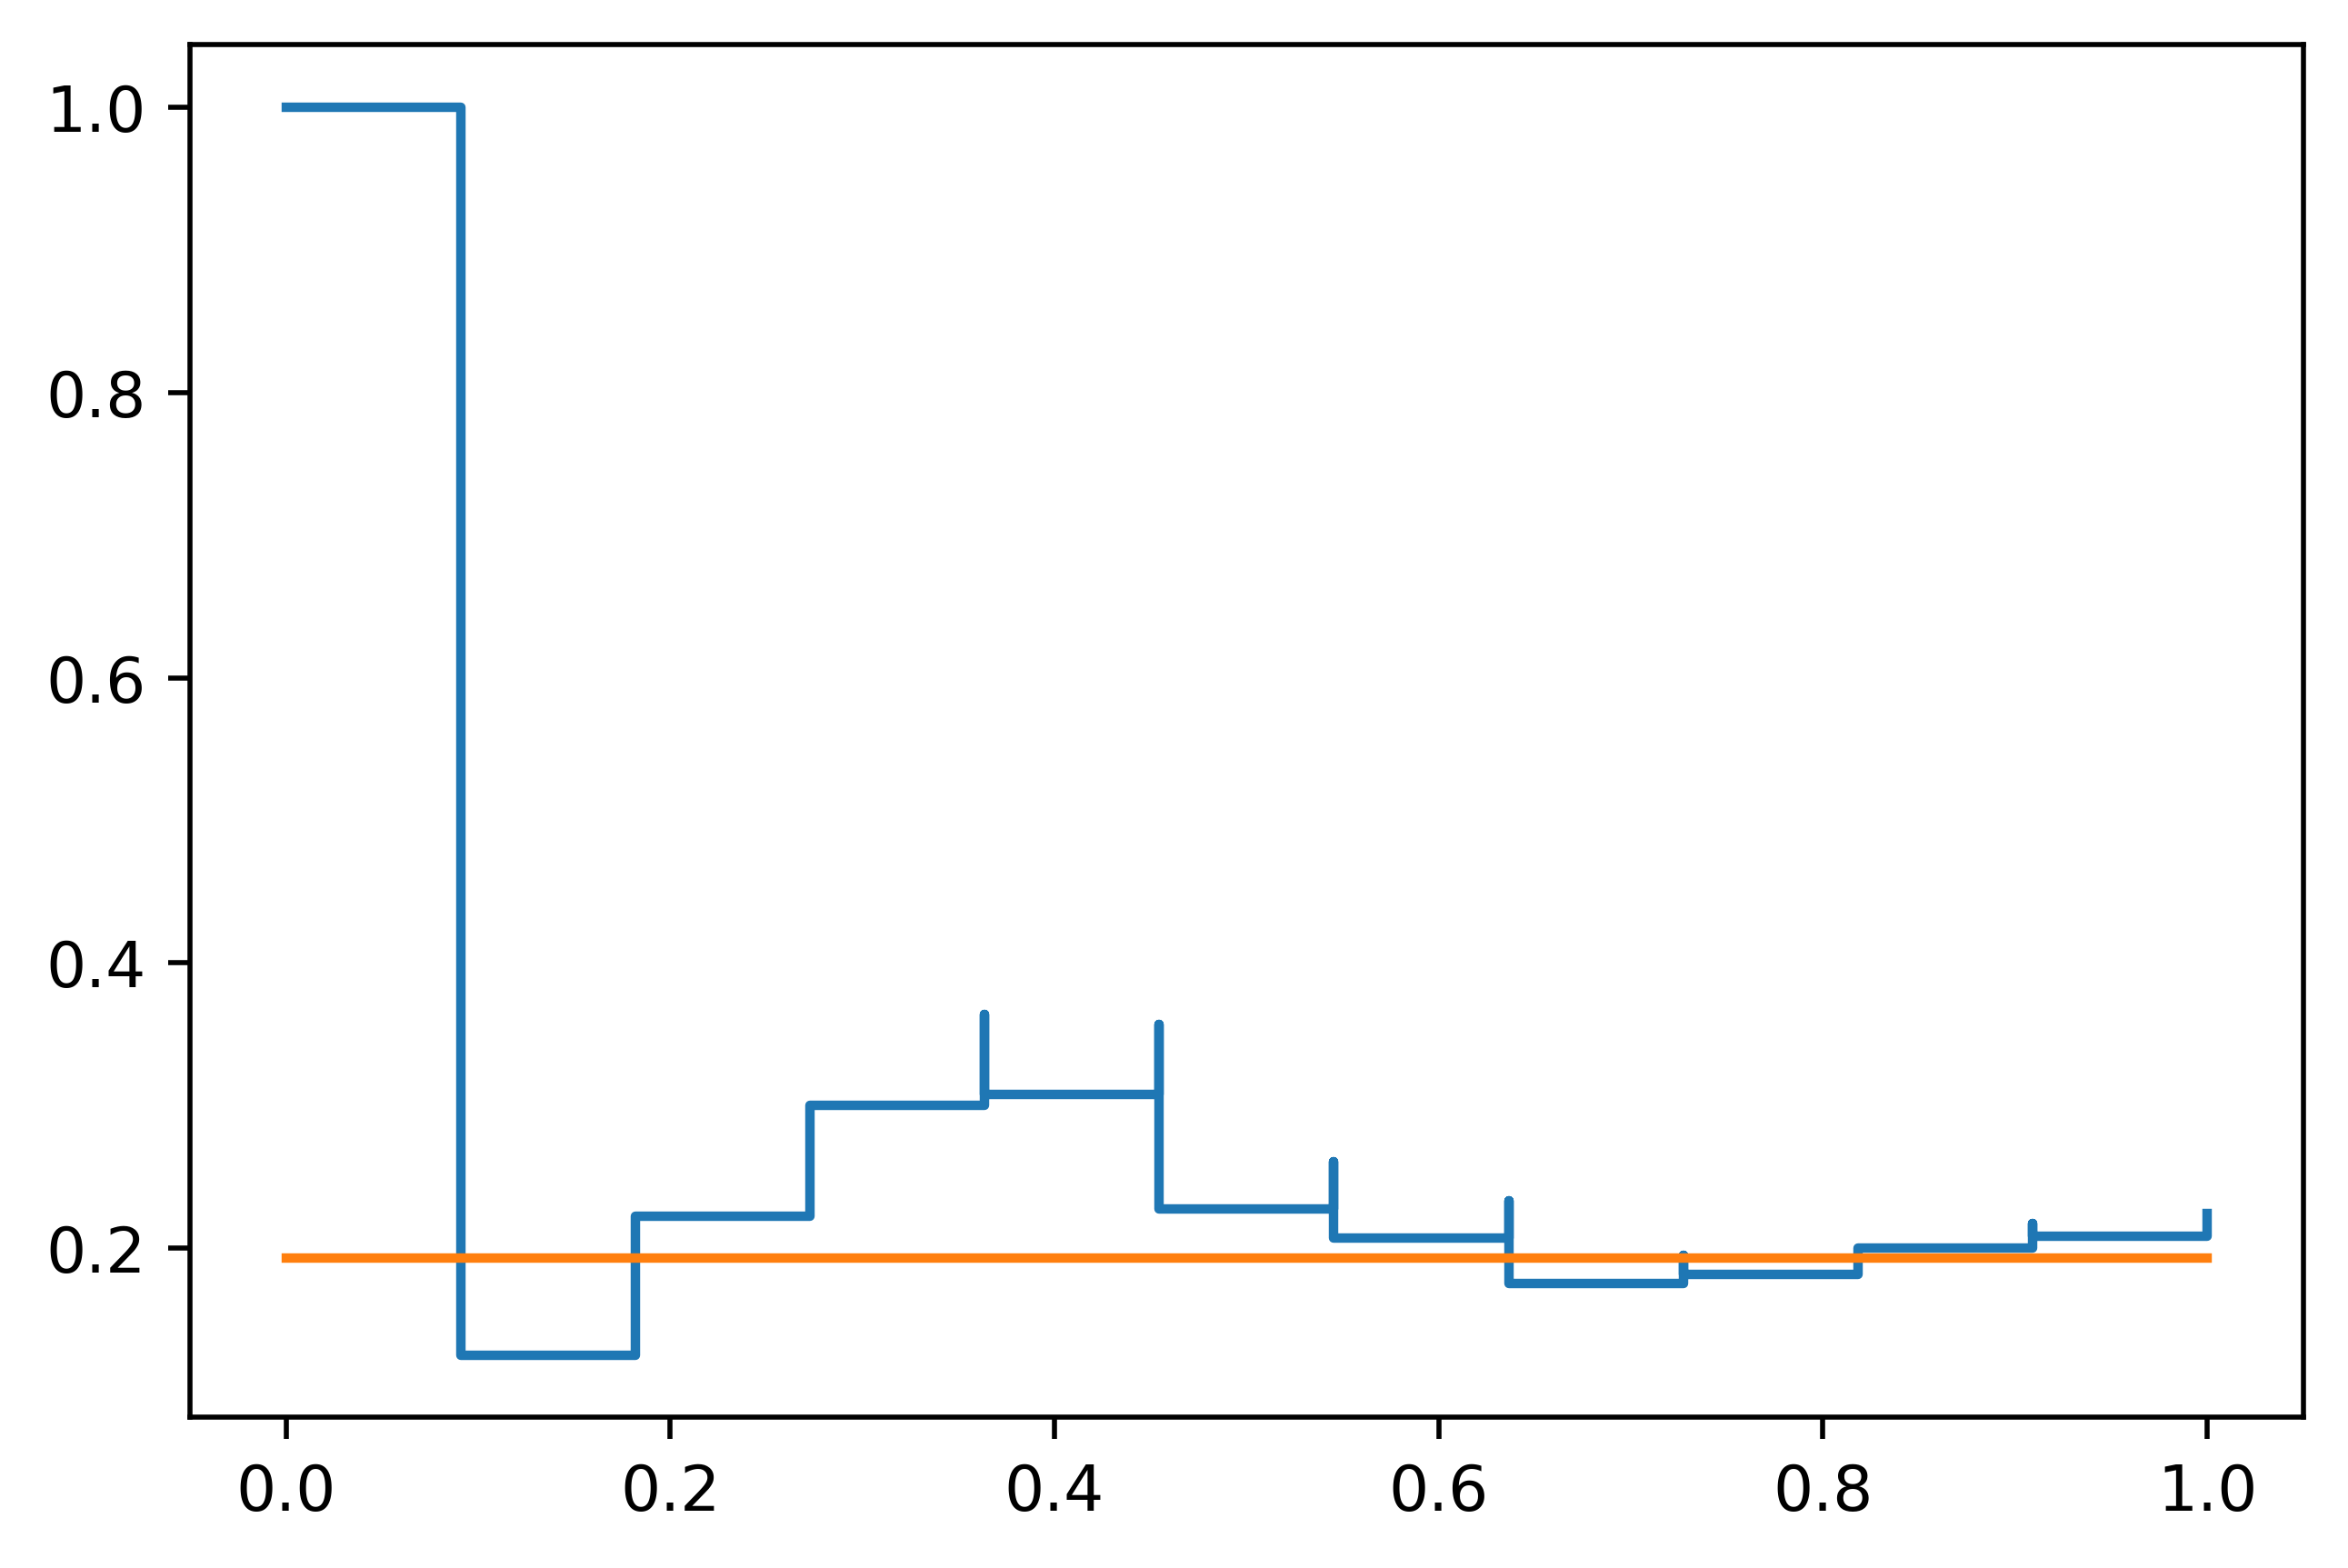

In [140]:

pls = PLSDA()

pls.train(X_train,y_train)

y_train_pred = pls.test(X_train)

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train,y_train,pls,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))
plt.scatter(y_true,y_test_pred)
plt.plot([0,1],[0,1])
plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)
plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

print(auc)






training error:  0.12280701754385964
0.30107776035793354


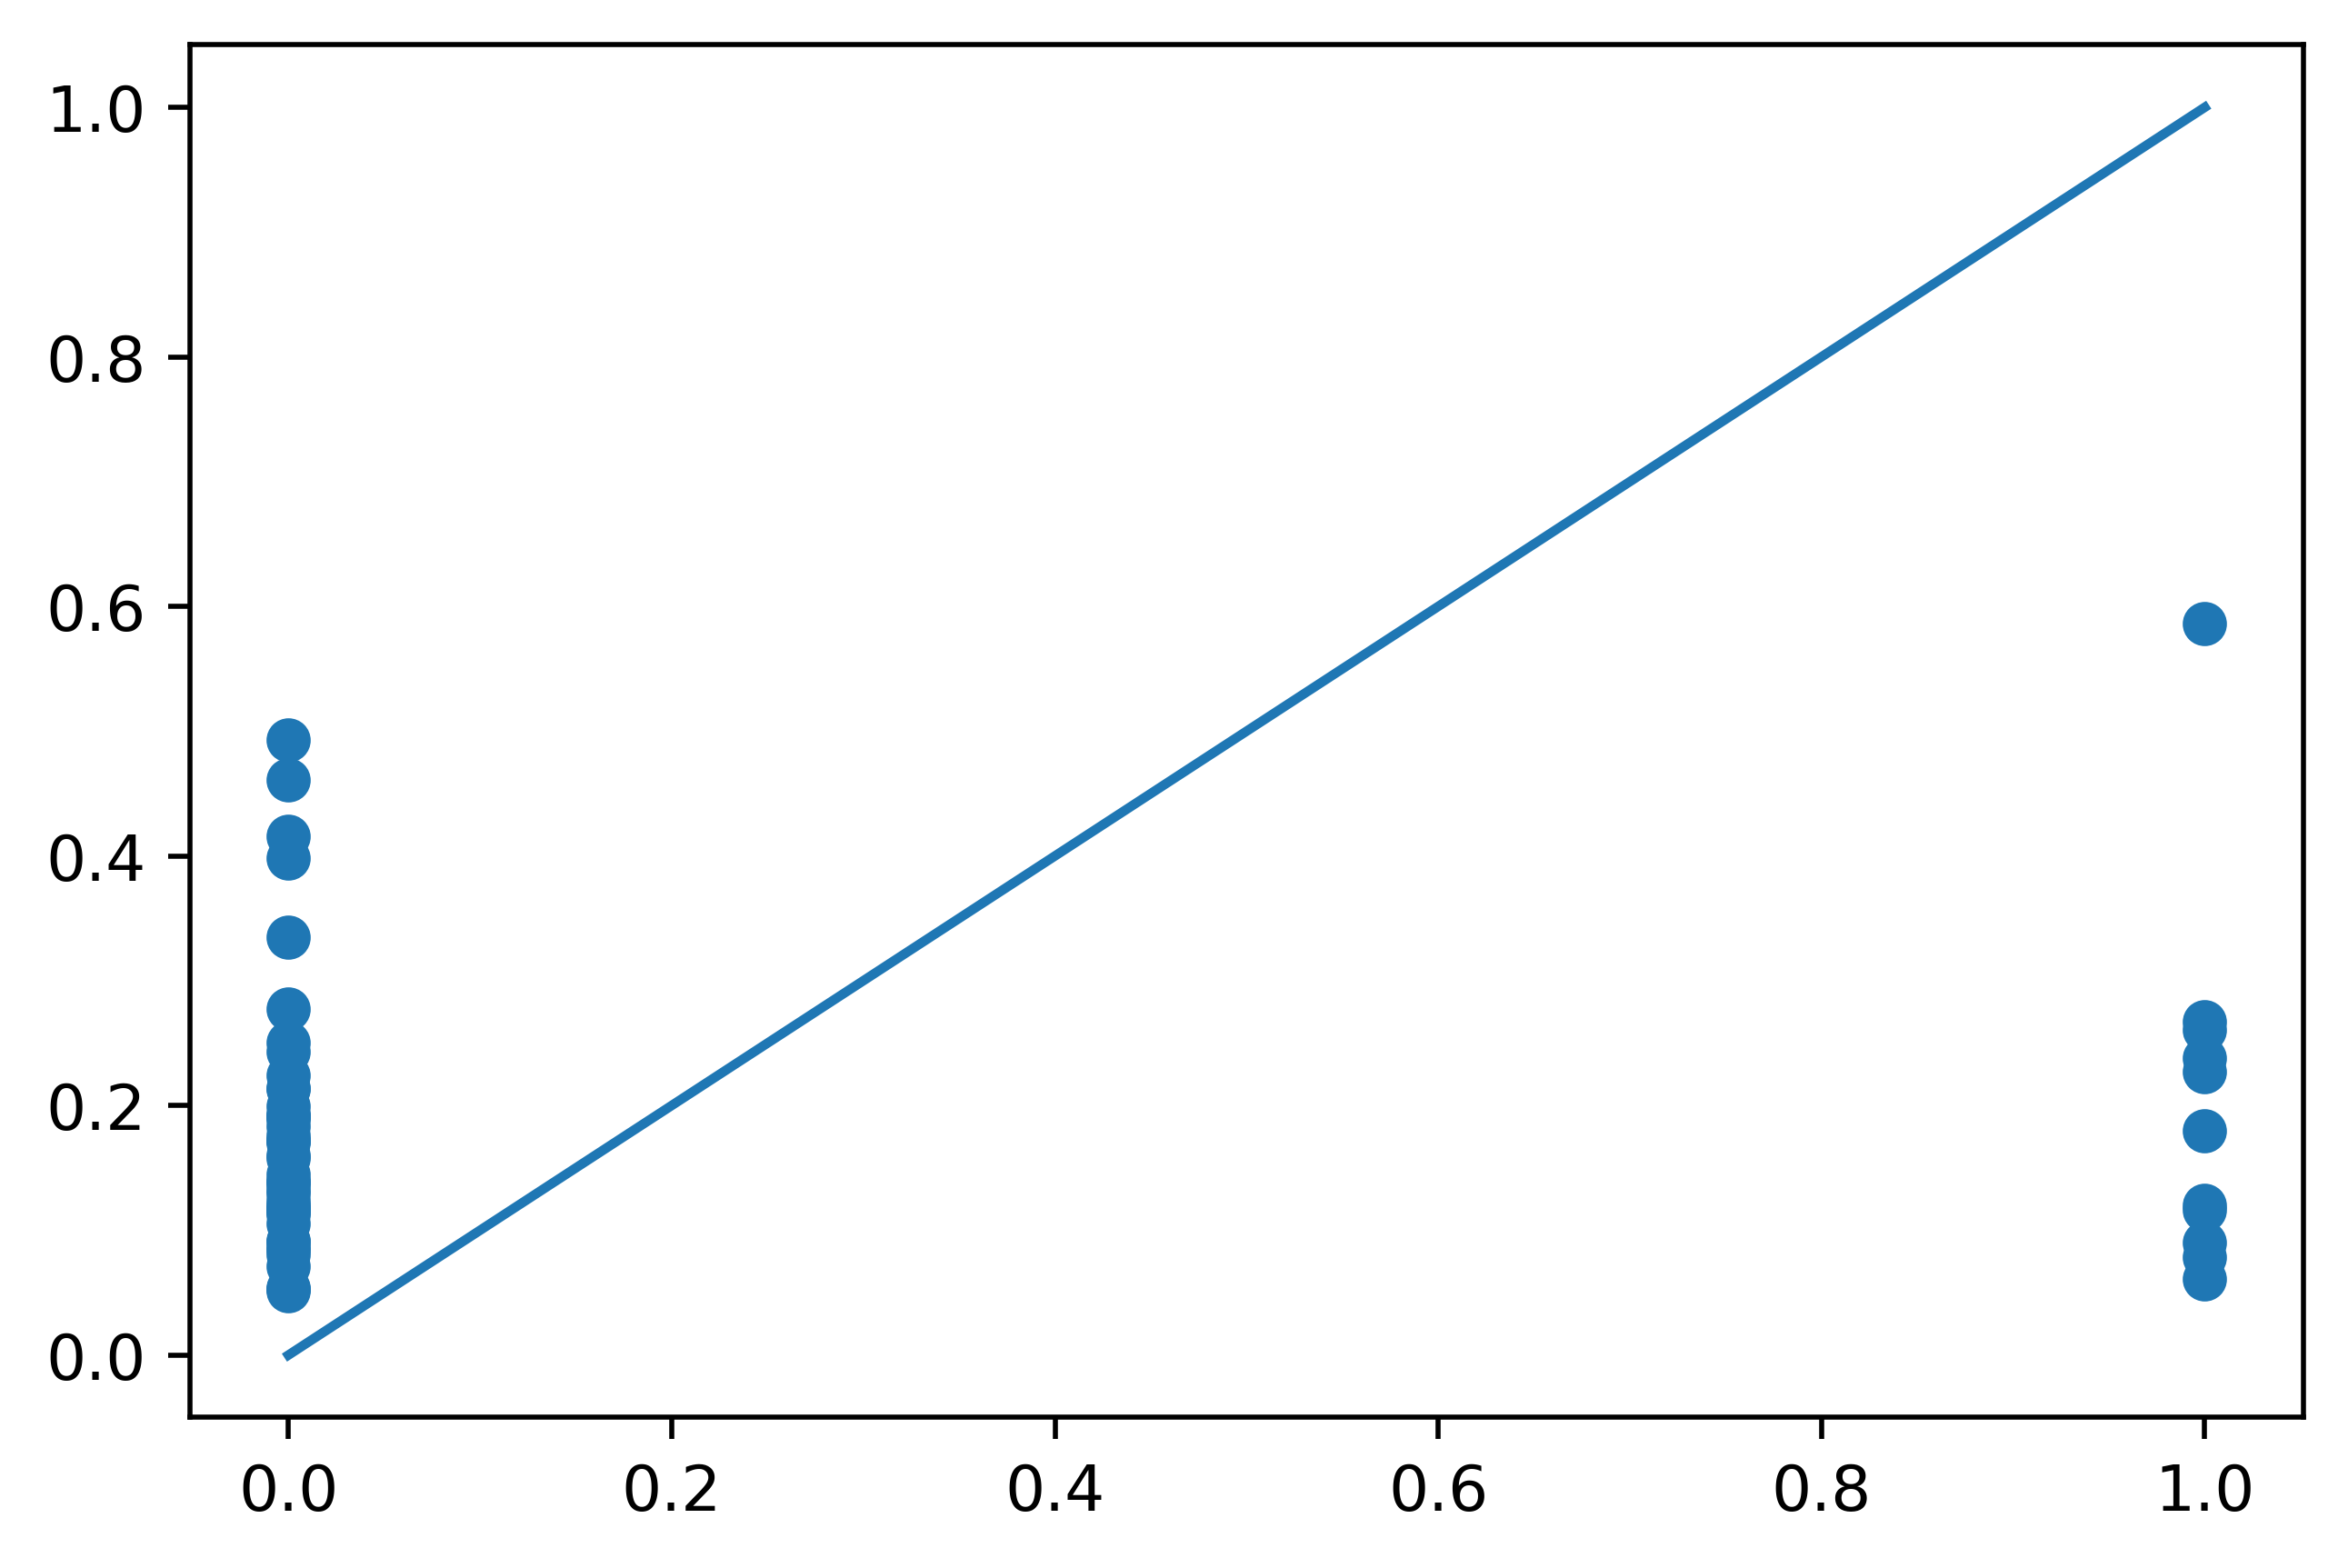

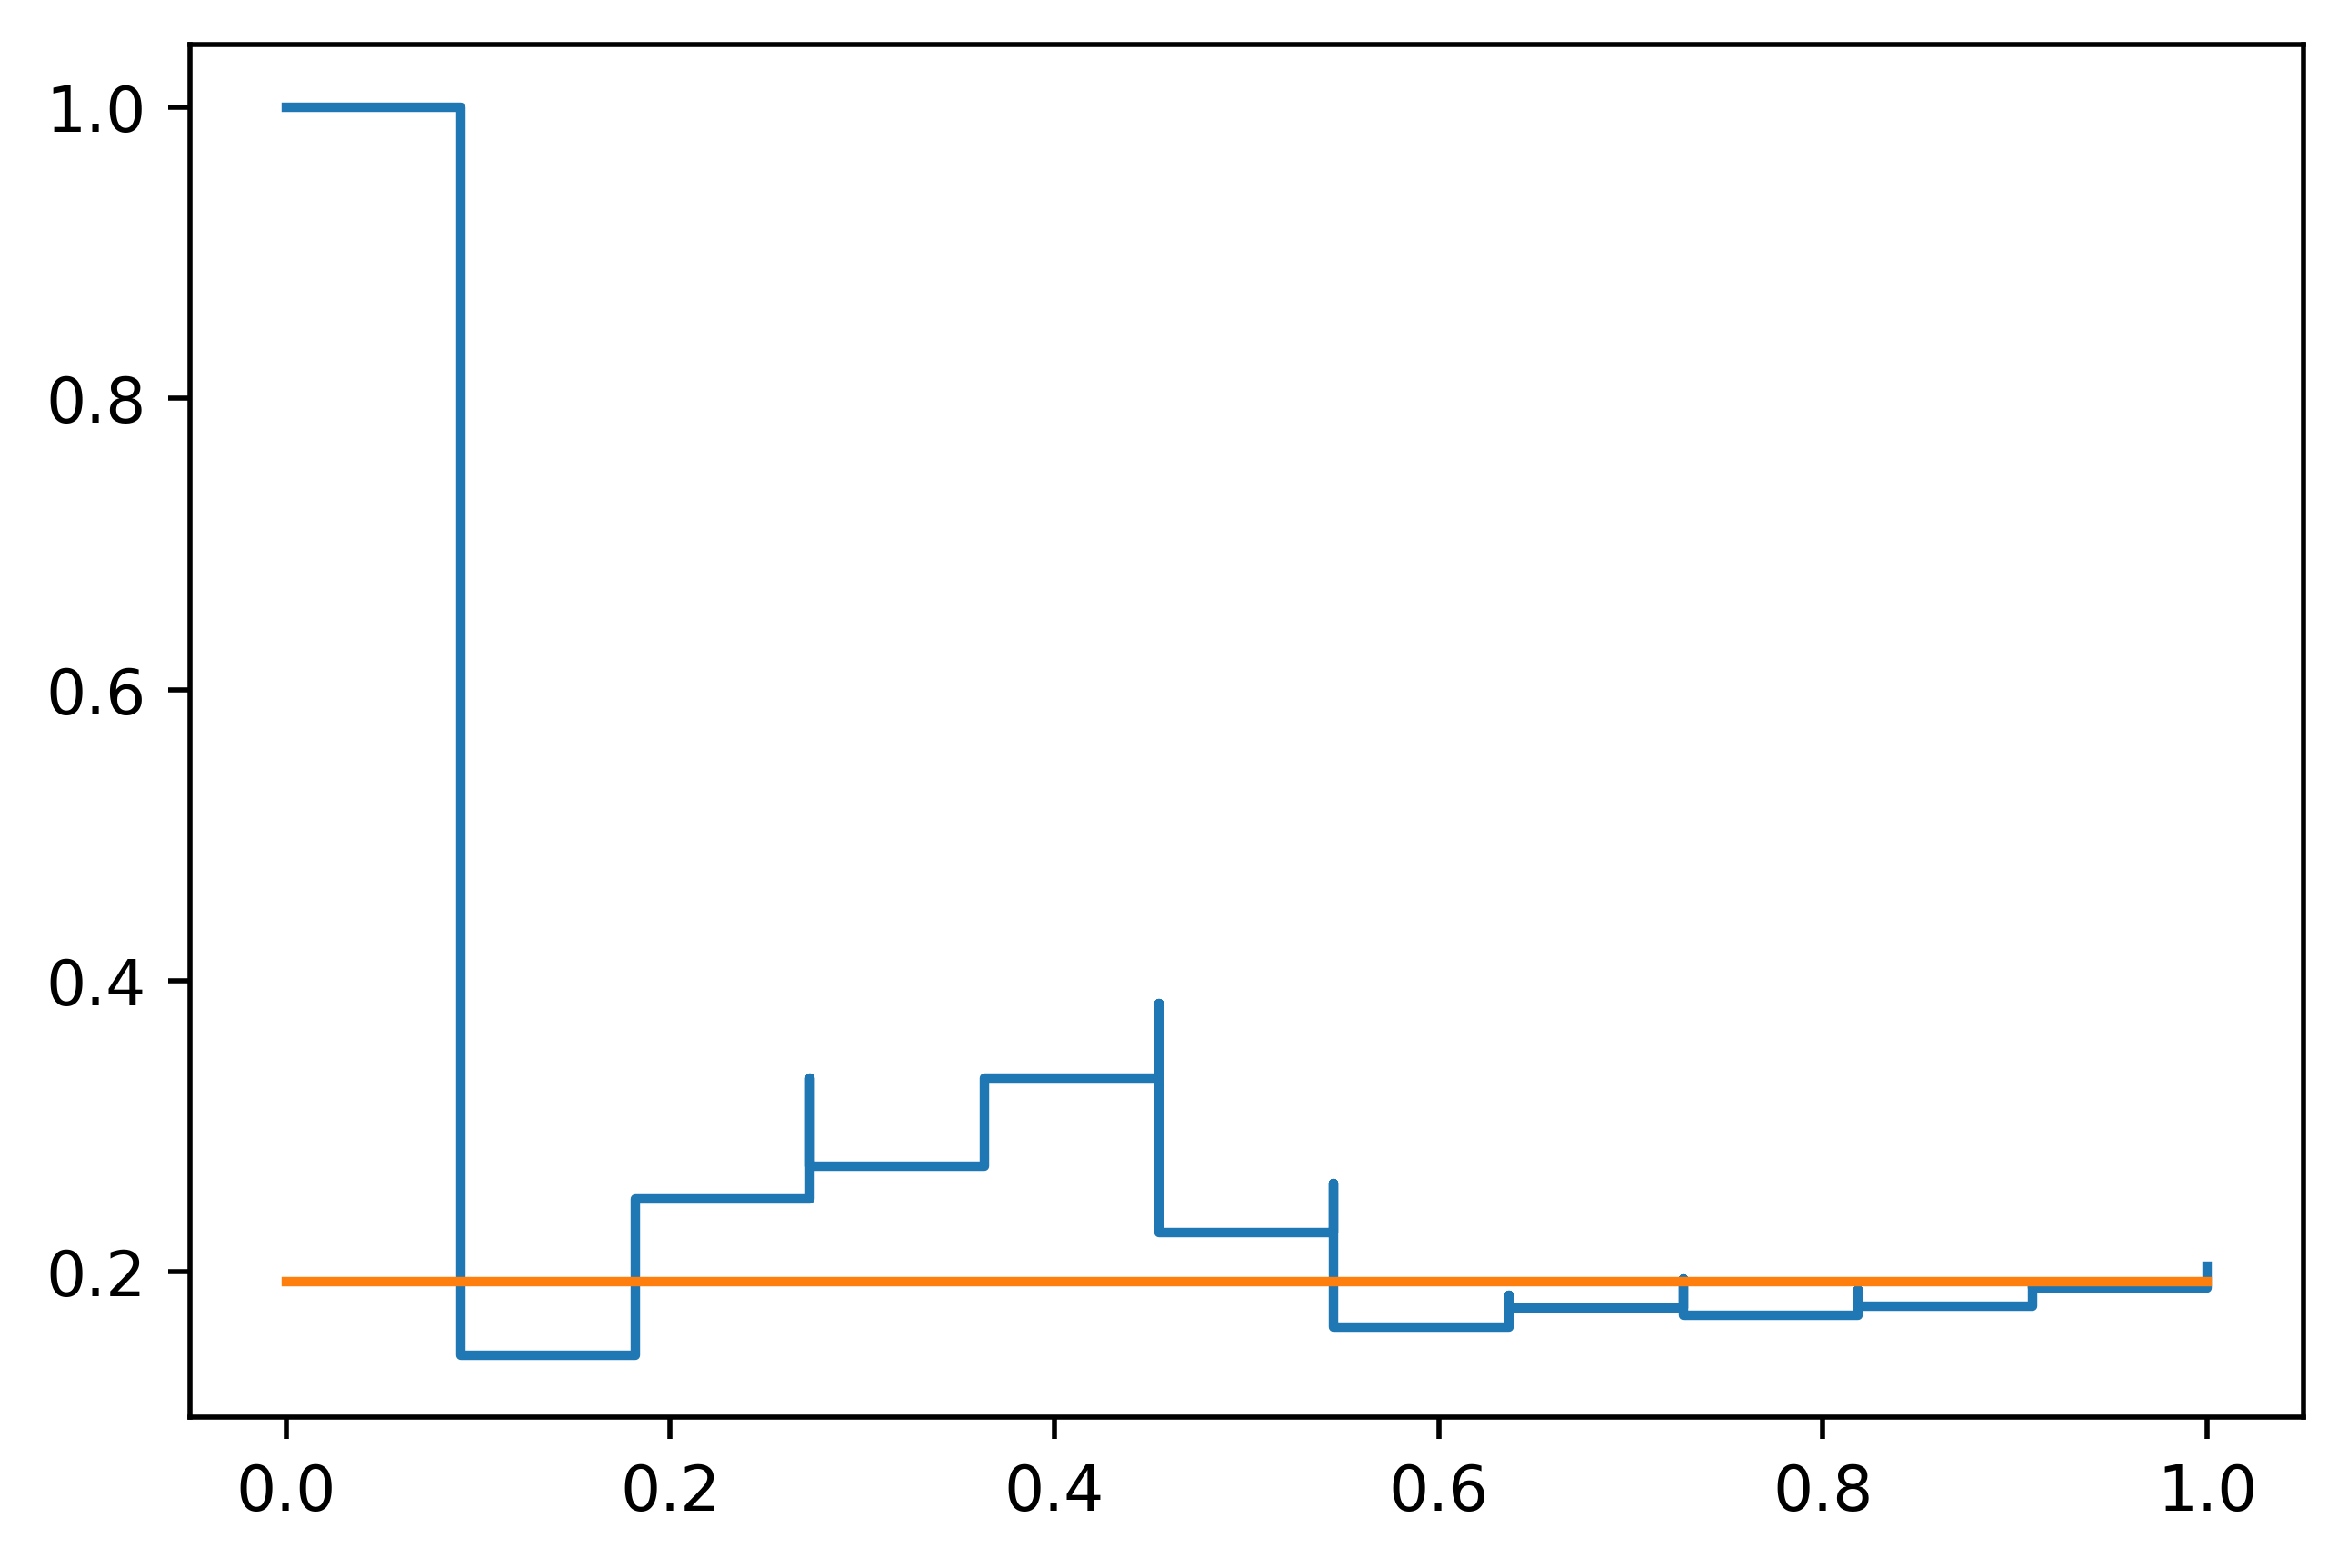

In [141]:
reg = LogisticRegression(fit_intercept=True,max_iter=1e4)
reg.fit(X_train,y_train)
y_train_pred = reg.predict(X_train)
err_train = float(len([t for p,t in zip(y_train_pred,y_train) if p != t]))/len(y_train)
print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train,y_train,reg,lambda p,x,y: p.fit(x,y),lambda p,x: p.predict_proba(x)[:,1])

plt.scatter(y_true,y_test_pred)
plt.plot([0,1],[0,1])

plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)
plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

print(auc)

training error:  0.12280701754385964
0.19340011293515005


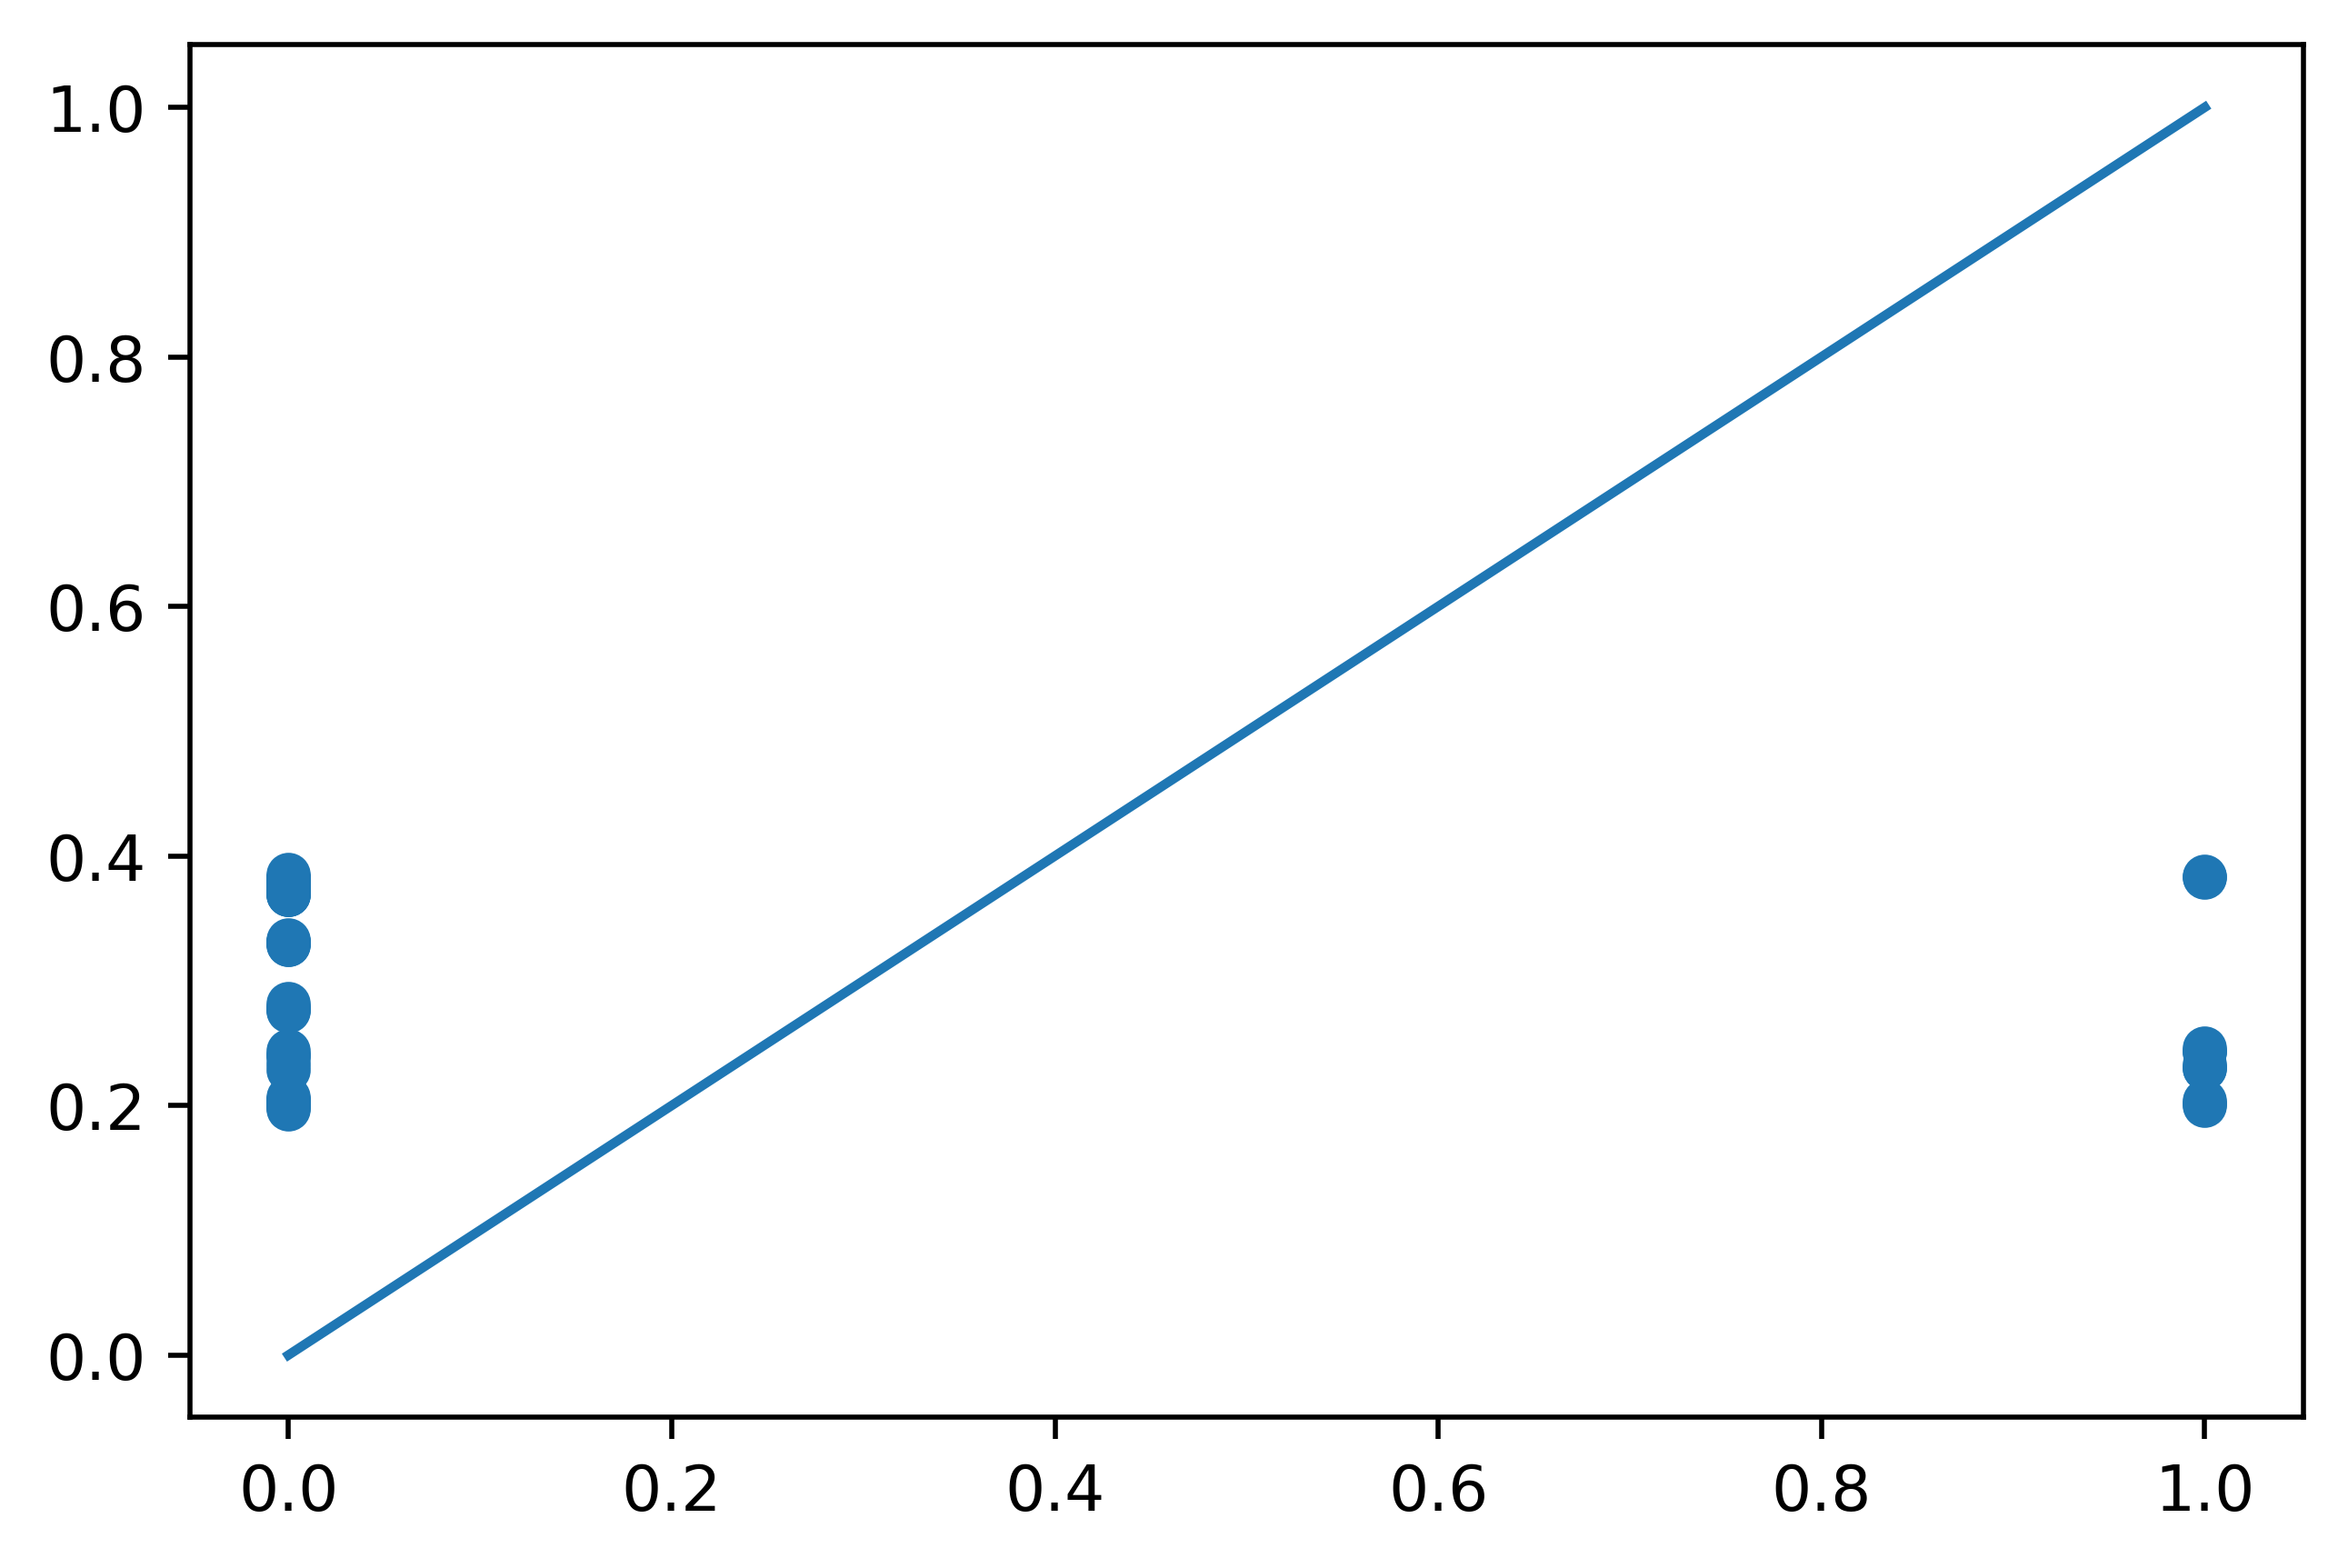

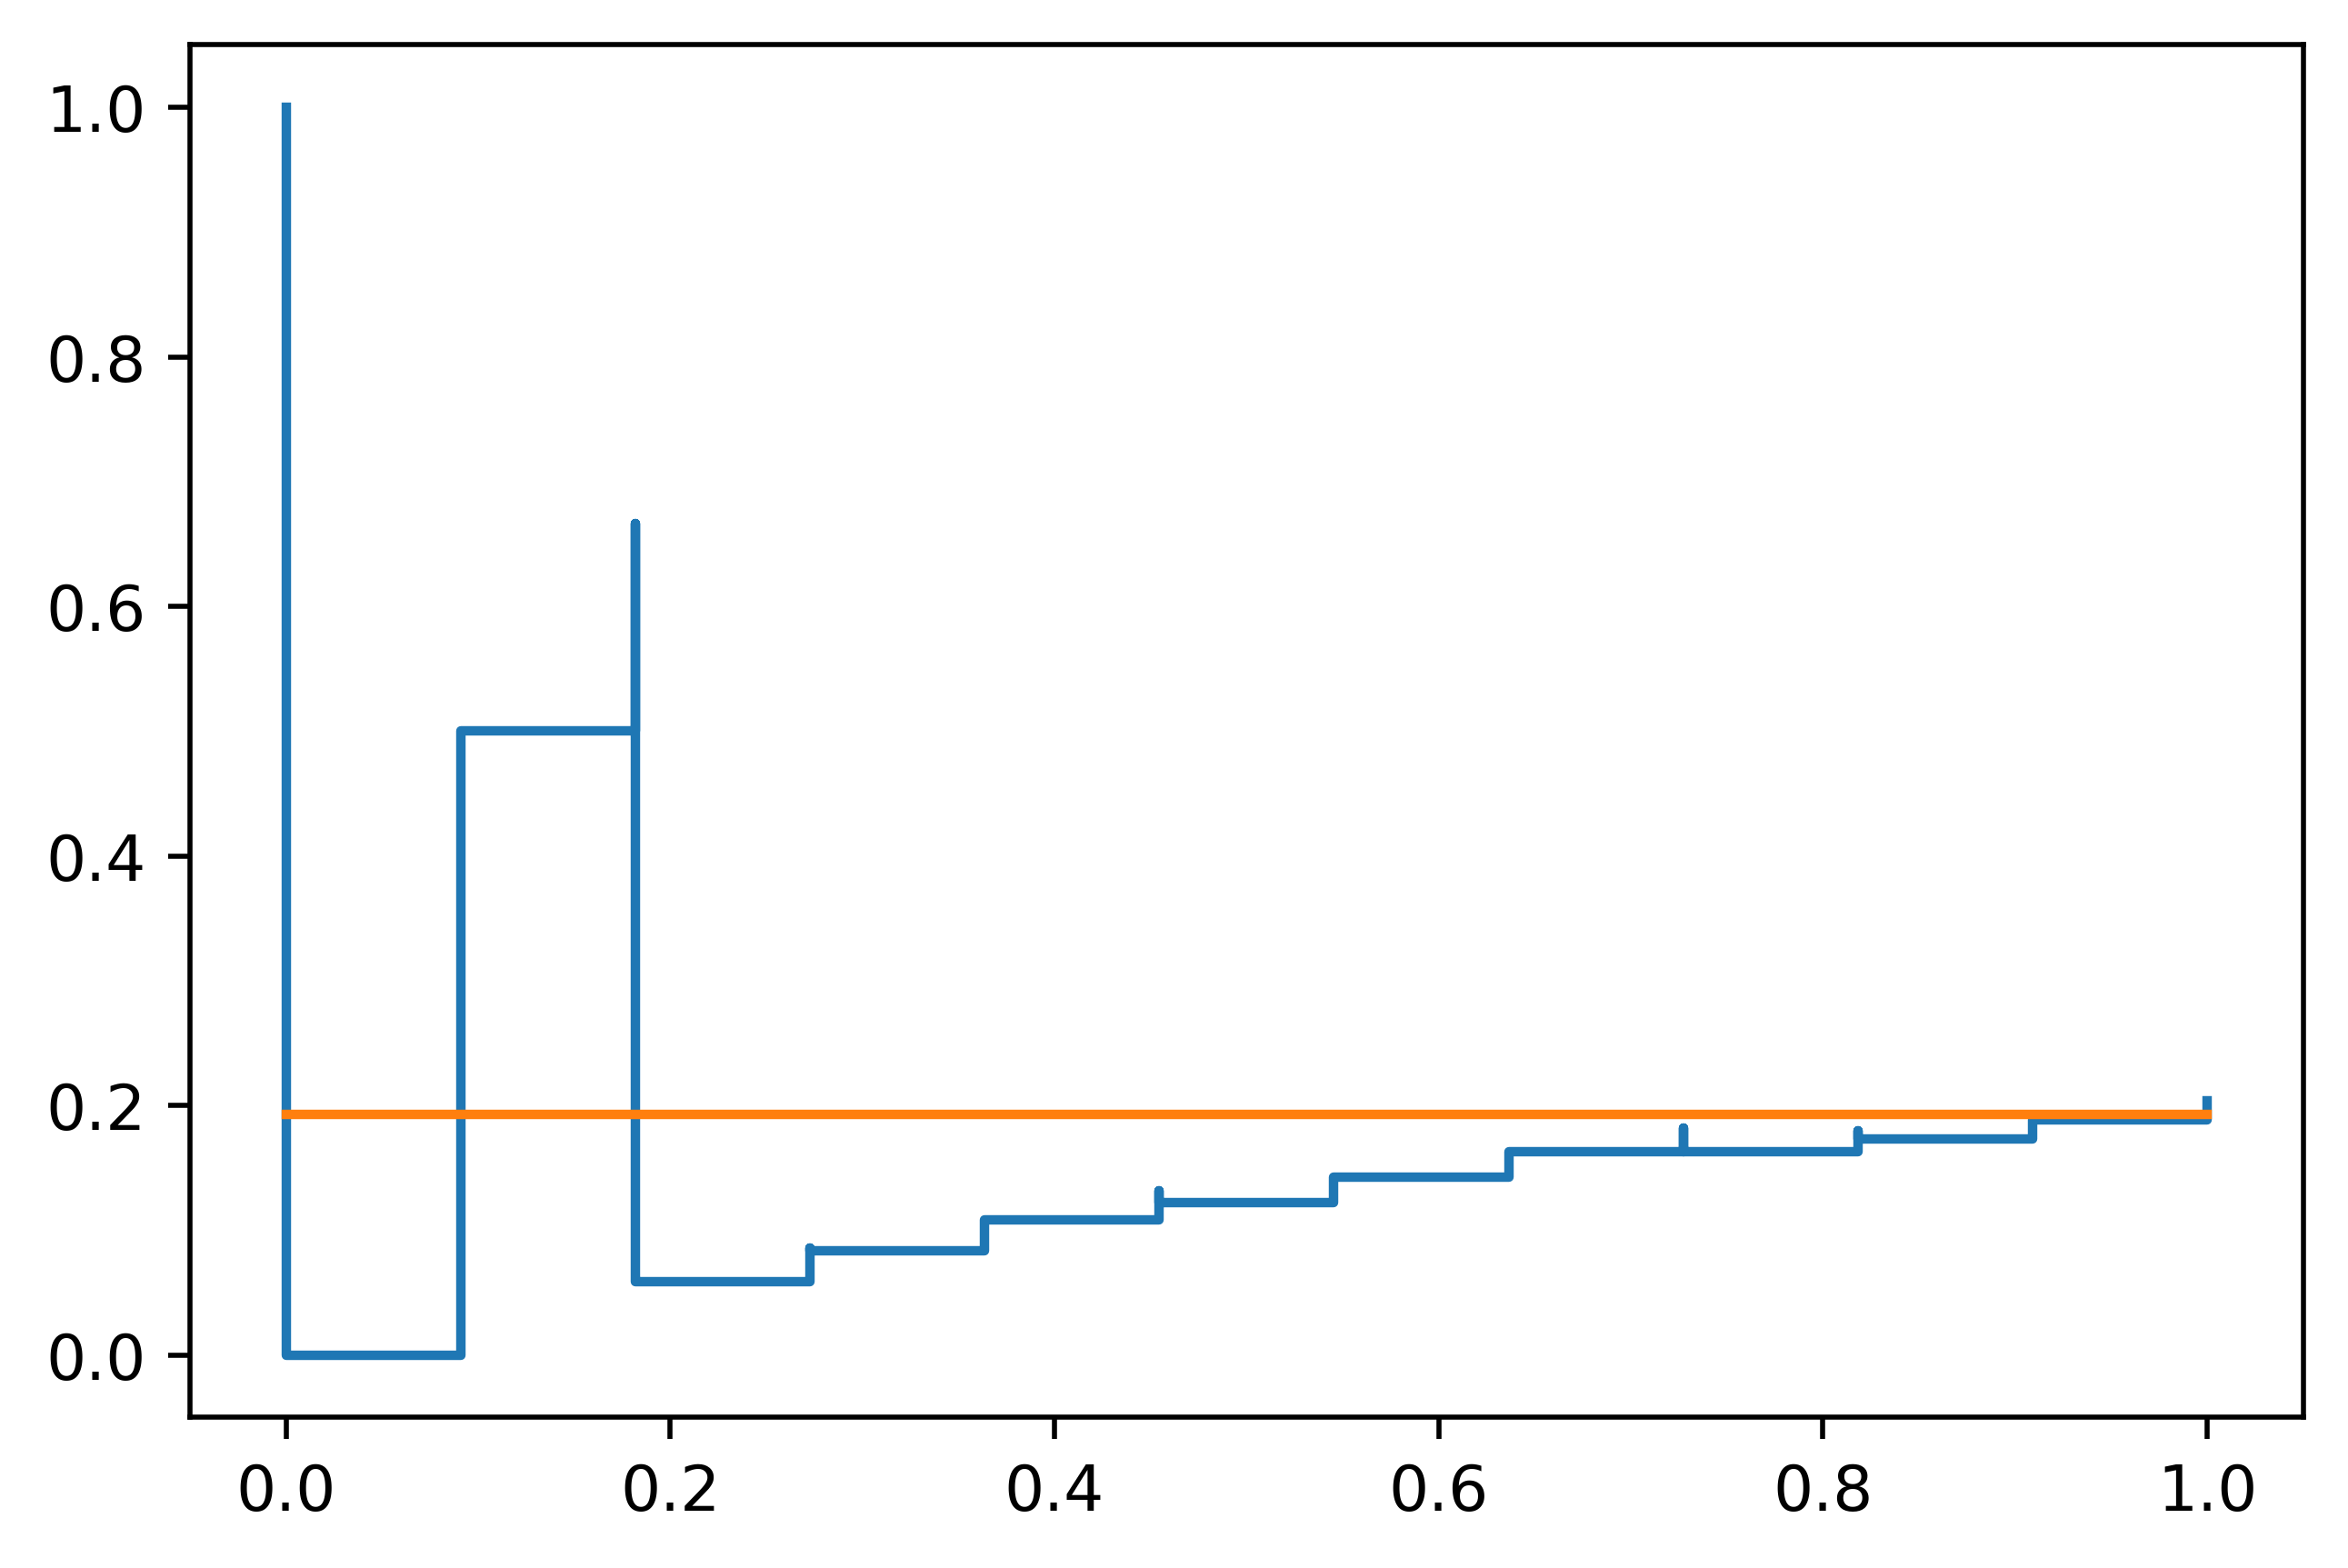

In [142]:

ann = ANN.NN_LogitLogit()

ann.train(X_train,y_train,epoch_ypred=False)

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train,y_train,ann,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))

plt.scatter(y_true,y_test_pred)
plt.plot([0,1],[0,1])
plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)

plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

print(auc)


training error:  0.19298245614035087
0.4290024148667811


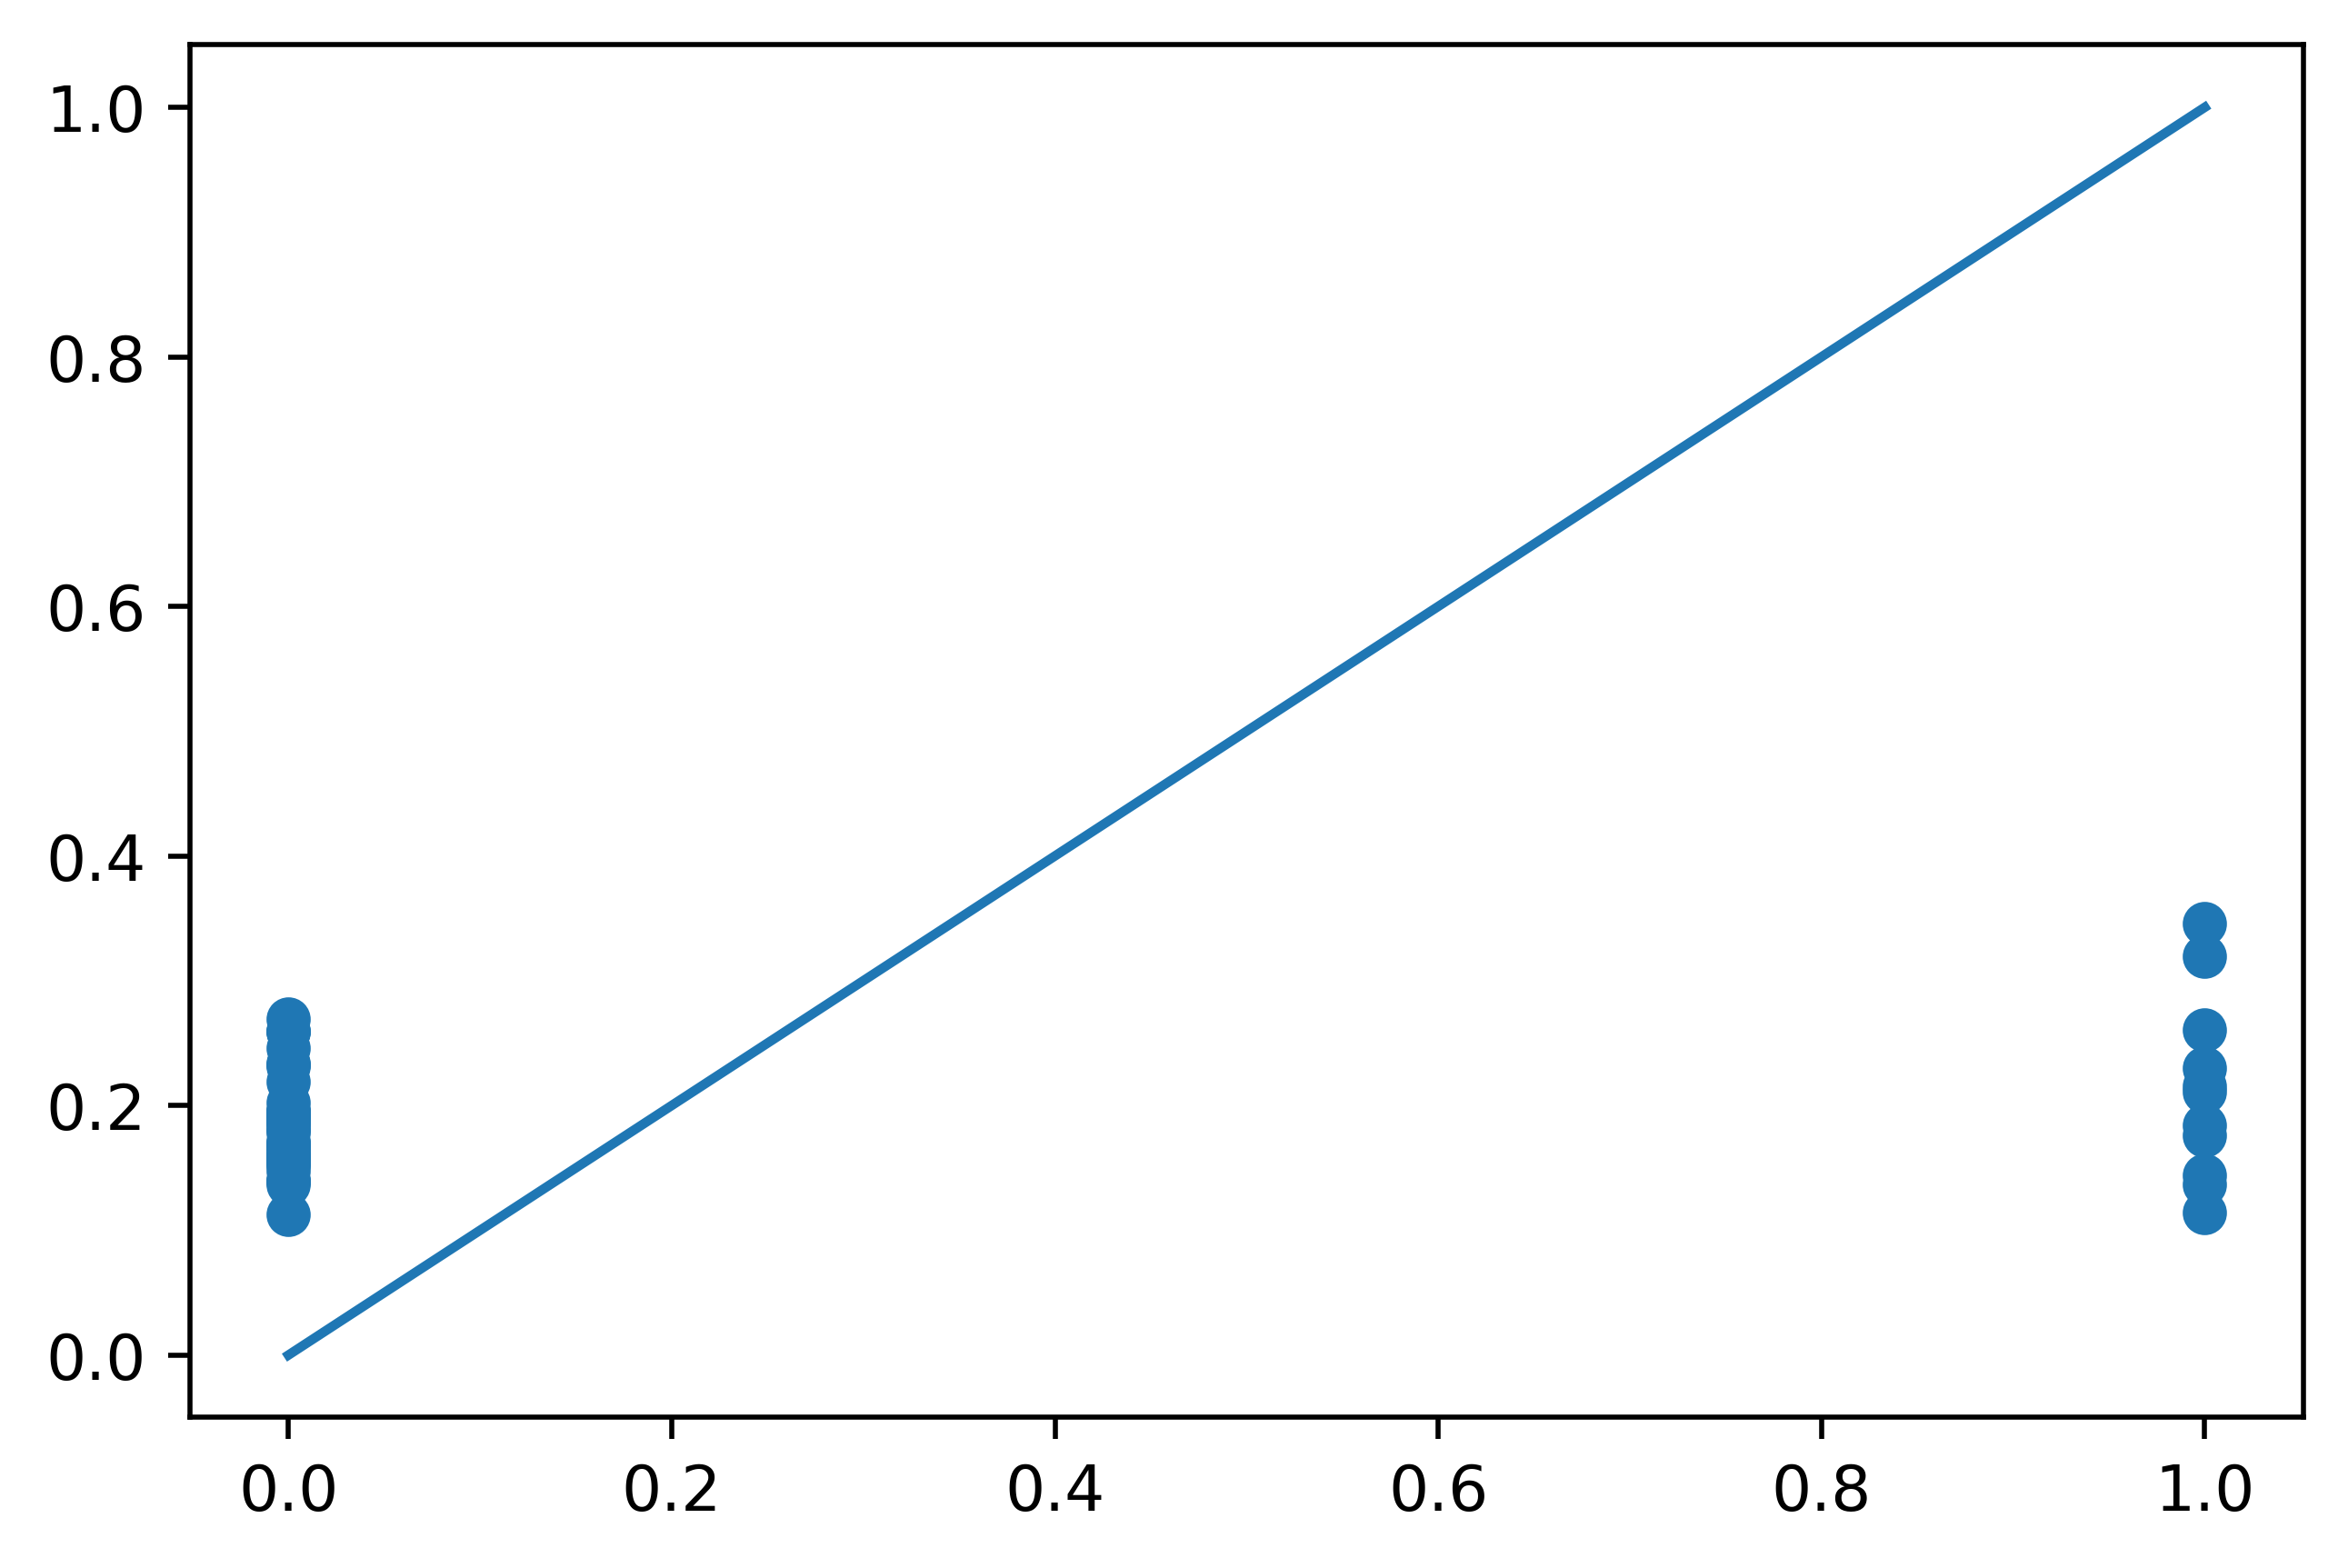

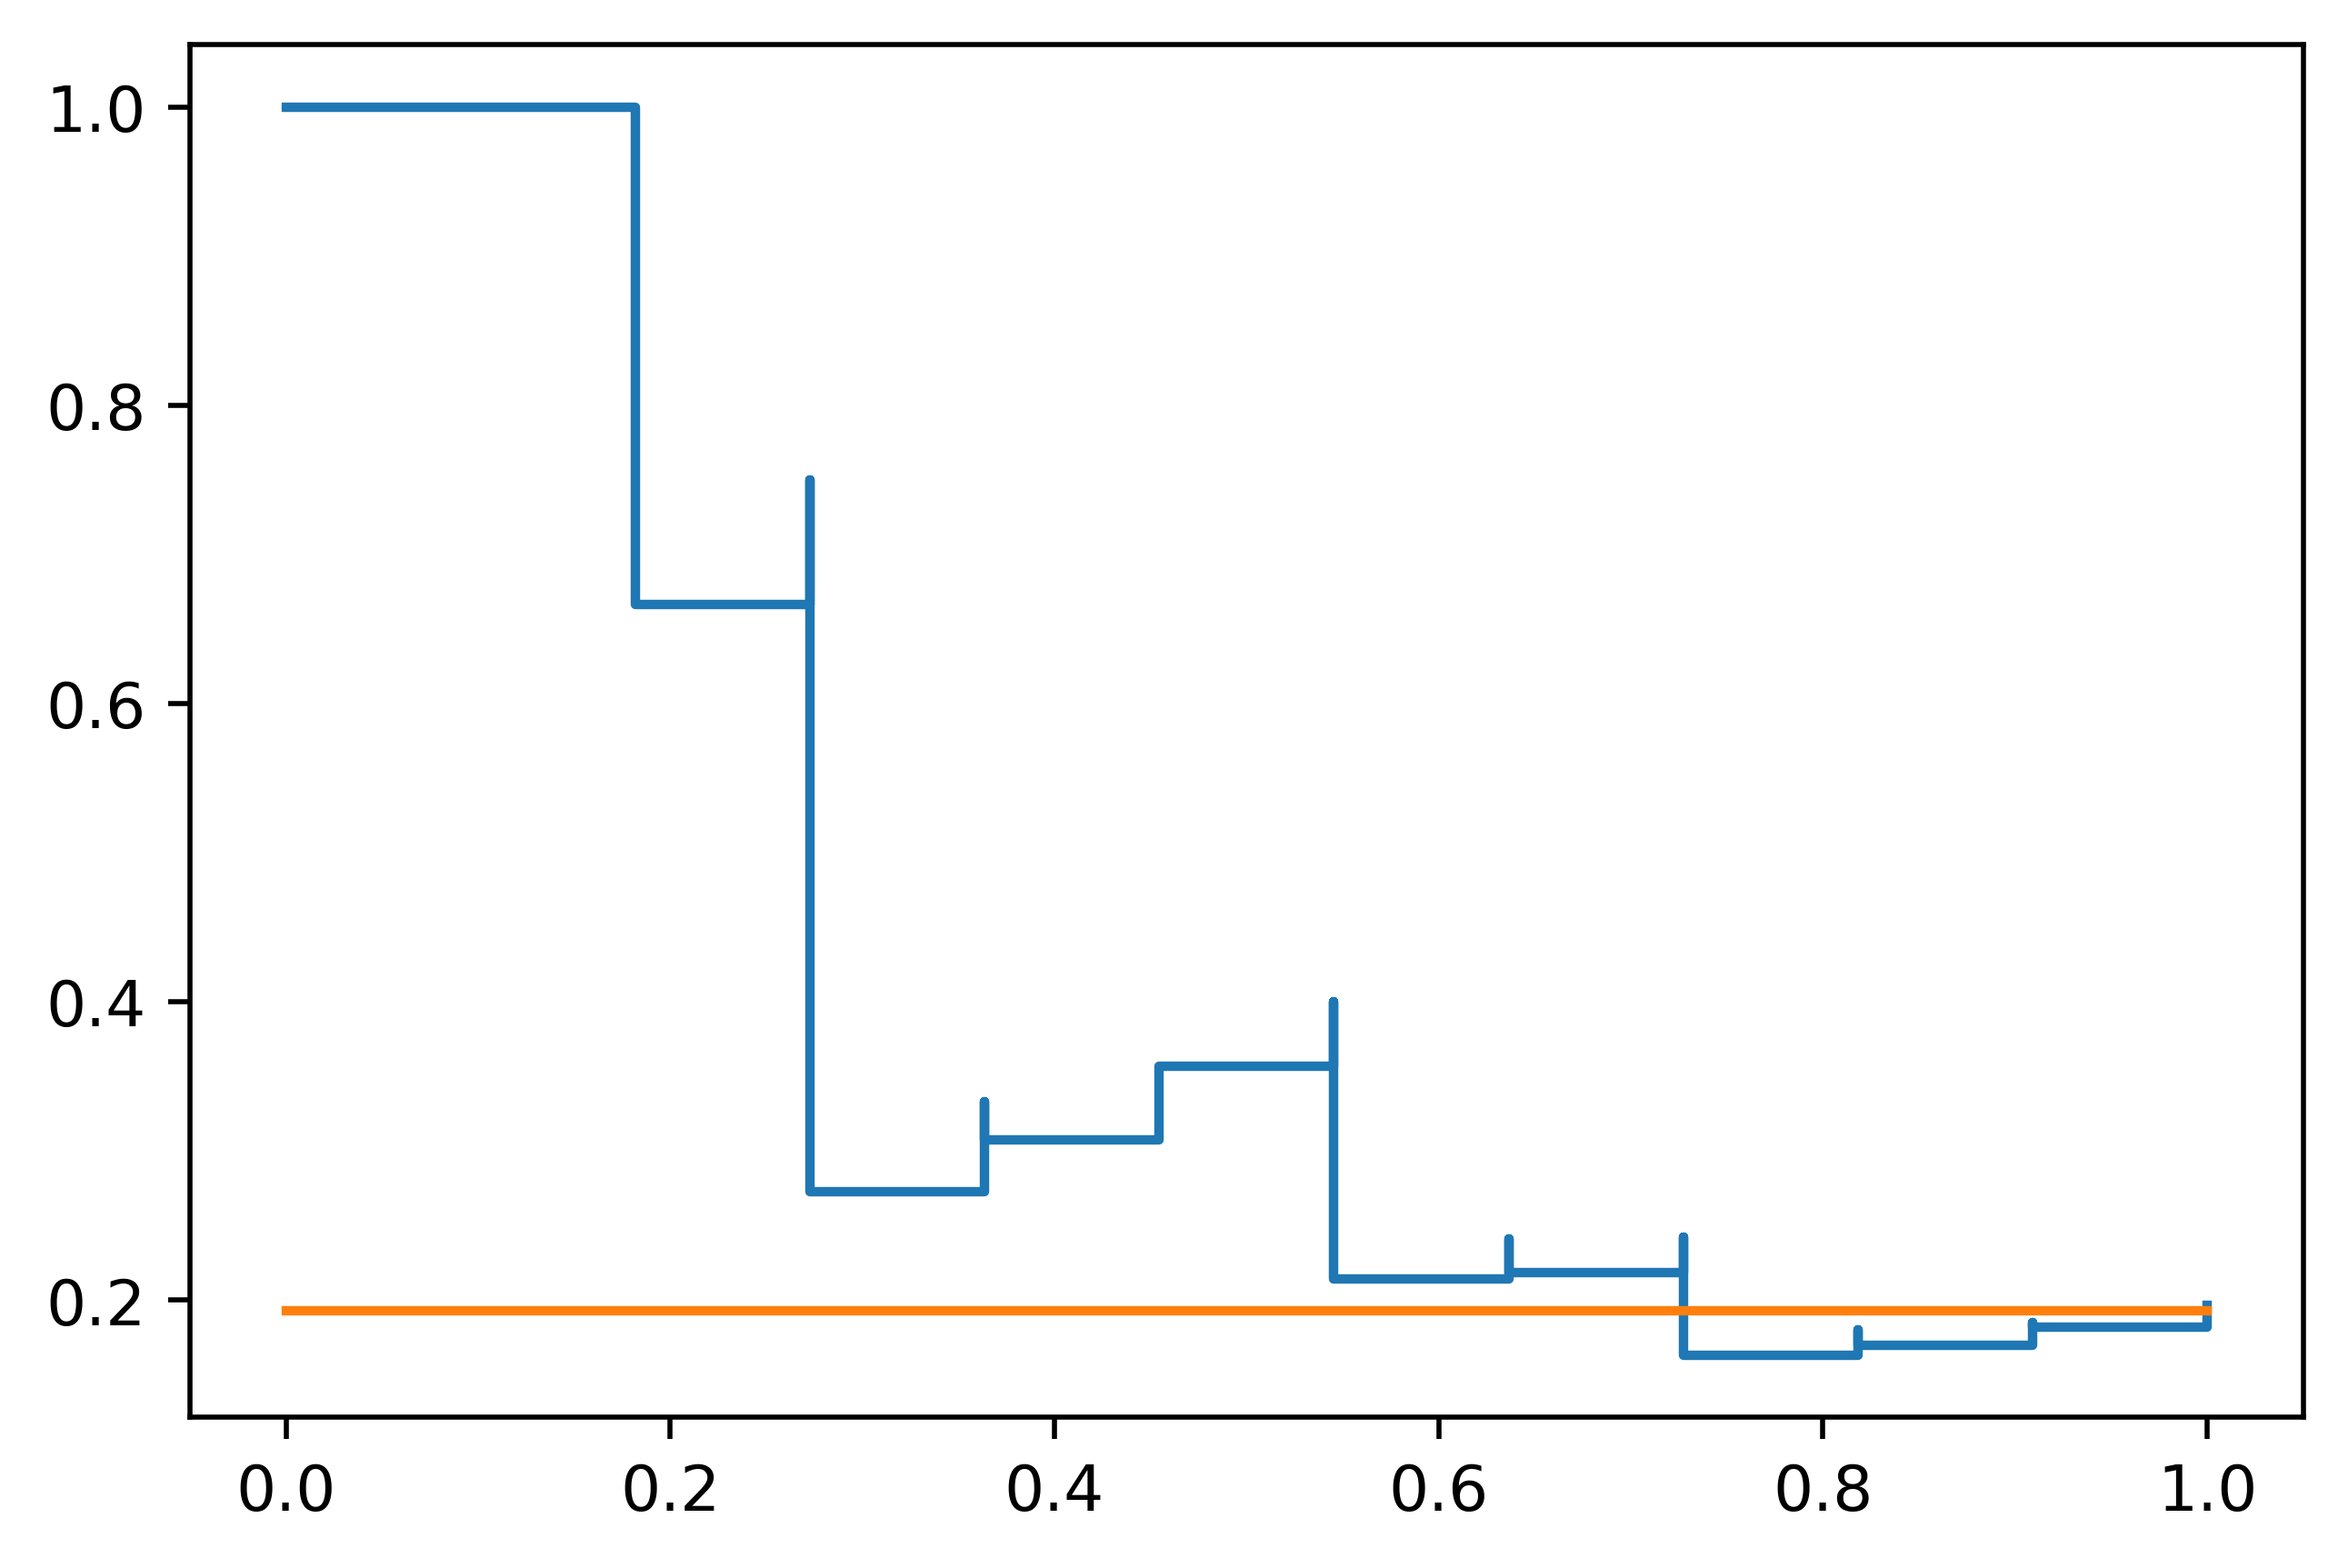

In [213]:
X_train_sig = X_train[:,sigMet]
reg = LogisticRegression(fit_intercept=True,max_iter=1e4)
reg.fit(X_train_sig,y_train)
y_train_pred = reg.predict(X_train_sig)
err_train = float(len([t for p,t in zip(y_train_pred,y_train) if p != t]))/len(y_train)
print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,reg,lambda p,x,y: p.fit(x,y),lambda p,x: p.predict_proba(x)[:,1])

plt.scatter(y_true,y_test_pred)
plt.plot([0,1],[0,1])

plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)
plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])


print(auc)

training error:  0.5808904735665572
0.12119056189657193
training error:  0.3546308258123565
0.1970478537637032
training error:  0.34989582812576964
0.18806392672005523
training error:  0.32993886894301366
0.12169143558270845
training error:  0.3180439971518098
0.11795326043723078
training error:  0.3241217643545385
0.11539631967832858
training error:  0.3198271085295761
0.11107421708738979
training error:  0.3129591481727466
0.11196702609837095
training error:  0.31331977326619
0.11340086302899036
training error:  0.31185588057626756
0.11531490265149694
training error:  0.6257411701637402
0.17106443331182225
training error:  0.4024998226709533
0.1646500430987098
training error:  0.32854527967017993
0.14254388822048478
training error:  0.31902233315141576
0.11676338626692351
training error:  0.3130848232591361
0.12121838089696543
training error:  0.3115186835067314
0.11379863313651005
training error:  0.3107515272864124
0.11594933330870189
training error:  0.311205298492783
0.1168976911

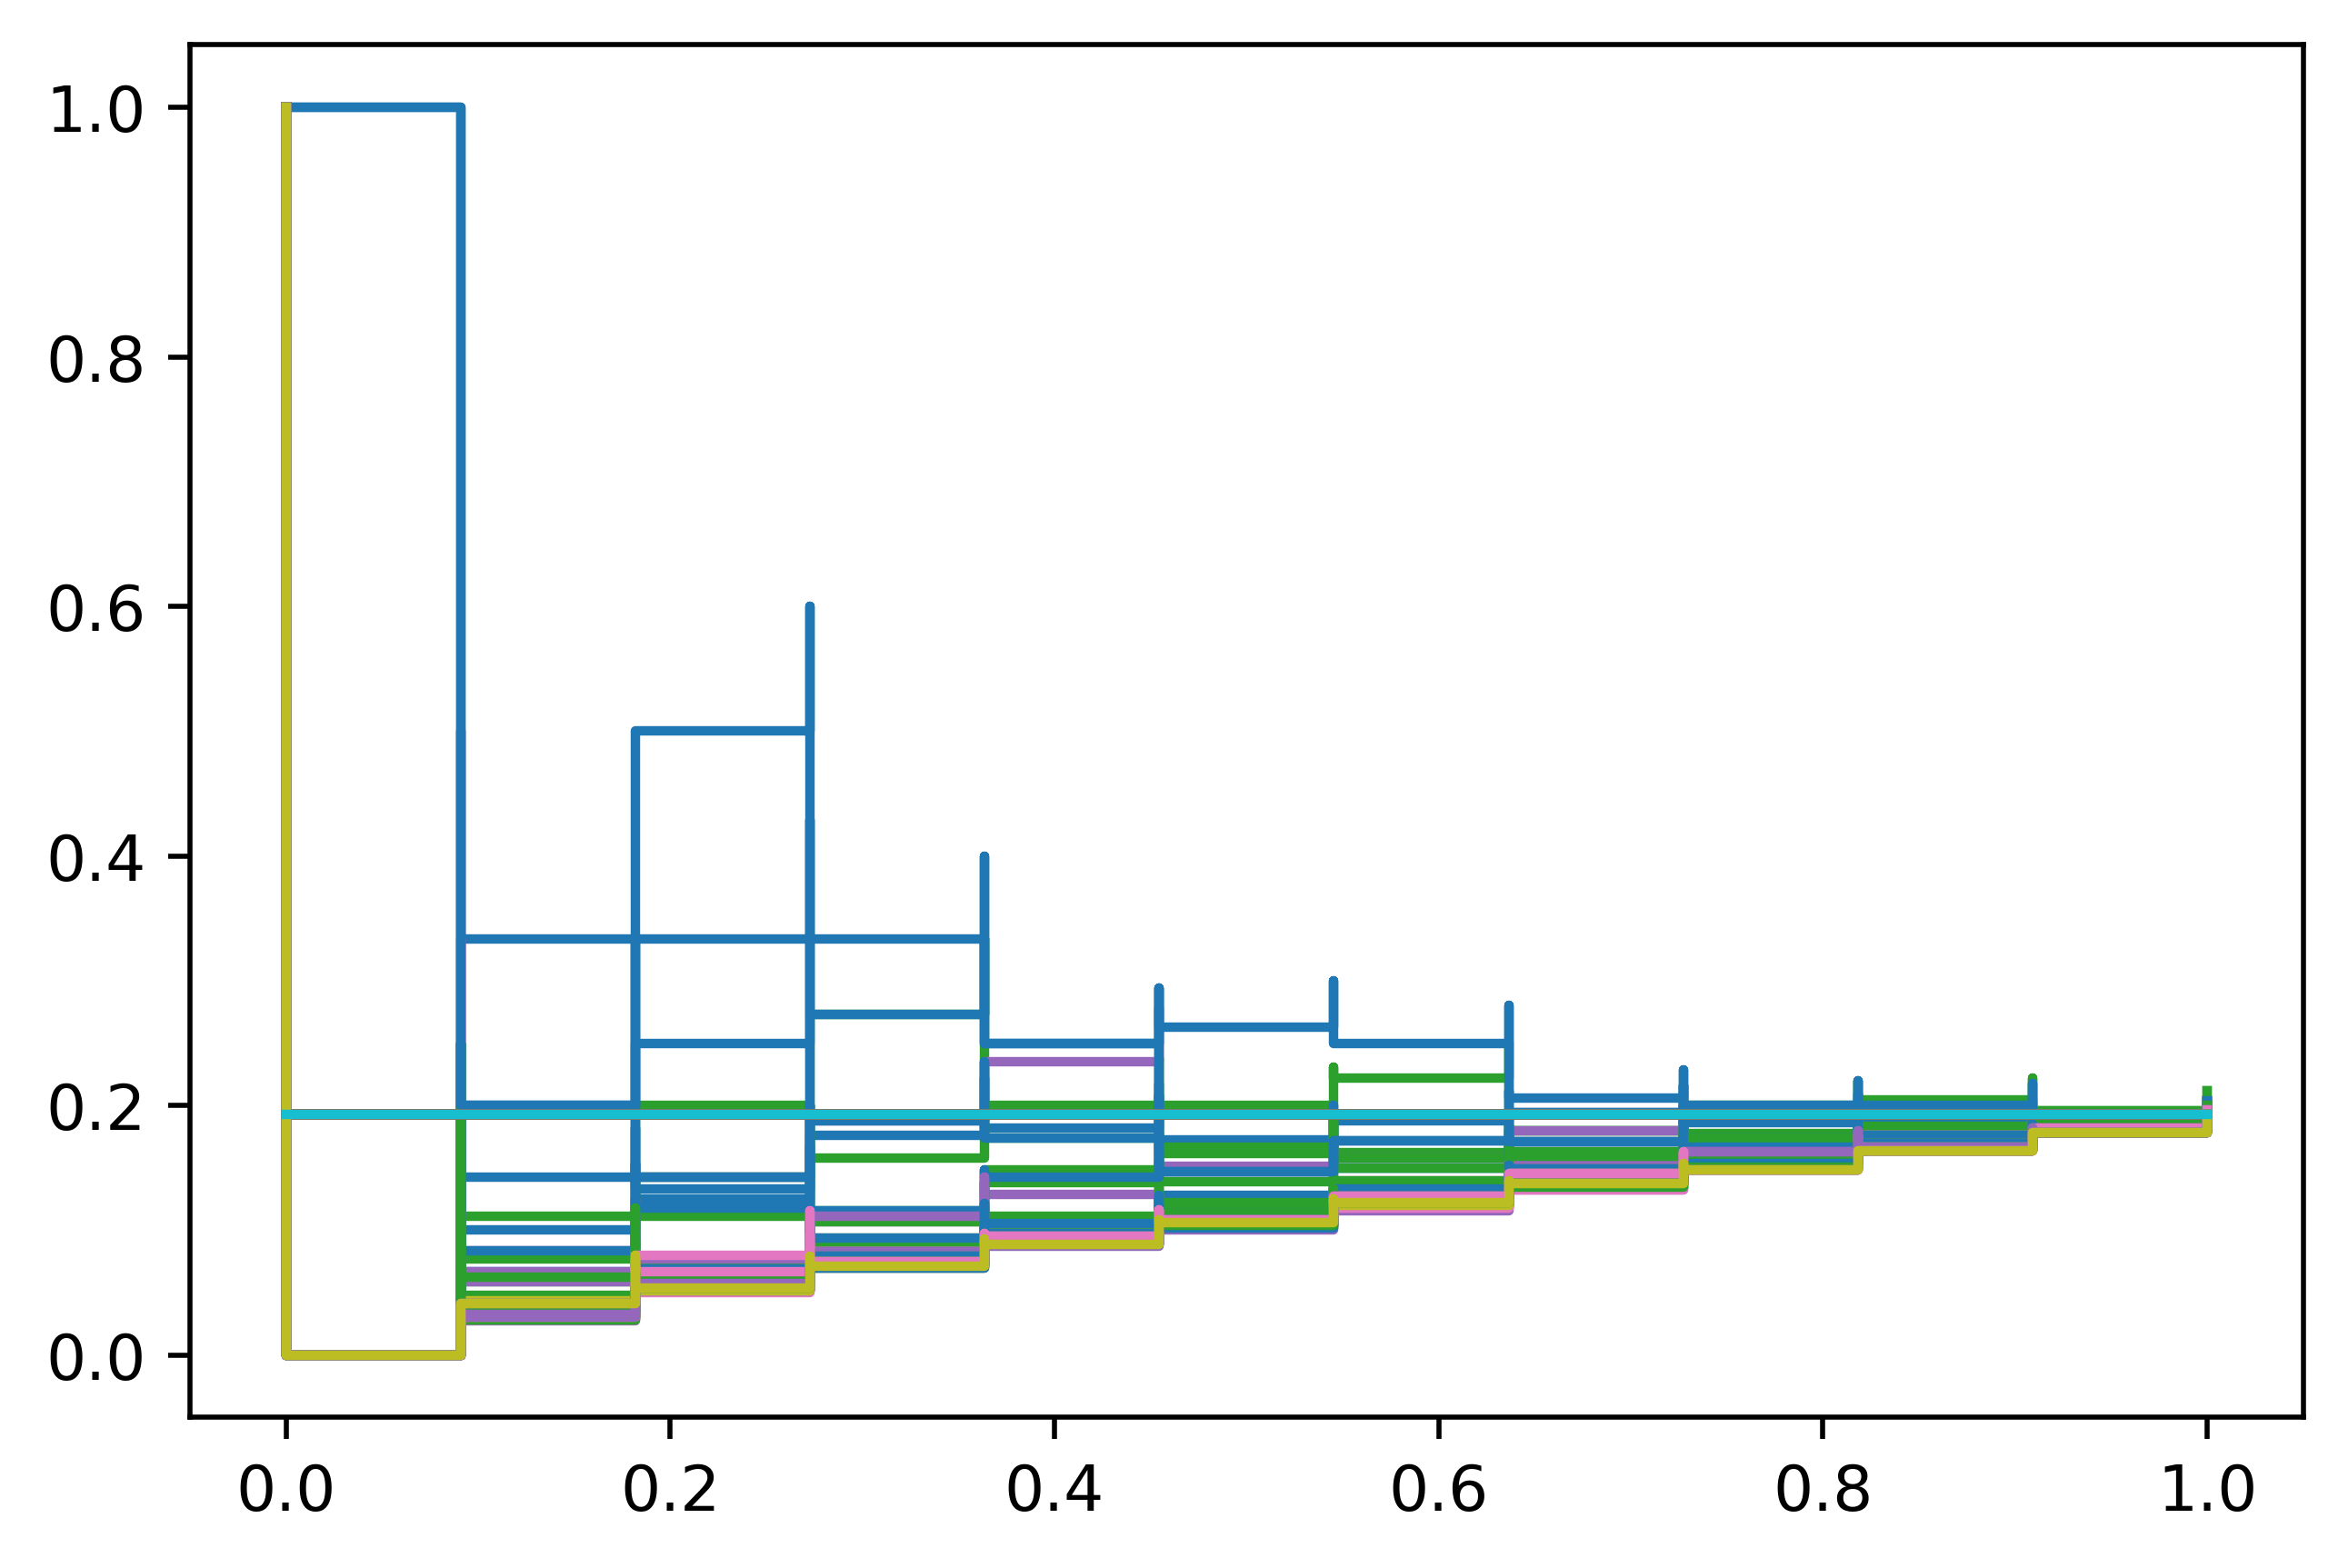

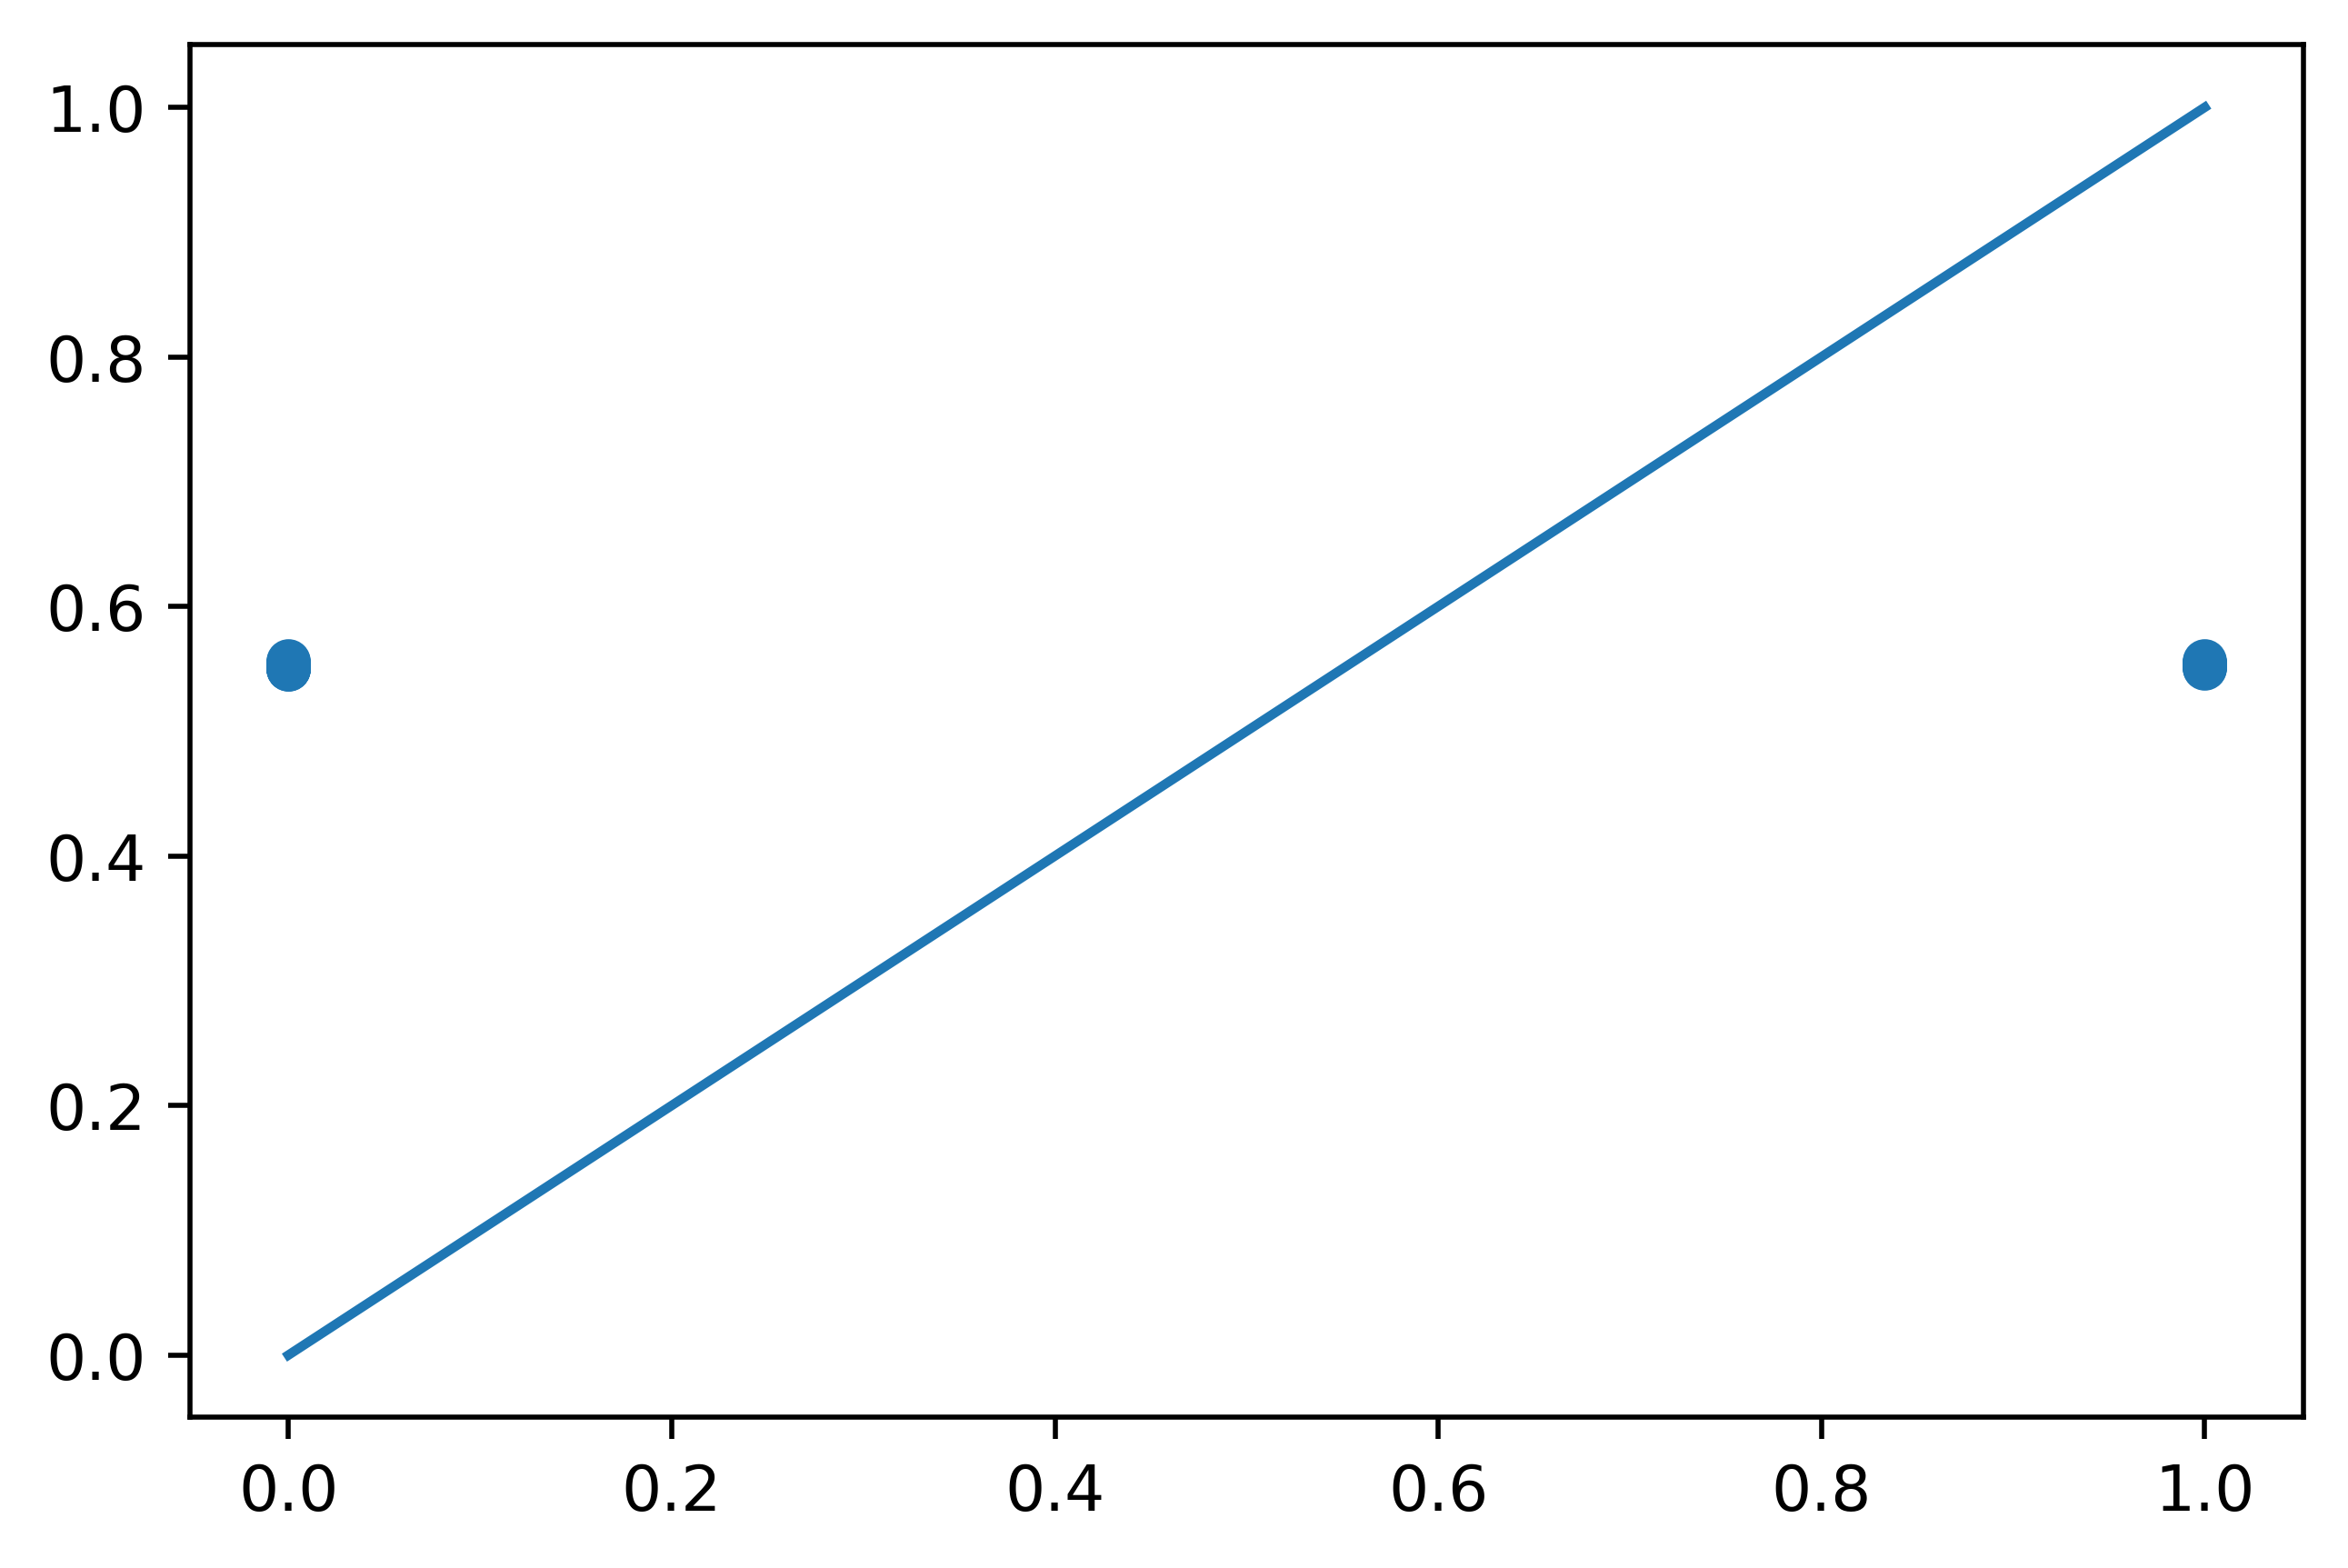

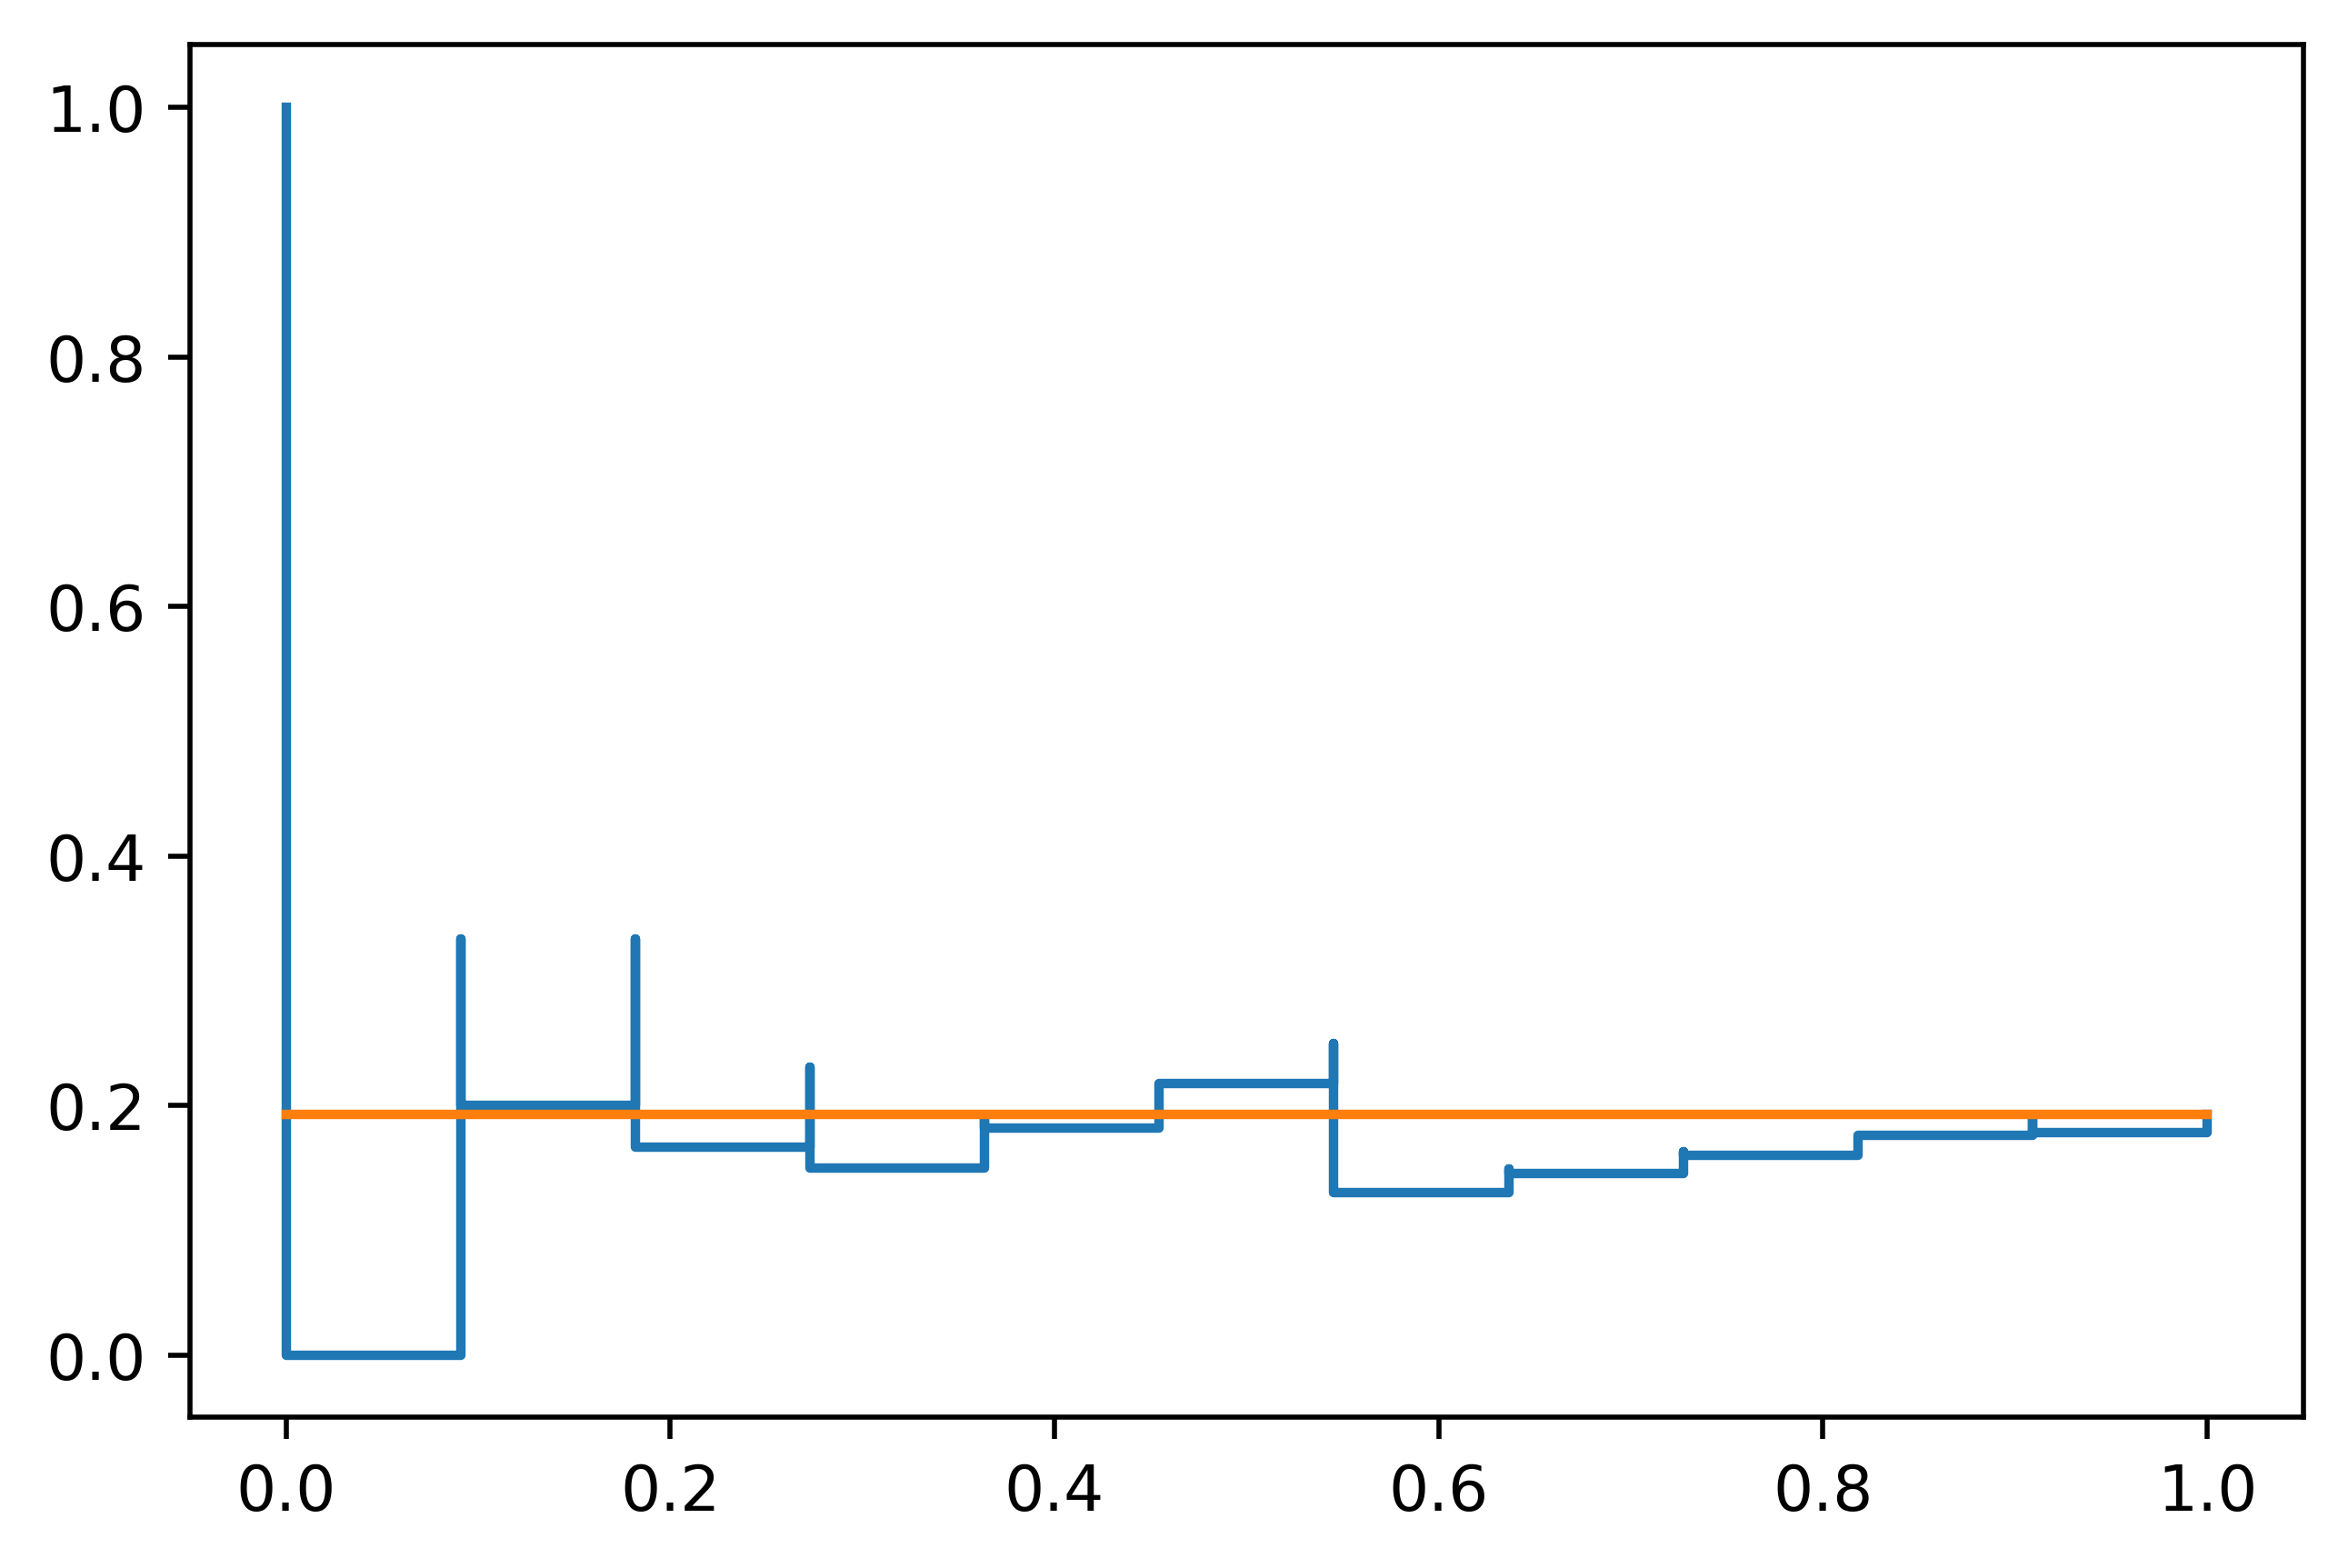

In [144]:
# n_neurons=2, epochs=200, learning_rate=0.01, momentum=0.0, decay=0.0,
results = {}
for nn in range(2,10):
    for lr in np.linspace(0.001,0.1,10):
        ann = ANN.NN_LogitLogit(n_neurons=nn,learning_rate=lr)

        ann.train(X_train_sig,y_train,epoch_ypred=False)

        y_train_pred = ann.test(X_train_sig)

        err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
        print("training error: ",err_train)

        r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,ann,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))

        prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
        plt.step(recall,prec)
        auc = sklearn.metrics.auc(recall,prec)

        plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

        print(auc)
        results[(nn,lr)] = auc
        
plt.figure()

maxAuc = np.max(list(results.values()))
nn,lr = [x for x in results.keys() if abs(results[x]-maxAuc) < 1e-3][0]
print(nn,lr)
ann = ANN.NN_LogitLogit(n_neurons=nn,learning_rate=lr)

ann.train(X_train_sig,y_train,epoch_ypred=False)

y_train_pred = ann.test(X_train_sig)

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
print("training error: ",err_train)

plt.scatter(y_train,y_train_pred)
plt.plot([0,1],[0,1])
plt.figure()

r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,ann,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))


prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)

plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

print(auc)


0.5858448348612596
0.6098630681136659
0.6207258179285416
0.6163425997650597
0.5790519435311808
0.5523477303342587
0.5497823424741912
3
training error:  0.10526315789473684
cross_val_error:  0.14035087719298245
0.6976444608023555


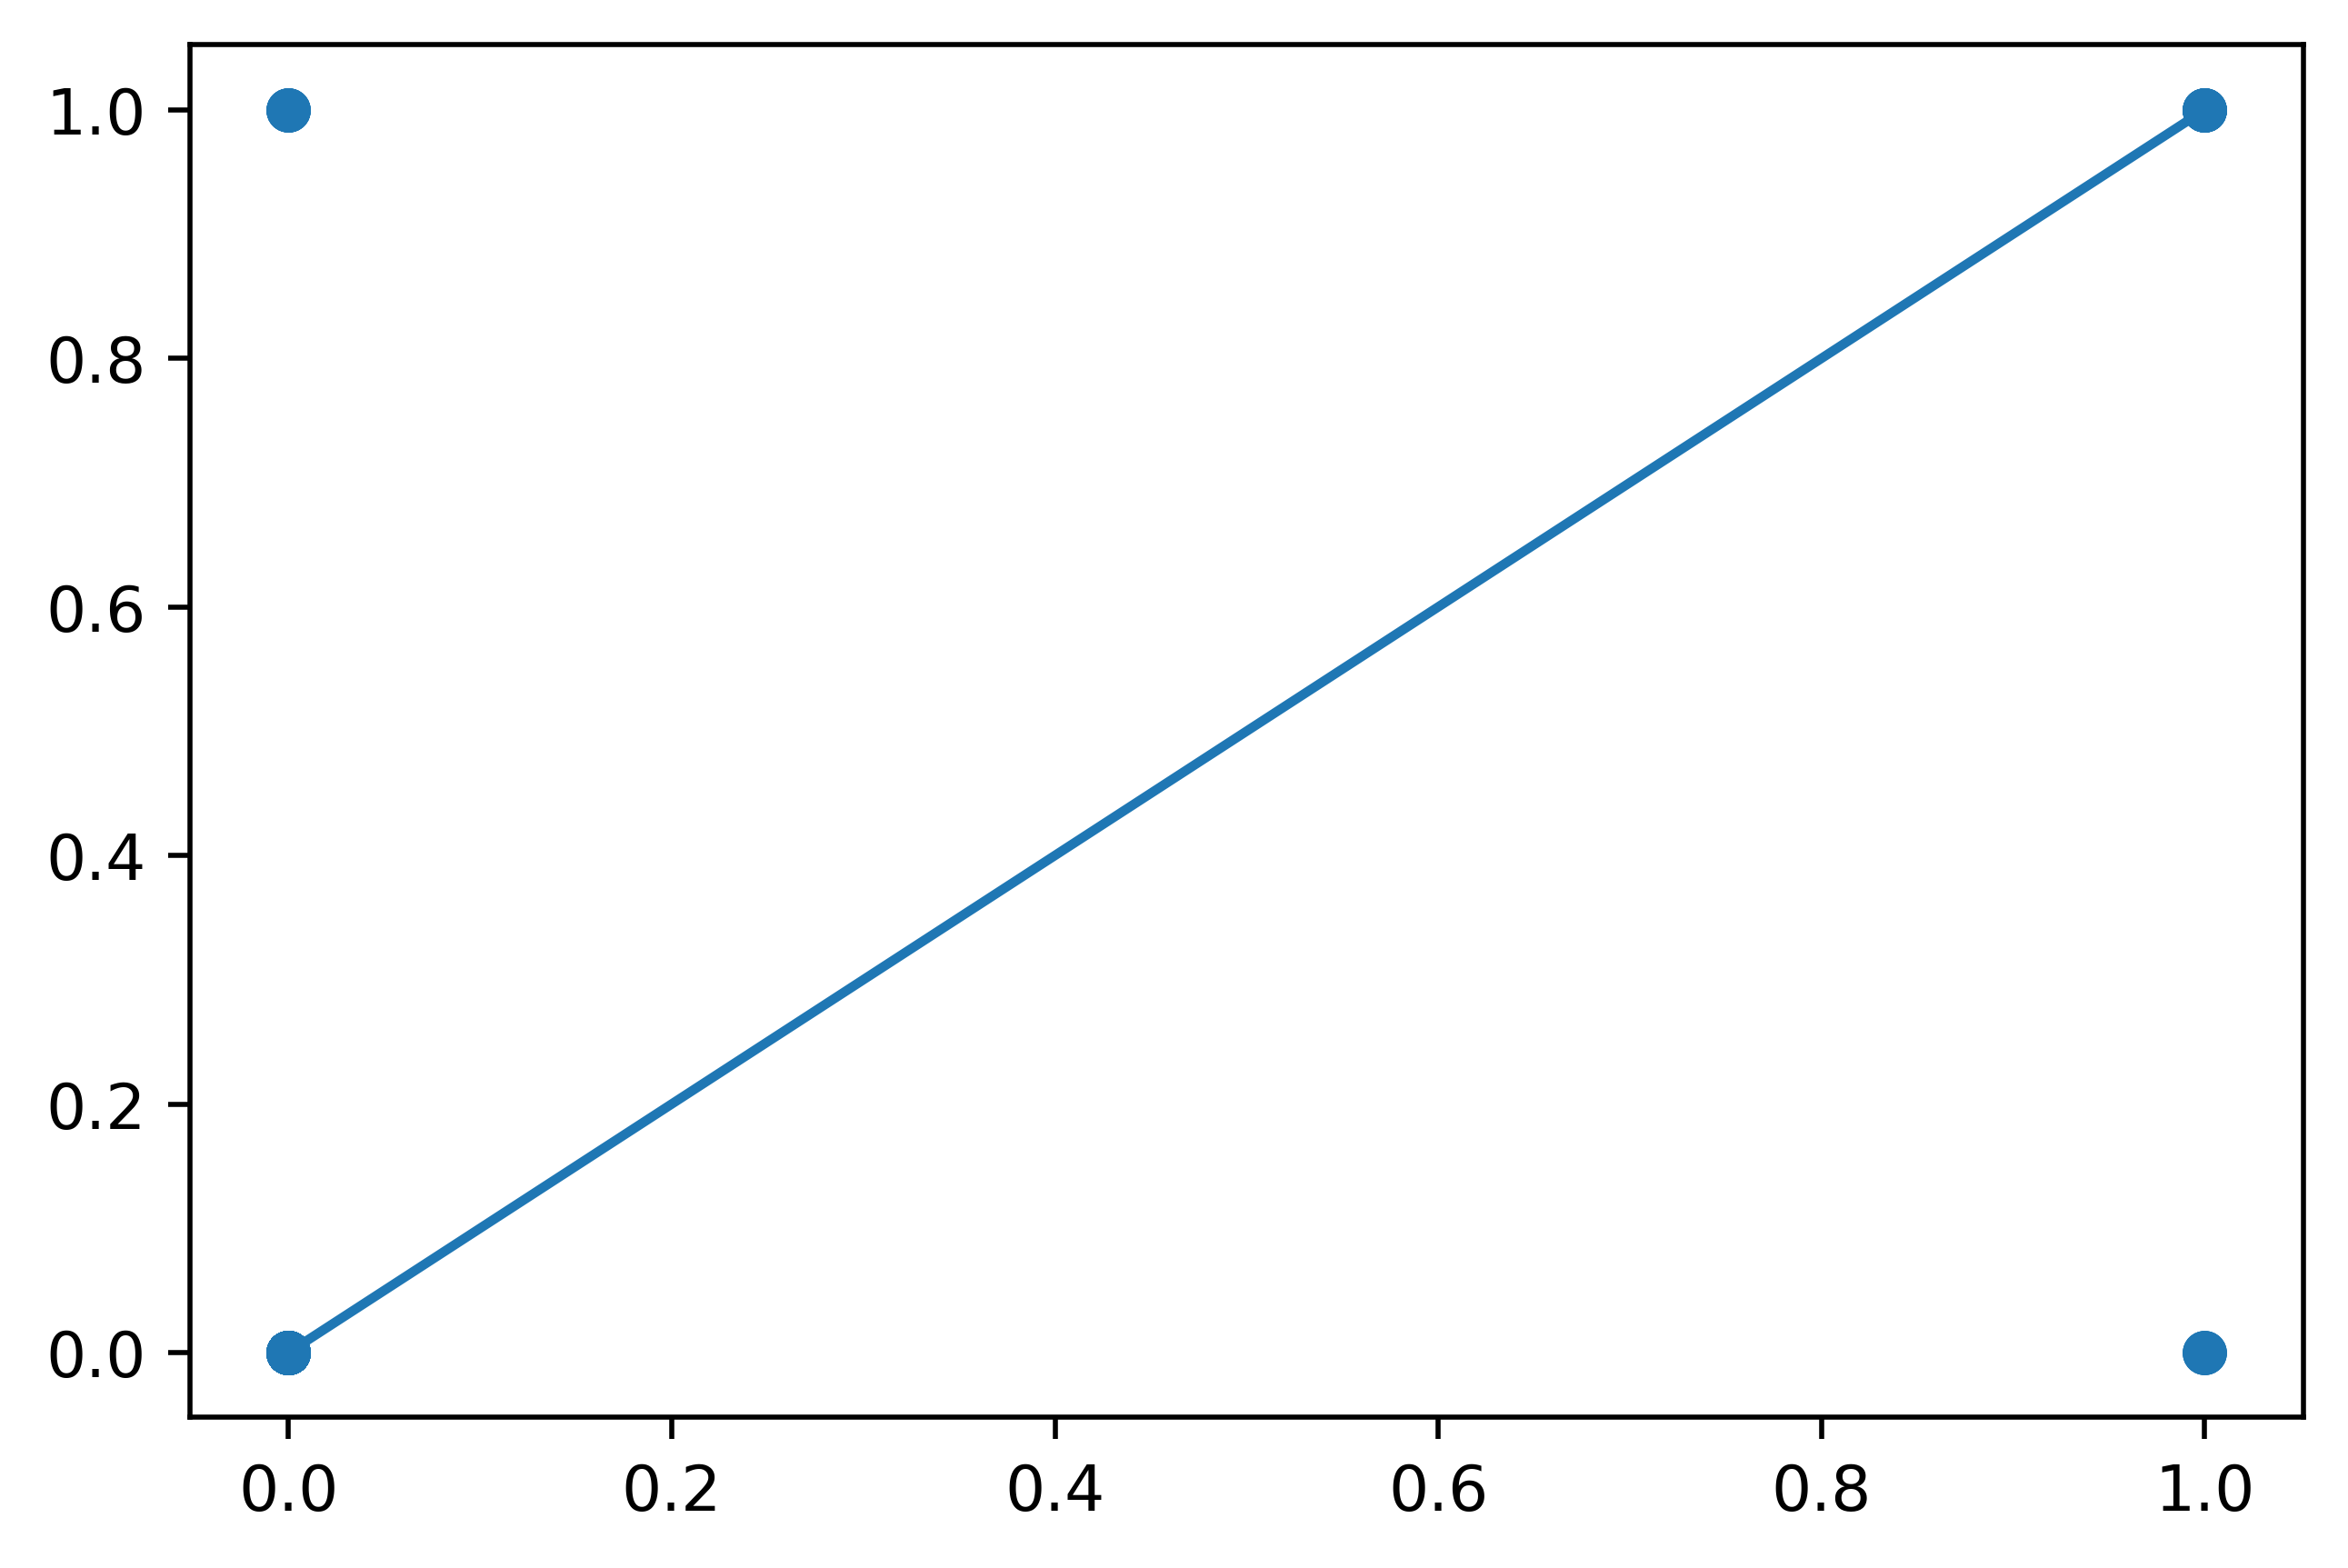

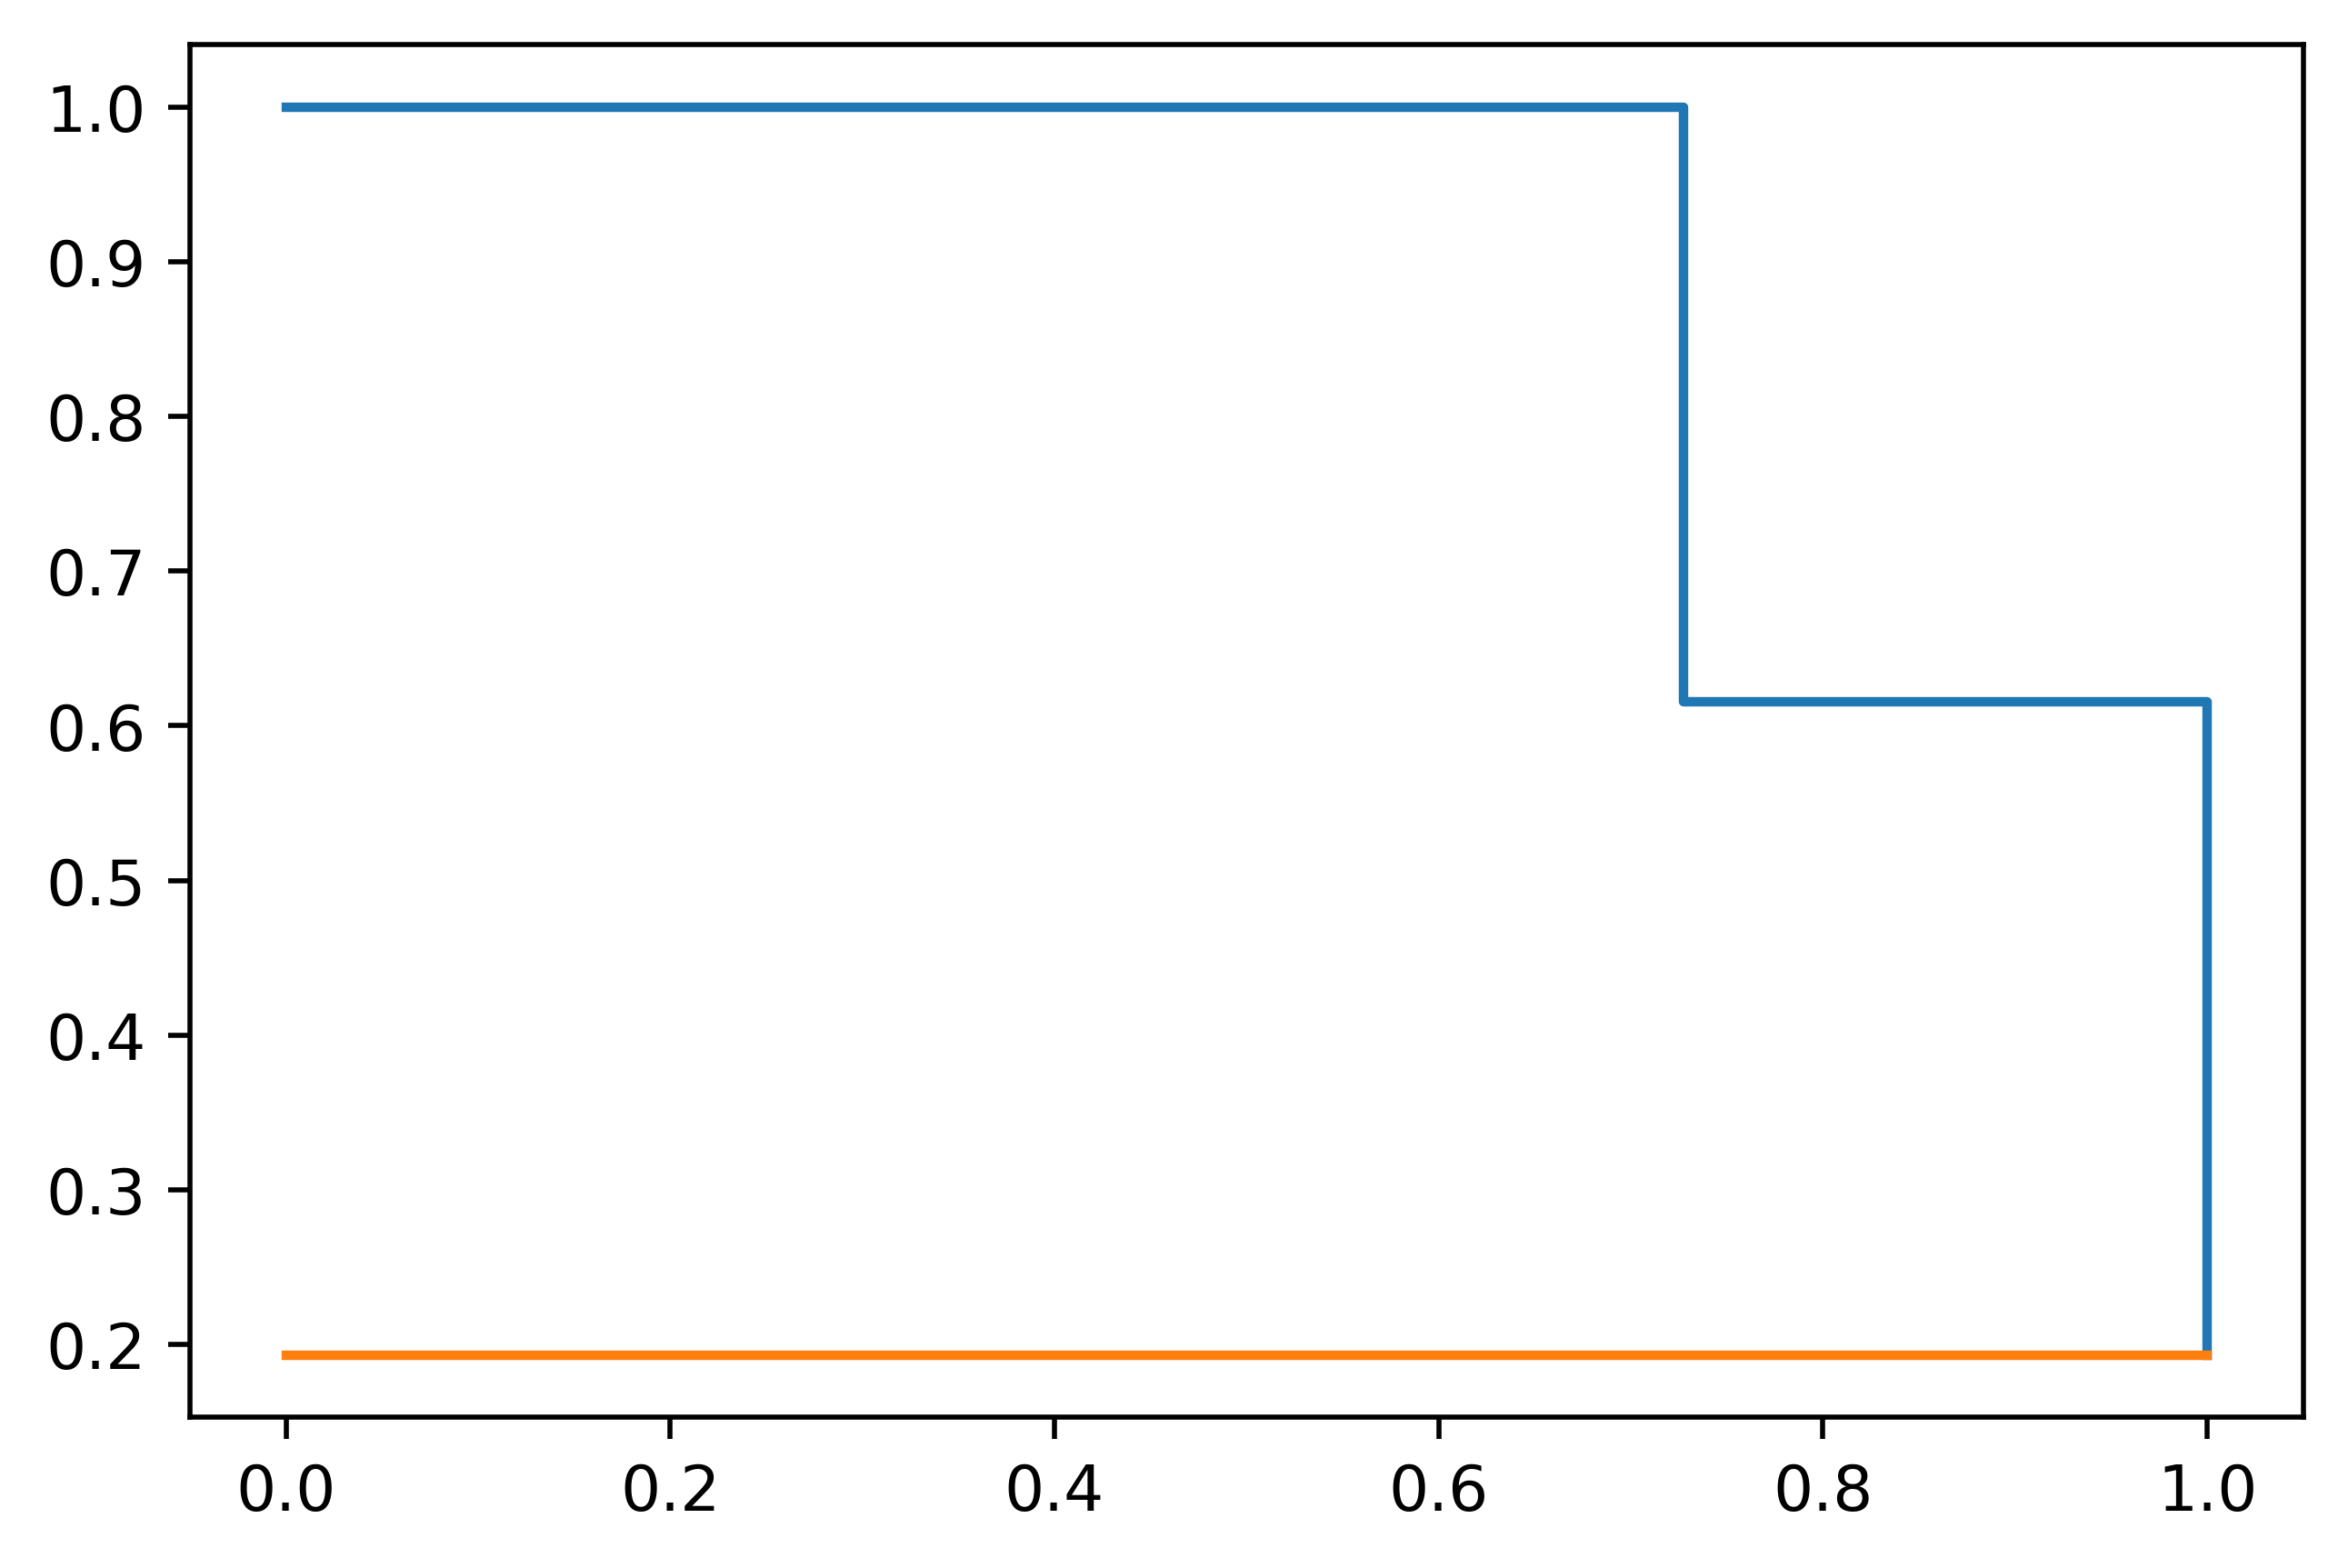

In [214]:
result = {}
for nc in range(1,len(sigMet)):
    pls = PLSDA(n_components=nc)

    pls.train(X_train_sig,y_train)

    y_train_pred = pls.test(X_train_sig)

    err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
    #print("training error: ",err_train)

    r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,pls,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))

    prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,y_test_pred)
    auc = sklearn.metrics.auc(recall,prec)
    print(auc)
    result[nc] = auc

maxAuc = np.max(list(result.values()))
nc = [x for x in result if result[x] == maxAuc][0]

print(nc)
    
pls = PLSDA(n_components=nc)

pls.train(X_train_sig,y_train)

y_train_pred = pls.test(X_train_sig)

logClass = LogisticRegression(fit_intercept=True,max_iter=1e4)

logClass.fit([[x] for x in y_train_pred],y_train,sample_weight = sampleWeights)

y_train_pred = logClass.predict([[x] for x in y_train_pred])

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)

print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,pls,lambda p,x,y: p.train(x,y),lambda p,x: p.test(x))

y_test_pred = logClass.predict([[x] for x in y_test_pred])

plt.scatter(y_true,y_test_pred)
plt.plot([0,1],[0,1])
plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_true,logClass.predict_proba([[x] for x in y_test_pred])[:,1])
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)
plt.plot([0,1],[np.sum(y_true)/len(y_true),np.sum(y_true)/len(y_true)])

err_val = np.sum(np.abs(np.subtract(y_true,y_test_pred)))/len(y_true)
print("cross_val_error: ",err_val)

print(auc)




In [146]:
results = {}
for n_est in [1,10,100,1000]:
    for md in [2,5,10,None]:
        for mf in ["auto","sqrt","log2",int(len(sigMet)/2)]:            
            rf = RandomForestClassifier(max_features=mf,max_depth=md,n_estimators = n_est)

            rf.fit(X_train_sig,y_train)

            y_train_pred = rf.predict(X_train_sig)

            err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
            #print("training error: ",err_train)
            
            r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,rf,lambda p,x,y: rf.fit(x,y),lambda p,x: rf.predict(x))

            errVal = np.sum(np.abs(np.subtract(y_true,y_test_pred)))/len(y_true)
            print("cross_val error: ",errVal)
            
            results[(n_est,md,mf)] = errVal

maxVal = np.min(list(results.values()))
n_est,md,mf = [x for x in results.keys() if abs(results[x]-maxVal) < 1e-3][0]           
print(maxVal)
rf = RandomForestClassifier(max_features=mf,max_depth=md,n_estimators = n_est)

rf.fit(X_train_sig,y_train)

y_train_pred = rf.predict(X_train_sig)

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)
print("training error: ",err_train)

r2,y_test_pred,y_true = looCrossVal(X_train_sig,y_train,rf,lambda p,x,y: rf.fit(x,y),lambda p,x: rf.predict(x))

errVal = np.sum(np.abs(np.subtract(y_true,y_test_pred)))/len(y_true)
print("cross_val error: ",errVal)



cross_val error:  0.24561403508771928
cross_val error:  0.15789473684210525
cross_val error:  0.12280701754385964
cross_val error:  0.19298245614035087
cross_val error:  0.22807017543859648
cross_val error:  0.24561403508771928
cross_val error:  0.22807017543859648
cross_val error:  0.2807017543859649
cross_val error:  0.3684210526315789
cross_val error:  0.2631578947368421
cross_val error:  0.15789473684210525
cross_val error:  0.19298245614035087
cross_val error:  0.21052631578947367
cross_val error:  0.24561403508771928
cross_val error:  0.22807017543859648
cross_val error:  0.21052631578947367
cross_val error:  0.14035087719298245
cross_val error:  0.17543859649122806
cross_val error:  0.14035087719298245
cross_val error:  0.15789473684210525
cross_val error:  0.15789473684210525
cross_val error:  0.15789473684210525
cross_val error:  0.17543859649122806
cross_val error:  0.19298245614035087
cross_val error:  0.17543859649122806
cross_val error:  0.14035087719298245
cross_val error

In [218]:
####move onto test set

nc = 2
    
pls = PLSDA(n_components=nc)

pls.train(X_train_sig,y_train)

y_train_pred = pls.test(X_train_sig)

logClass = LogisticRegression(fit_intercept=True,max_iter=1e4)

logClass.fit([[x] for x in y_train_pred],y_train,sample_weight = sampleWeights)

y_train_pred = logClass.predict([[x] for x in y_train_pred])

err_train = np.sum(np.abs(np.subtract(y_train,y_train_pred)))/len(y_train)

print("training error: ",err_train)

print(sklearn.metrics.confusion_matrix(y_train,y_train_pred))

y_test_pred = pls.test(X_test[:,sigMet])

y_test_pred = logClass.predict([[x] for x in y_test_pred])

plt.scatter(y_test,y_test_pred)
plt.plot([0,1],[0,1])
plt.figure()

prec,recall,thres = sklearn.metrics.precision_recall_curve(y_test,logClass.predict_proba([[x] for x in y_test_pred])[:,1])
plt.step(recall,prec)
auc = sklearn.metrics.auc(recall,prec)
plt.plot([0,1],[np.sum(y_test)/len(y_test),np.sum(y_test)/len(y_test)])

err_test = np.sum(np.abs(np.subtract(y_test,y_test_pred)))/len(y_test)
print("test_error: ",err_test)

print(sklearn.metrics.confusion_matrix(y_test,y_test_pred))
print(auc)

perm_test_results = []

for _ in range(100):
    order = list(range(len(y_train)))
    rd.shuffle(order)
    y_suff = [y_train[x] for x in order]
    sample_weight_shuff = [sampleWeights[x] for x in order]

    pls.train(X_train_sig,y_suff)
    y_train_pred = pls.test(X_train_sig)
    logClass = LogisticRegression(fit_intercept=True,max_iter=1e4)
    logClass.fit([[x] for x in y_train_pred],y_suff,sample_weight = sample_weight_shuff)


    y_test_pred = pls.test(X_test[:,sigMet])
    y_test_pred = logClass.predict([[x] for x in y_test_pred])

    perm_test_results.append(np.sum(np.abs(np.subtract(y_test,y_test_pred)))/len(y_test))

plt.figure()

plt.hist(perm_test_results)
plt.plot([err_test,err_test],[1,20])

ValueError: sample_weight.shape == (72,), expected (57,)!

9
training error:  0.125
[[53  6]
 [ 3 10]]
[[0.10304749]] [-0.03250842]
14_2-hydroxyquinoline 0.46845398830462476 0.3529227825826132
37_Arachidic acid 0.49610394436734645 -0.8559617010158508
54_D Glucopyranuronic acid 1.27568778126456 -0.04426854608903829
55_D Hydroxyglutaric acid 1.191540669180425 2.127689329387883
77_Kynurenic acid 0.796713020742788 0.1053520844852973
80_L   Malic acid 0.9346836277193536 1.7082841189822953
116_raspberry ketone 1.1051673103413606 -0.4804161911051116
135_1 Methyladenosine 0.7075882740440279 1.0120439689298544
196_Kynurenic acid 1.5022723404518064 0.7136870246817287


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\multitest.py:333: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
c:\use

PermissionError: [Errno 13] Permission denied: 'variable_contributions_06252020.csv'

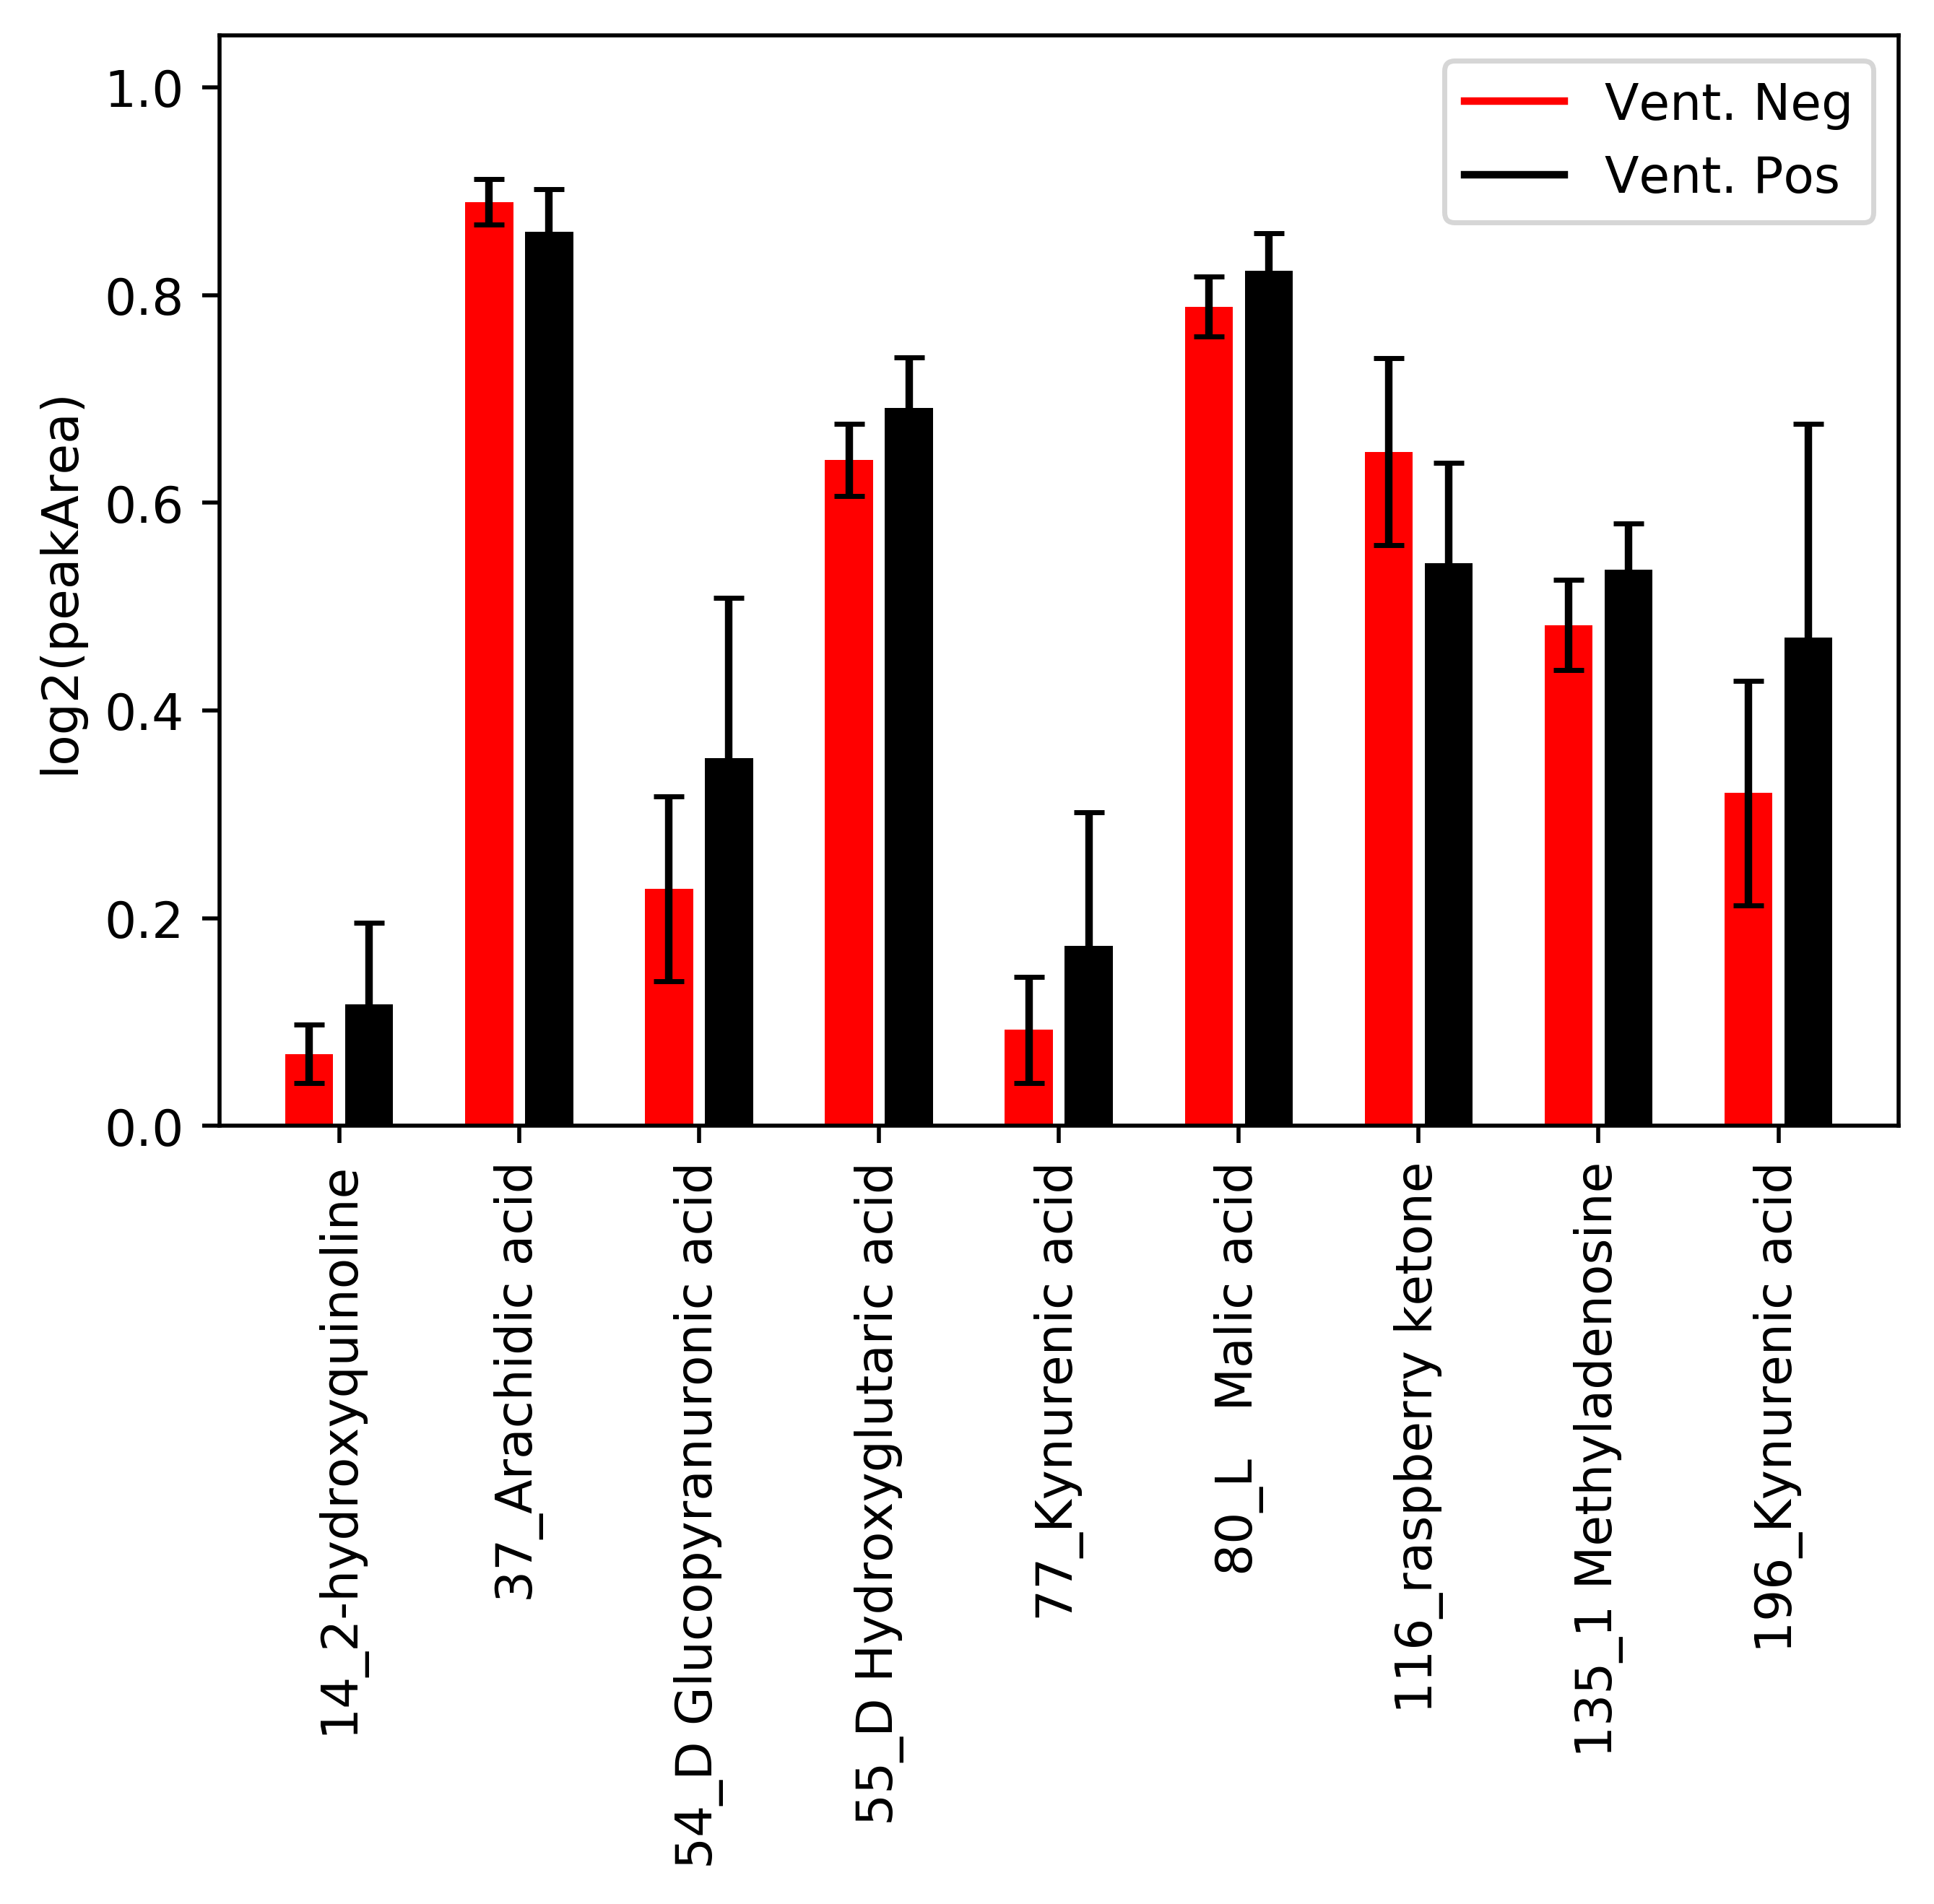

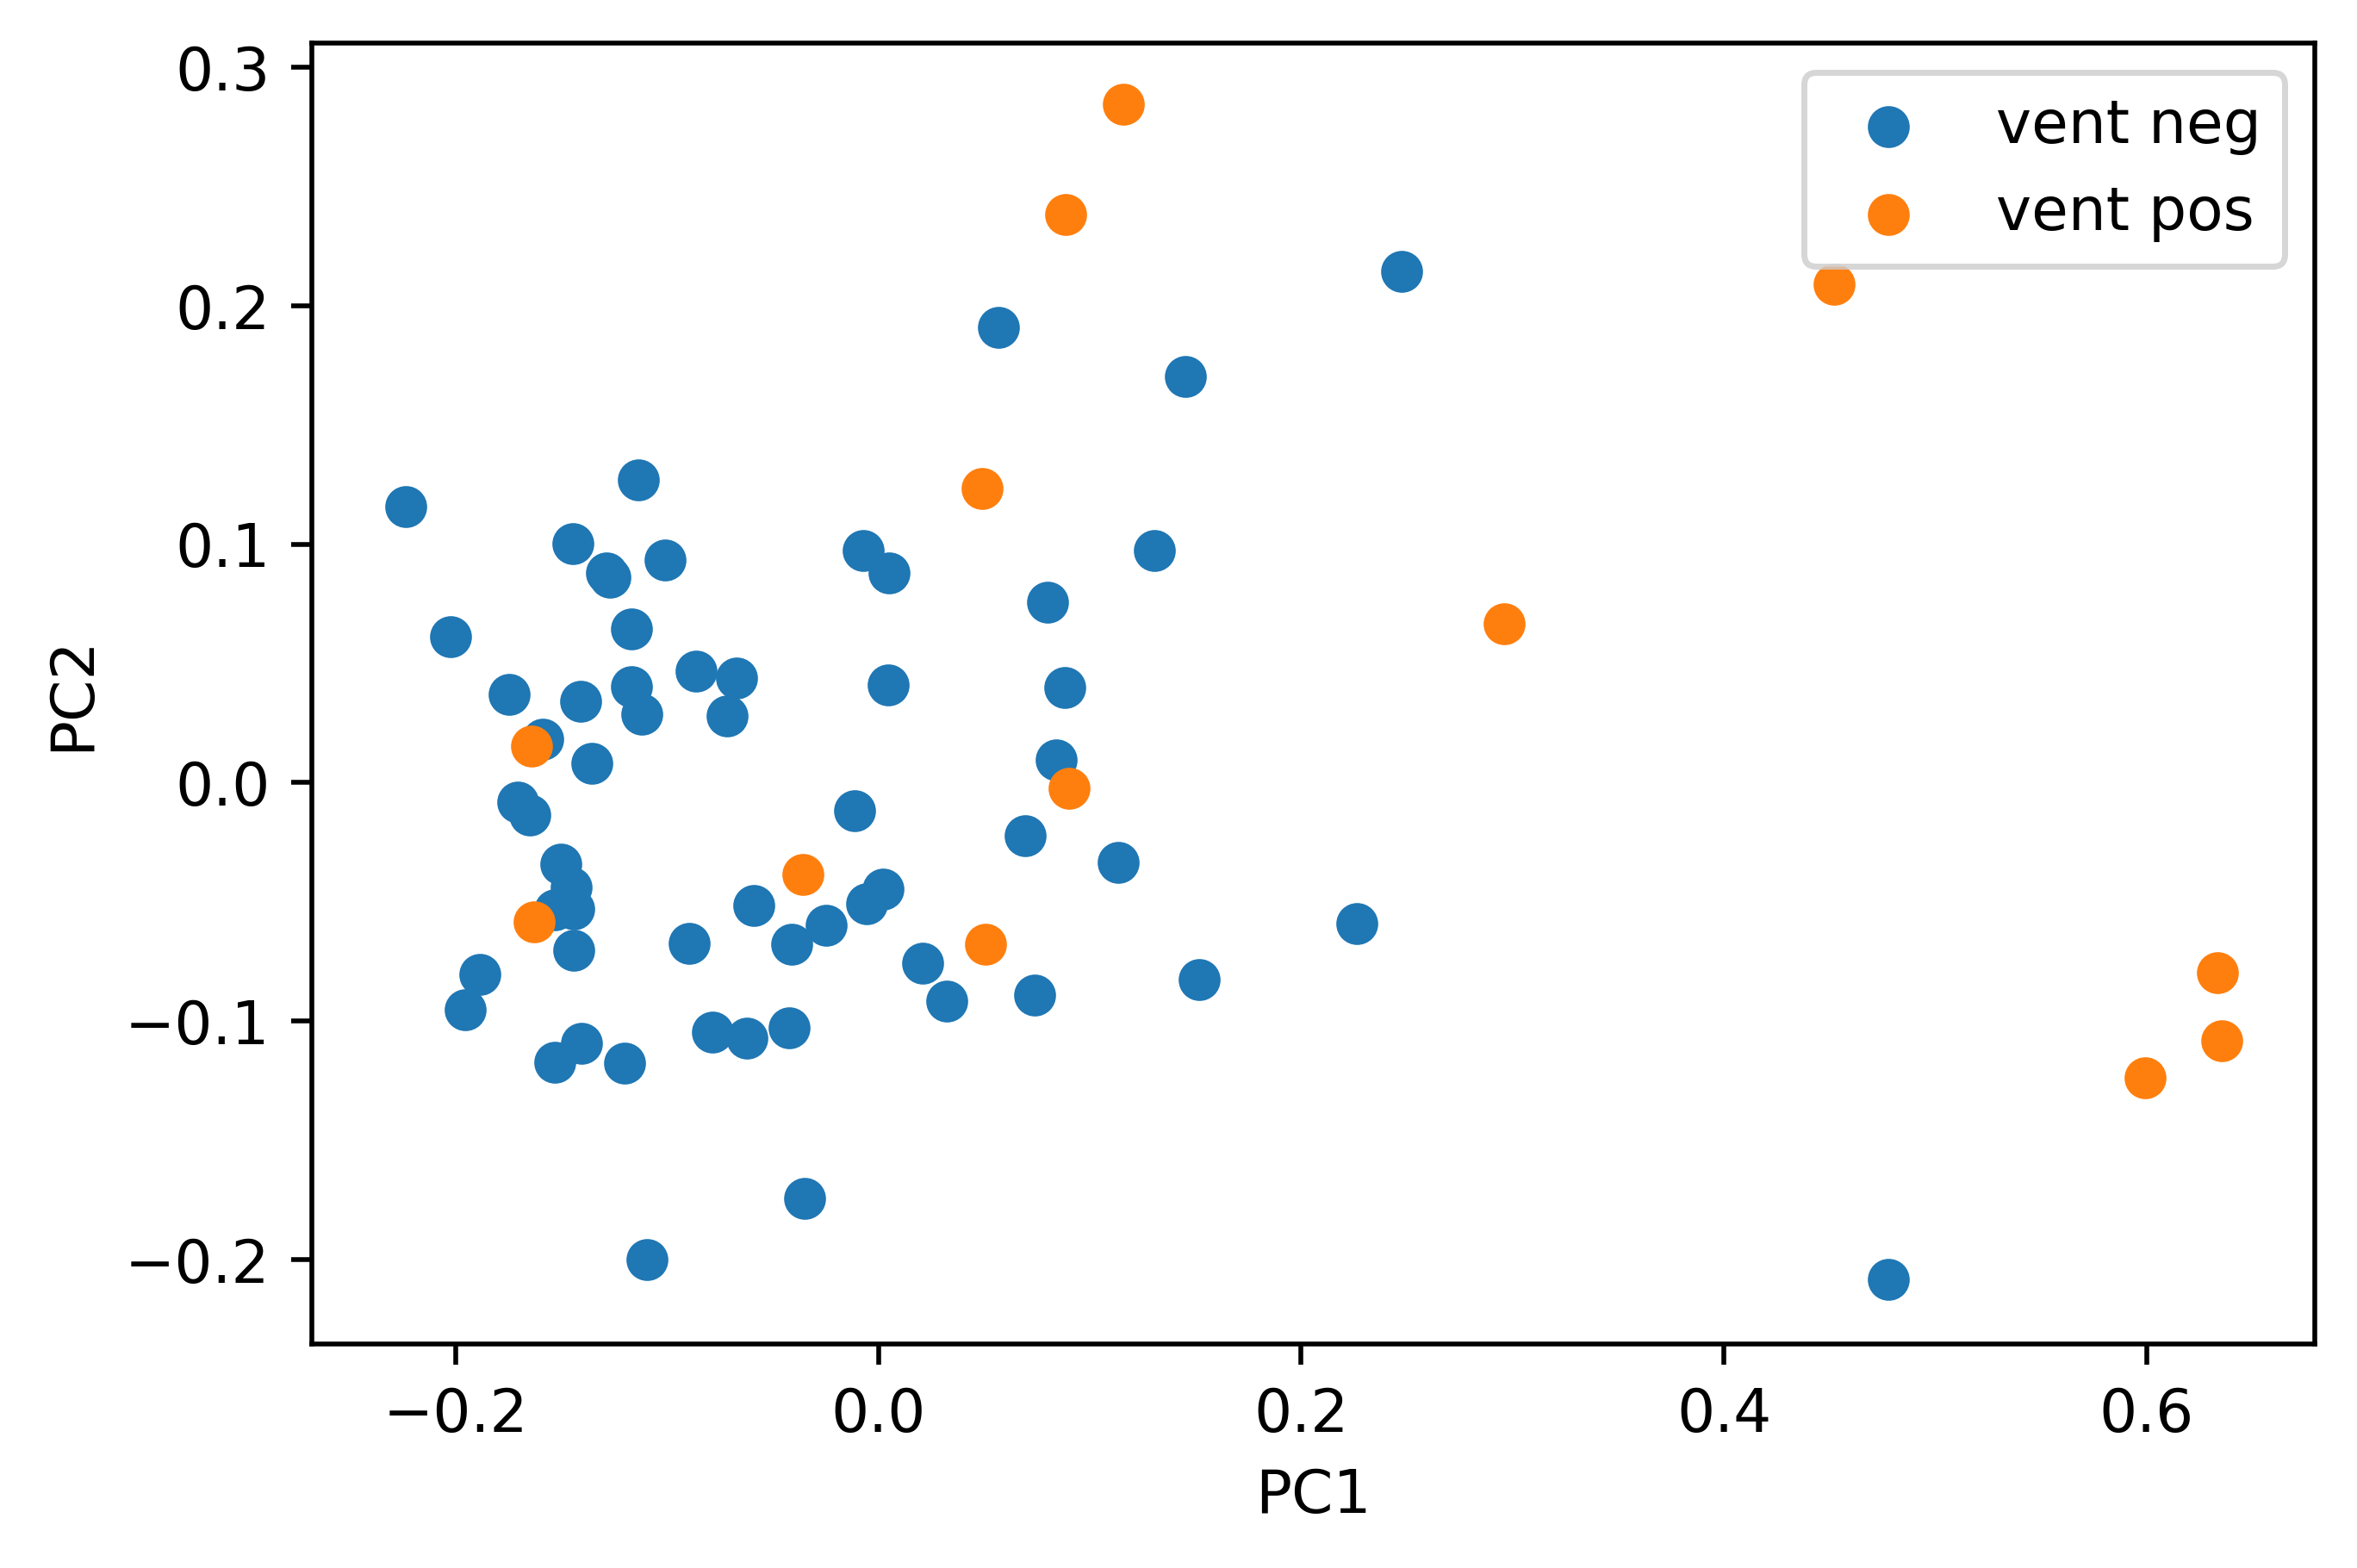

<Figure size 3000x2000 with 0 Axes>

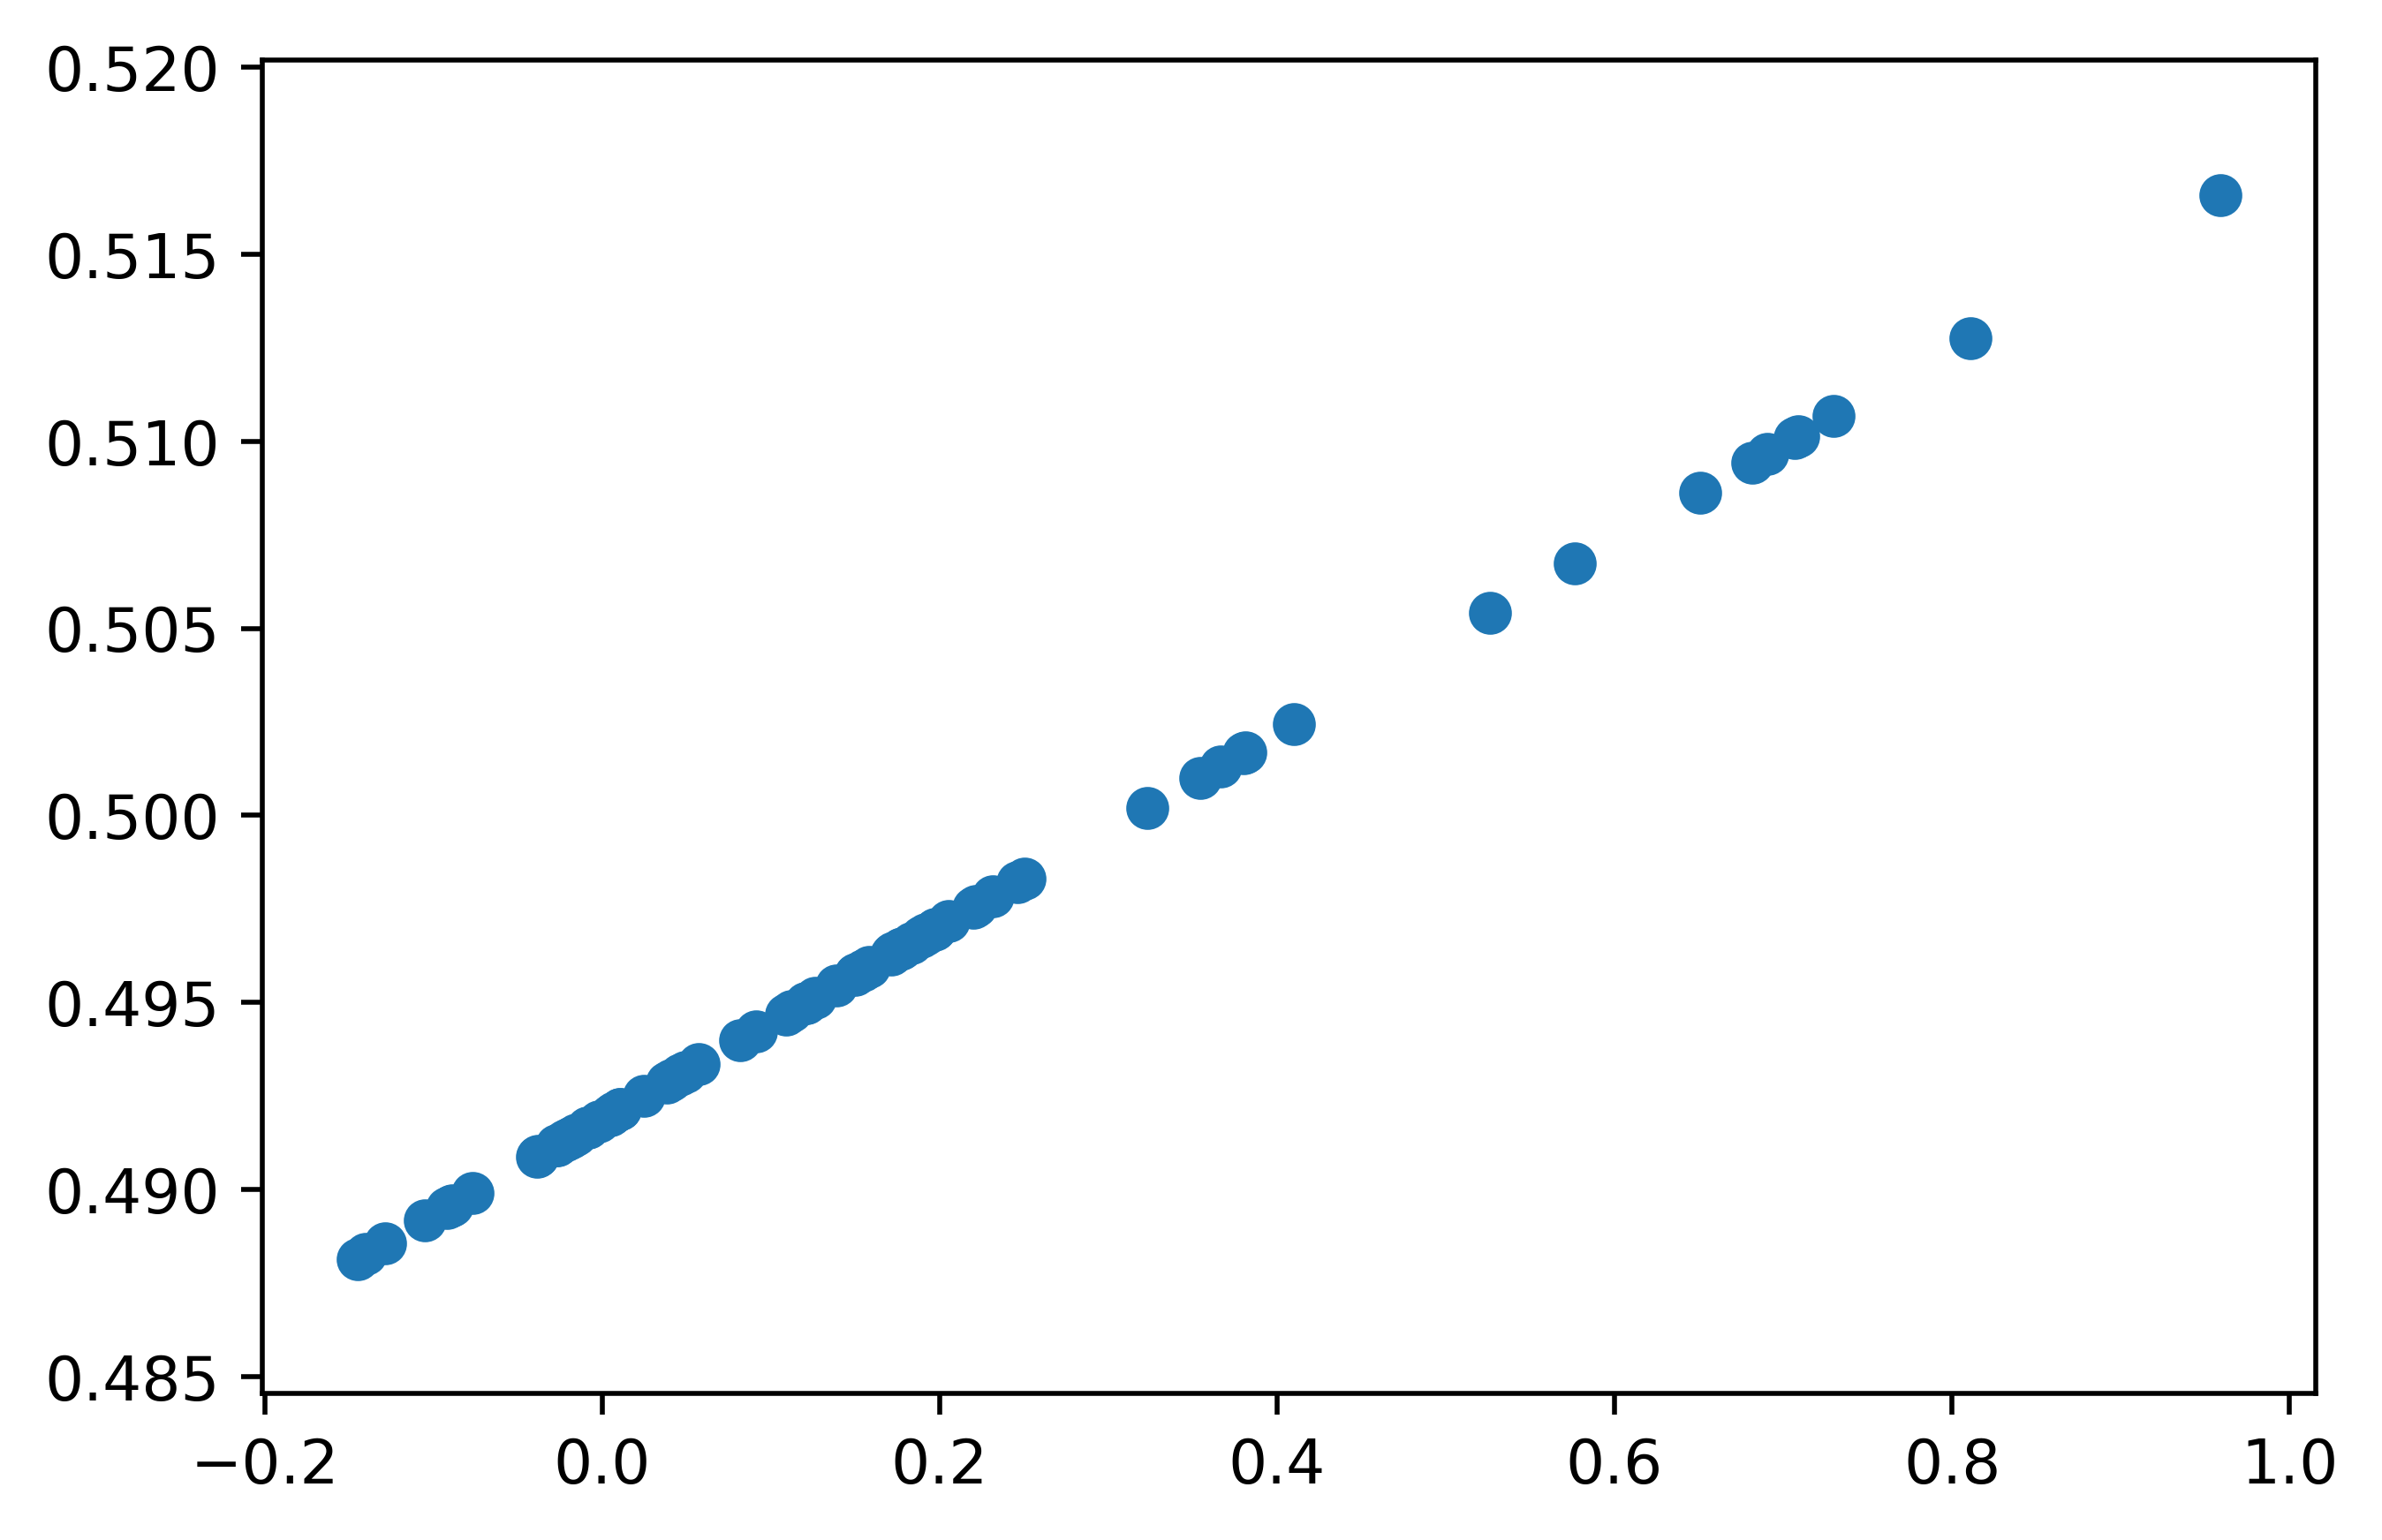

In [217]:
#repeat on entire dataset
ventNeg = np.array([x for x,y in zip(X_whole,y_whole) if y < .5])
ventPos = np.array([x for x,y in zip(X_whole,y_whole) if y > .5])

pval = 0.05
fc = 2.0

pvals = []
for met in range(len(ventNeg[0])):
    stat,p = stats.ttest_ind(ventNeg[:,met],ventPos[:,met])
    pvals.append(p)
        
reject,pvals_corr,_,_ = multipletests(pvals,pval,method="fdr_bh")
sigMet = [x for x in range(len(reject)) if reject[x]]
        
print(len(sigMet))
    
xpos = 0
poses = []
labels = []
for met in sigMet:
    metName = data.at[data.index.values[goodMets[met]],"Molecule Name"]#.split("_")[1]
    plt.bar([xpos,xpos+1],[np.mean(ventNeg[:,met]),np.mean(ventPos[:,met])],yerr=[np.std(ventNeg[:,met]),np.std(ventPos[:,met])],color=["red","black"],capsize=3)
    poses.append(xpos+.5)
    labels.append(metName)
    xpos += 3
    
plt.plot([-10,-10],[0,1],color="red",label="Vent. Neg")
plt.plot([-10,-10],[0,1],color="black",label="Vent. Pos")

plt.xticks(poses,labels=labels,rotation = 90)
plt.xlim((min(poses)-2,max(poses)+2))
plt.legend()
plt.ylabel("log2(peakArea)")

plt.figure()

data_reduced = pca.fit_transform(X_whole[:,sigMet])

plt.scatter(data_reduced[:len(vent_status_neg),0],data_reduced[:len(vent_status_neg),1],label="vent neg")
plt.scatter(data_reduced[len(vent_status_neg):,0],data_reduced[len(vent_status_neg):,1],label="vent pos")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

numPos = len([x for x in y_whole if x > .5])
numNeg = len(y_whole) - numPos
sampleWeights = [.5/numPos for _ in y_whole]
for x in range(len(y_whole)):
    if y_whole[x] < .5:
        sampleWeights[x] = .5/numNeg


plt.figure()

nc = 3
    
pls = PLSDA(n_components=nc)

pls.train(X_whole[:,sigMet],y_whole)

y_train_pred = pls.test(X_whole[:,sigMet])

logClass = LogisticRegression(fit_intercept=True,max_iter=1e4)

logClass.fit([[x] for x in y_train_pred],y_whole,sample_weight = sampleWeights)

y_train_pred_corr = logClass.predict([[x] for x in y_train_pred])

err_train = np.sum(np.abs(np.subtract(y_whole,y_train_pred_corr)))/len(y_whole)
plt.figure()
plt.scatter(y_train_pred,logClass.predict_proba([[x] for x in y_train_pred])[:,1])
print("training error: ",err_train)

print(sklearn.metrics.confusion_matrix(y_whole,y_train_pred_corr))

print(logClass.coef_,logClass.intercept_)
cont_dict = {}
for name,val,coef in zip(labels,pls.model.vip_,pls.model.coef_):
    print(name,val,coef)
    cont_dict[name] = {"VIP":val,"Coefficient":coef}
pd.DataFrame.from_dict(cont_dict,orient="index").to_csv("variable_contributions_06252020.csv")
    
print(pls.model.coef_)